In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 36883123


In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 36883123  # EW, only 2 sectors of 2min data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 2 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 04 2018      SPOC     120    36883123      0.0     G011154
  1 TESS Sector 31 2020 TESS-SPOC     600    36883123      0.0         N/A

19146

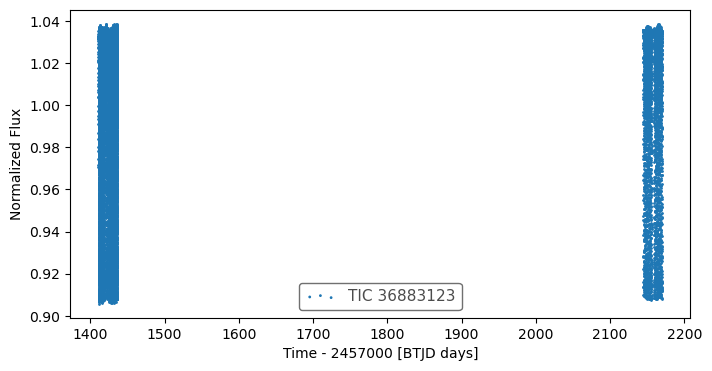

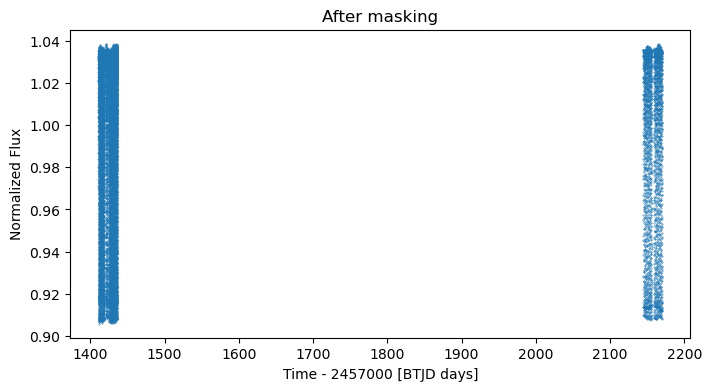

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [6]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

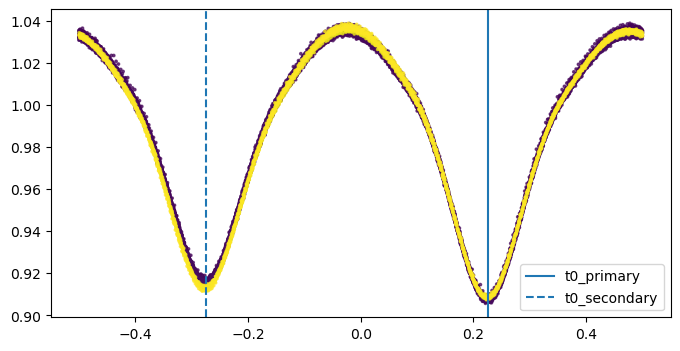

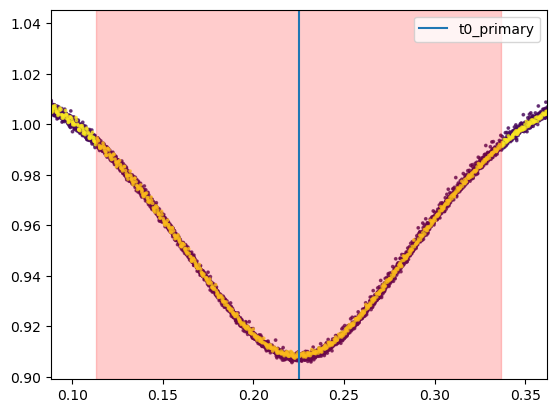

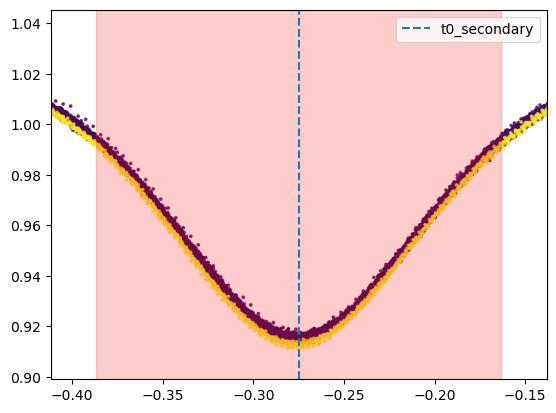

In [8]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# TESS EB (1 sector):  epoch=1411.0491075945126, period=0.3352717948855966	
# VSX: 0.3352700 
# TCE1: 0.335231
# LombScargle: 0.33605695437946476	0.0019239	-0.0019073	
# AoV on data_primary: 0.335115 , 0.335422
# MCMC of data_primary: 0.33527054700291914, std_p: 2.7297800939365487e-09, 1411.0493422817128, std_t0: 4.330605466846802e-06

# FILL-IN THE eclipse epoch / period, 
period = 0.335270895  #  (0.33527179 + 0.3352700) / 2  # Average of TESS EB and VSX period
period = 0.33527055  # MCMC

t0_primary = 1411.0493  # MCMC
t0_secondary = t0_primary + period / 2


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 1.8
duration_hr_secondary = 1.8

# t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [32]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.010, -0.103, midpoint_p, 0.0691, 0.845]
start_vals_s = [1.011, -0.0975, midpoint_s, 0.0705, 0.8549]
    
# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, t0_primary, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1411.0493 0.22499999999981735
window_width_p (phase): 0.2684399211323512
Secondary: 1411.216935275 -0.2749999999999857
window_width_s (phase): 0.2684399211323512


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.01, -0.103, t0_primary, 0.0691, 0.845, 0.33527055],


In [16]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1500/1500 [03:42<00:00,  6.73it/s]


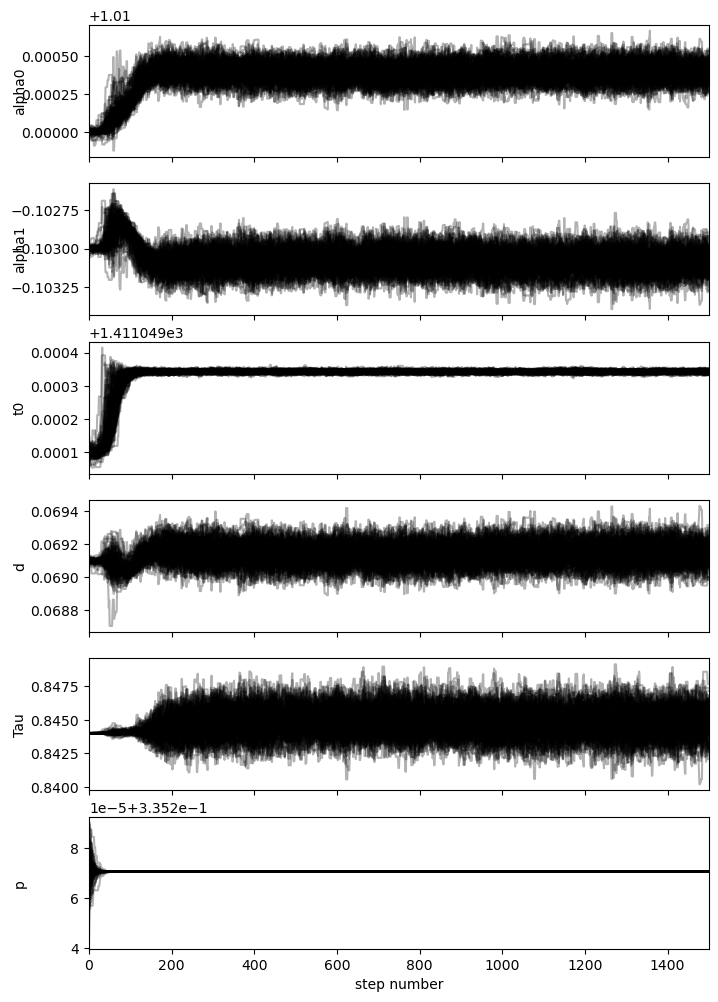

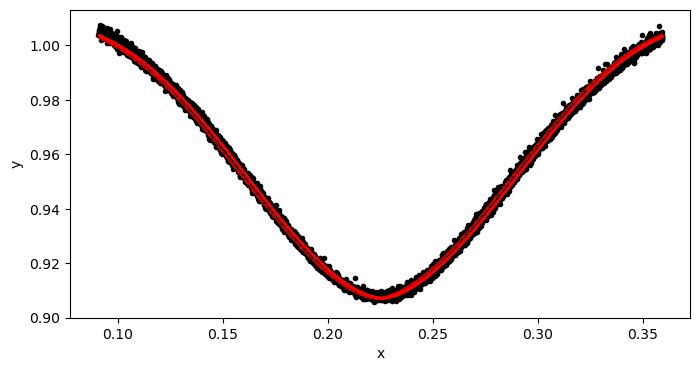

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0103981562942548, -0.10308409905606553, 1411.0493422817128, 0.06914423448226648, 0.8448003196604315, 0.33527054700291914
std_p: 2.7297800939365487e-09 ; std_t0: 4.330605466846802e-06


In [28]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result, 1st run
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0104009124986546, -0.10308833452634303, 1411.0493421078963, 0.06914799693539844, 0.8448270541774654, 0.3352705470955046
    # std_p: 1.87919933581313e-05 ; std_t0: 0.0002536400894151709
    # 2nd run
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0103981562942548, -0.10308409905606553, 1411.0493422817128, 0.06914423448226648, 0.8448003196604315, 0.33527054700291914
    # std_p: 2.7297800939365487e-09 ; std_t0: 4.330605466846802e-06
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.01, -0.103, t0_primary, 0.0691, 0.844, 0.335270895],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        # nruns=1000, discard=600,  
        nruns=1500, discard=900,  # converged better, with better initial guess,  increased runs is not necessary
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

100%|██████████████████████████████████████████████████████████| 1000/1000 [02:57<00:00,  5.65it/s]


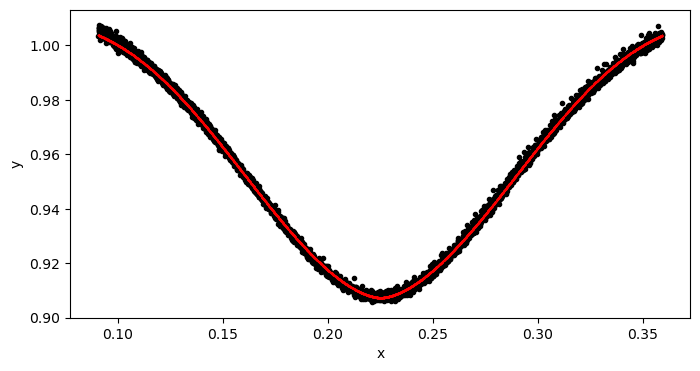

100%|██████████████████████████████████████████████████████████| 1000/1000 [03:00<00:00,  5.55it/s]


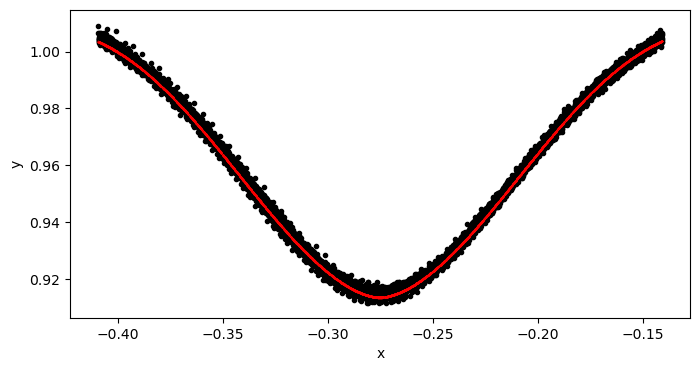

In [33]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [35]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    # with period from (VSX + TESS EB) /2 :    
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0104119841096564, -0.10307410514777457, 0.2244765637873273, 0.06916742867987866, 0.8448160703421733
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0110889730497141, -0.09754422538050522, -0.2760135787303889, 0.07050911857594838, 0.8548962764593122
    # with period from MCMC:
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.010574014325437, -0.10327619383263976, 0.22511935873892025, 0.0692976923451663, 0.8433399977555502
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0110237425915063, -0.09750654781432117, -0.2753552971313348, 0.07043412782510691, 0.8551247101617971    

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [36]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.010574014325437, -0.10327619383263976, 0.22511935873892025, 0.0692976923451663, 0.8433399977555502
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0110237425915063, -0.09750654781432117, -0.2753552971313348, 0.07043412782510691, 0.8551247101617971


2263

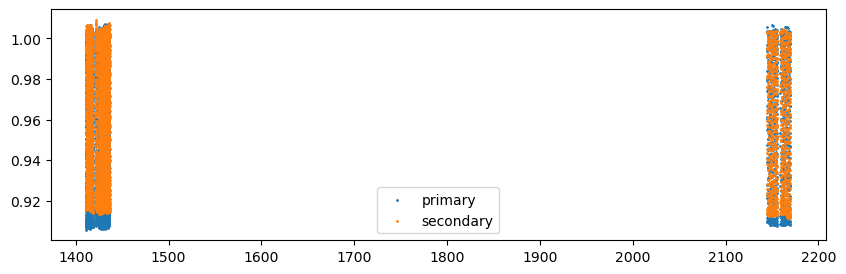

In [37]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1411.0493 0.33527055 1411.0493


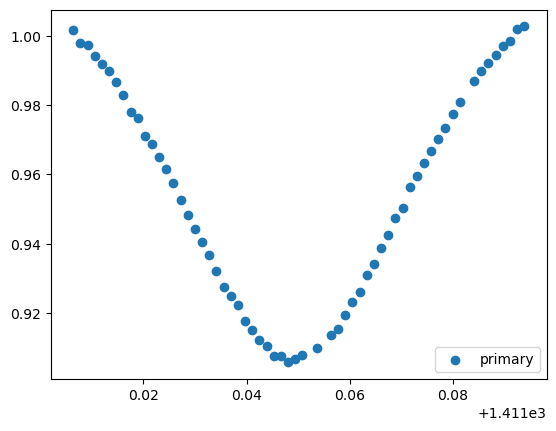

1411.0493 0.33527055 1411.3845705499998


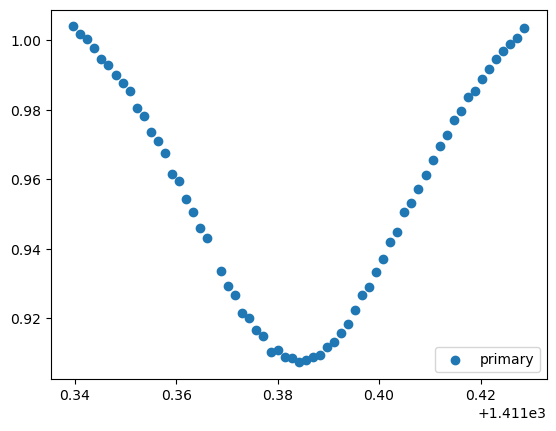

1411.0493 0.33527055 1411.7198411


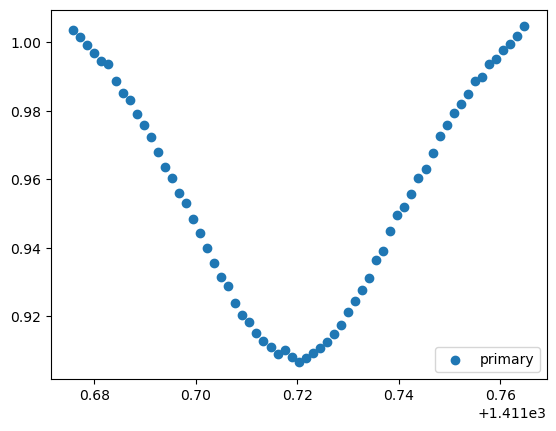

1411.216935275 0.33527055 1411.216935275


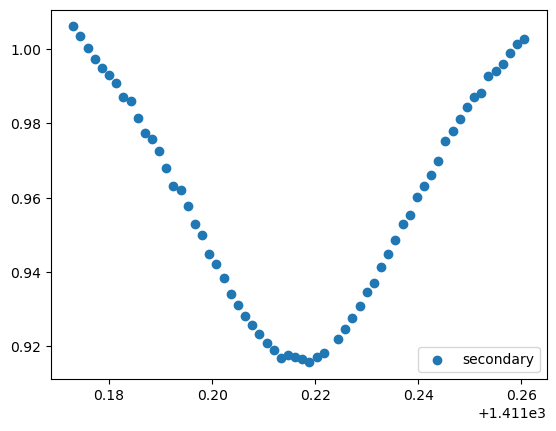

1411.216935275 0.33527055 1411.5522058249999


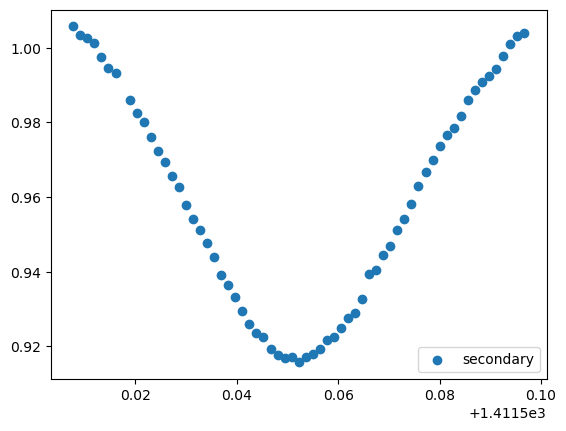

1411.216935275 0.33527055 1411.887476375


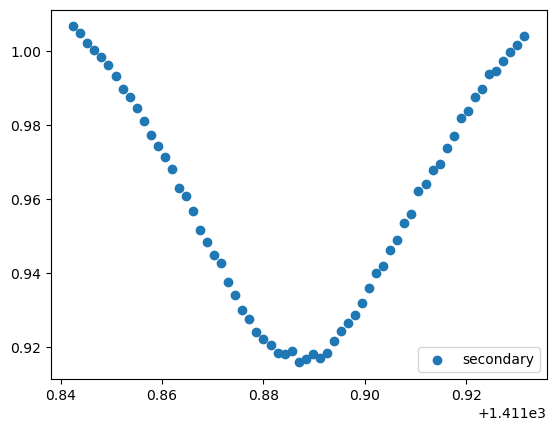

In [38]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1411.3845705499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.36it/s]


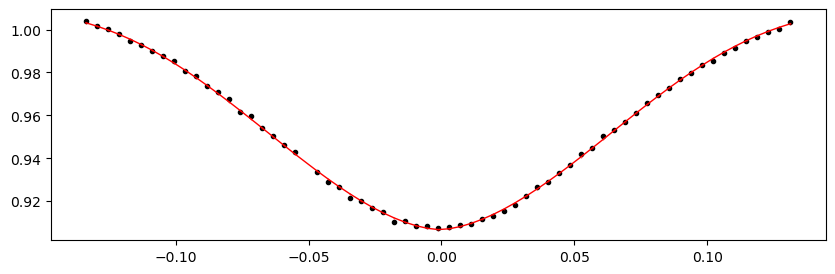

1411.7198411 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.20it/s]


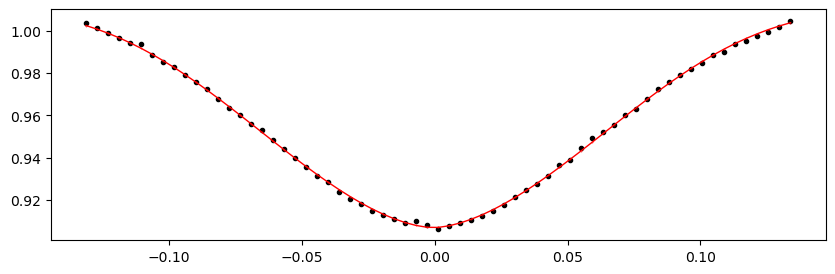

1412.0551116499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.69it/s]


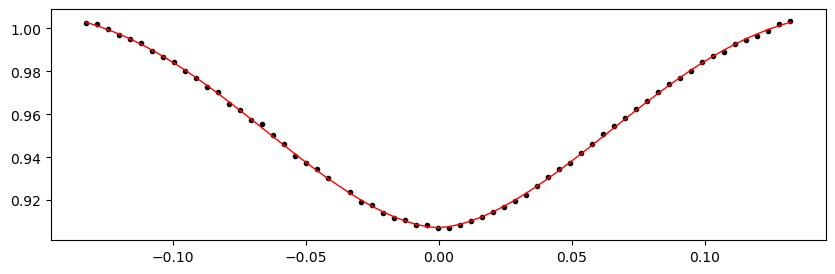

1412.3903822 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.31it/s]


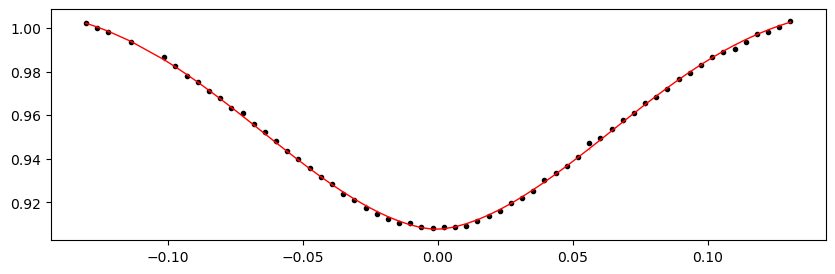

1412.7256527499999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.93it/s]


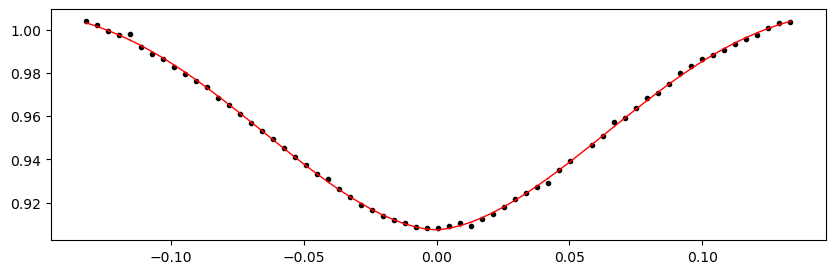

1413.0609233 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.85it/s]


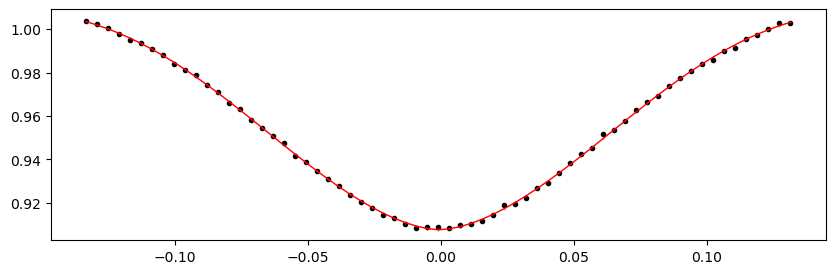

1413.39619385 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.66it/s]


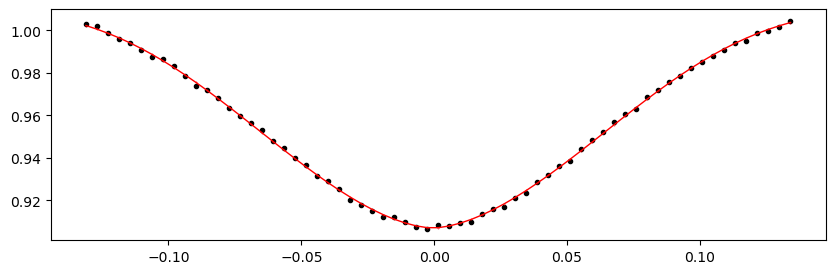

1413.7314643999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.46it/s]


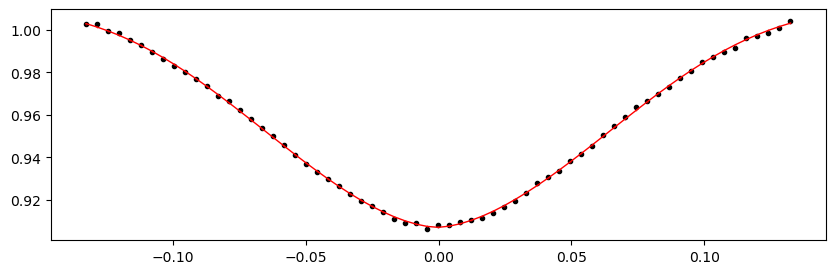

1414.06673495 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.71it/s]


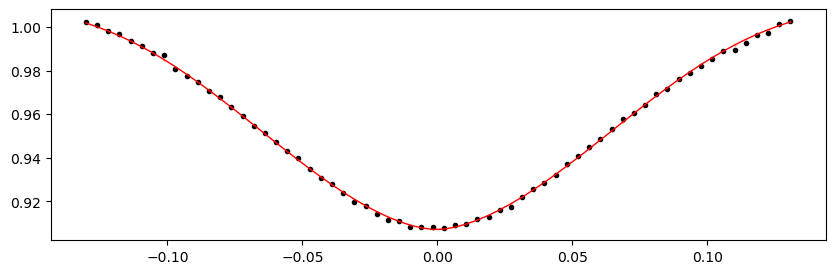

1414.4020054999999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.87it/s]


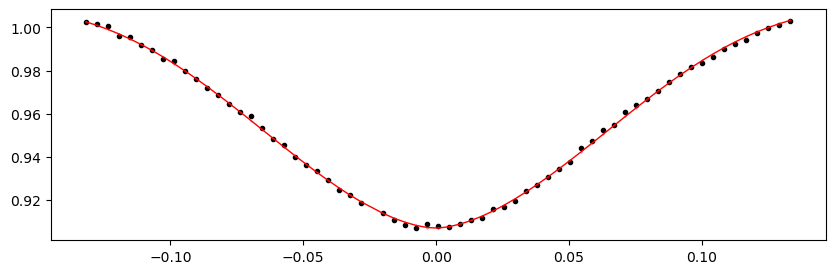

1414.73727605 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.84it/s]


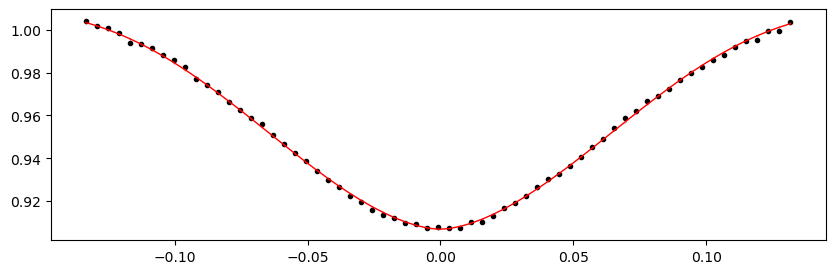

1415.0725466 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.25it/s]


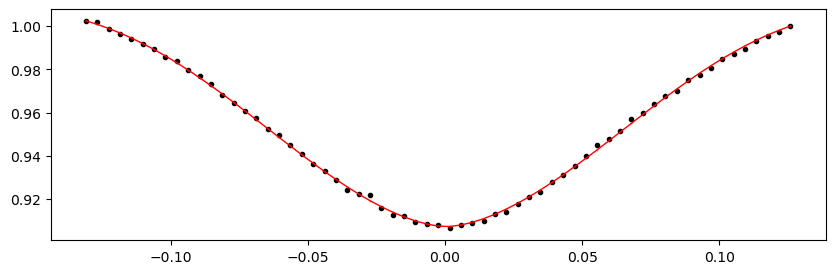

1415.4078171499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.28it/s]


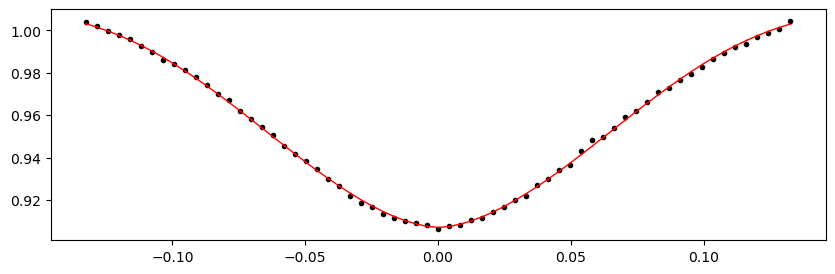

1415.7430877 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.89it/s]


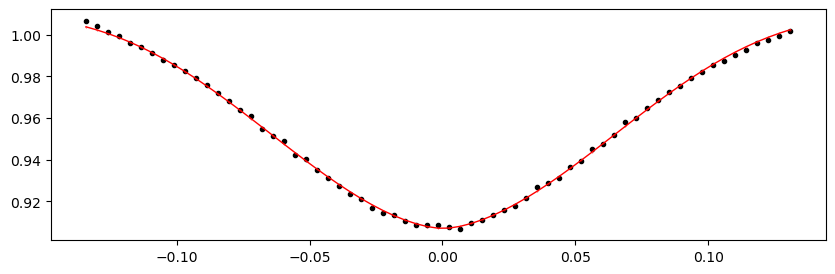

1416.0783582499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.17it/s]


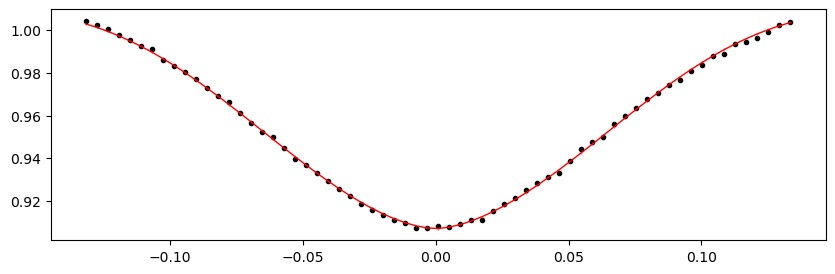

1416.4136288 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.92it/s]


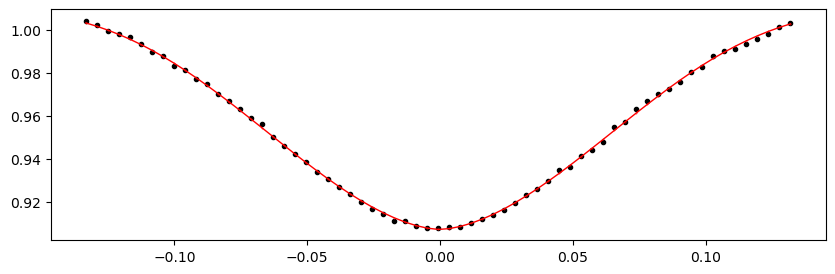

1416.7488993499999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.66it/s]


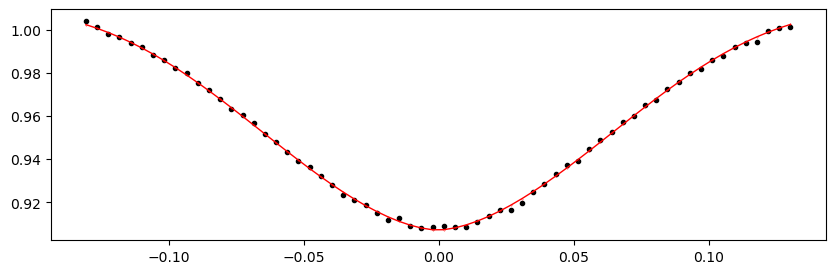

1417.0841699 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.46it/s]


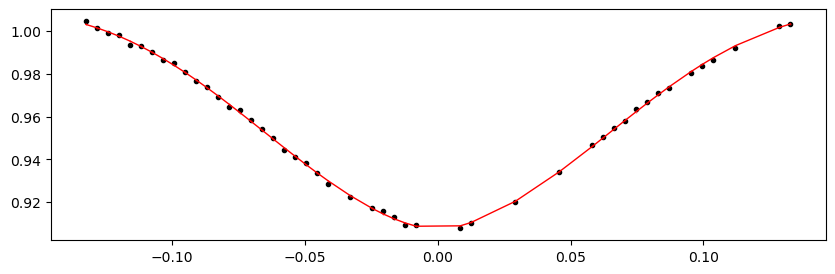

1417.41944045 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.34it/s]


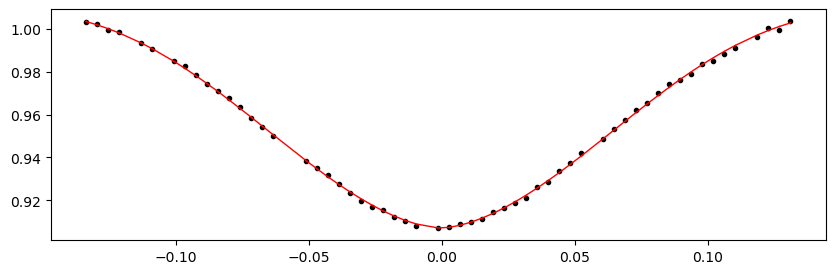

1417.7547109999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [01:18<00:00, 127.70it/s]


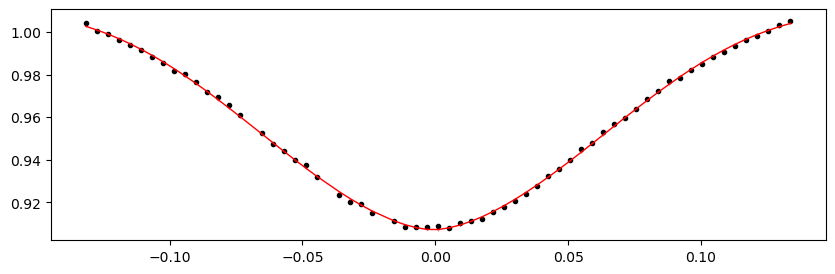

1418.08998155 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:44<00:00, 222.56it/s]


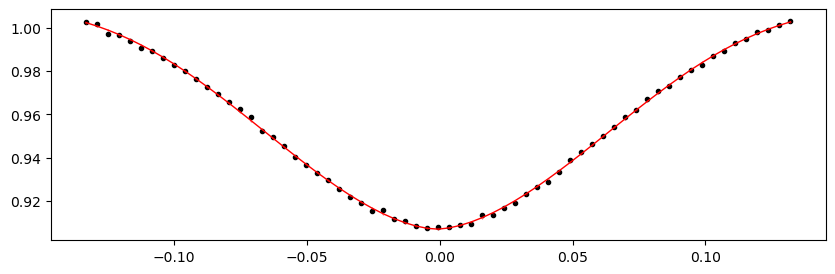

1418.4252520999999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.68it/s]


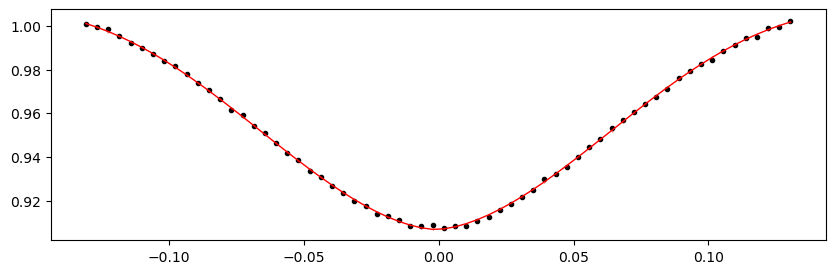

1421.44268705 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.17it/s]


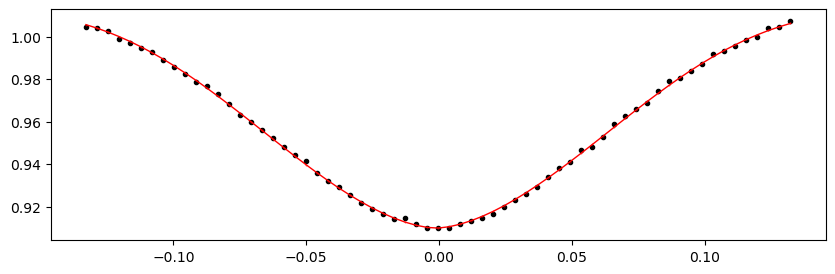

1421.7779575999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.61it/s]


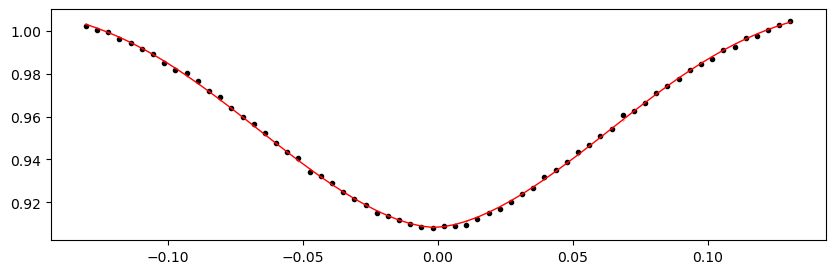

1422.11322815 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 400.92it/s]


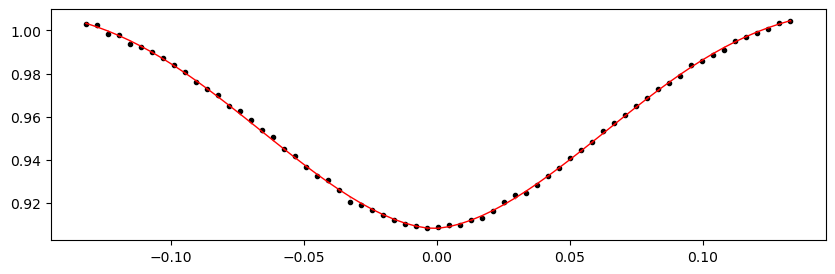

1422.4484986999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.89it/s]


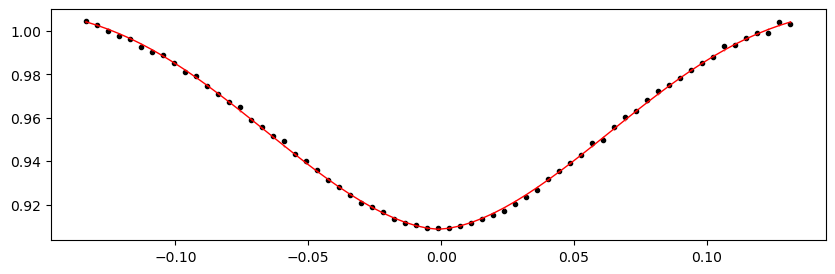

1424.7953925499999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.92it/s]


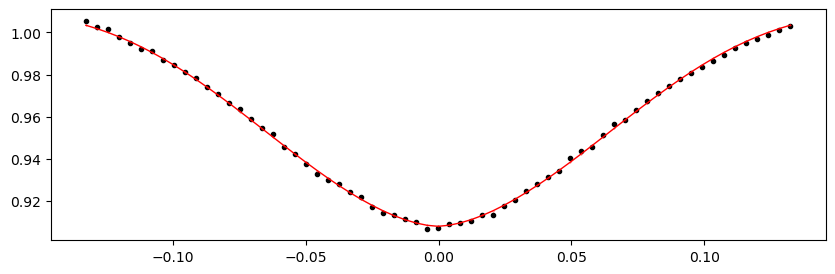

1425.1306631 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.55it/s]


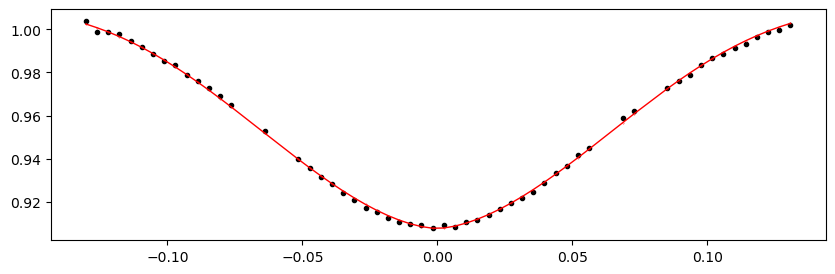

1425.46593365 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.36it/s]


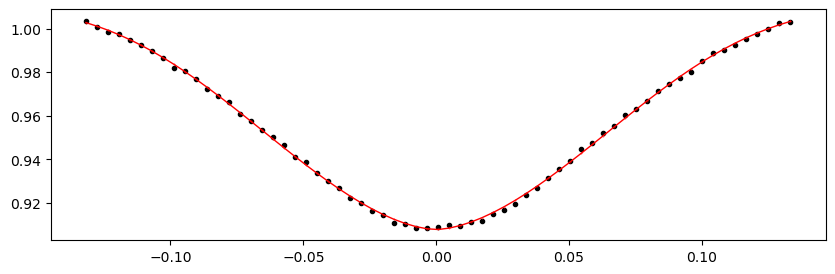

1425.8012041999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.35it/s]


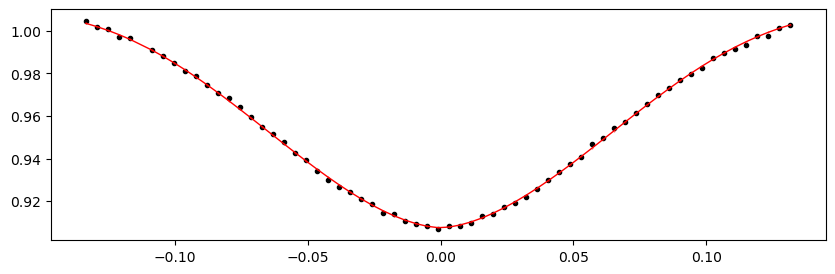

1426.13647475 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.83it/s]


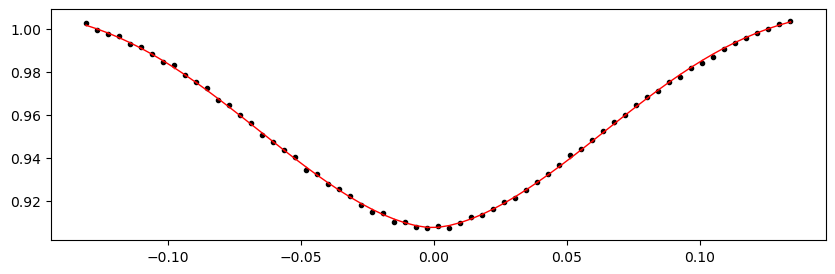

1426.4717452999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.76it/s]


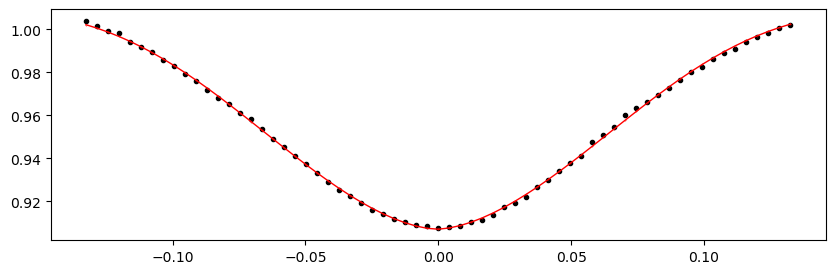

1426.80701585 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.09it/s]


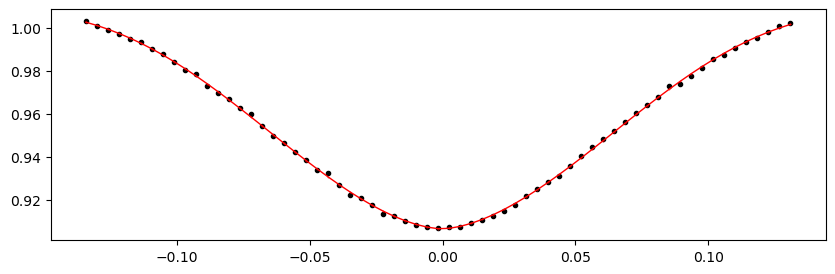

1427.1422863999999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.67it/s]


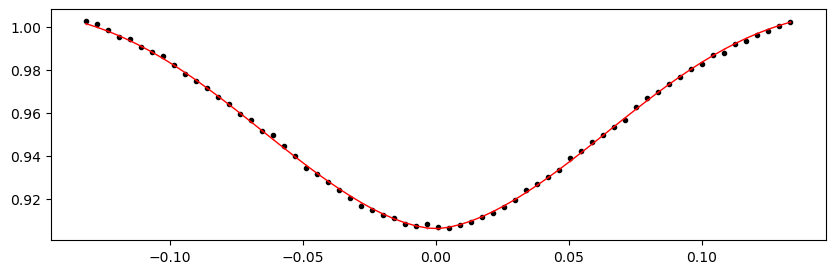

1427.47755695 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.24it/s]


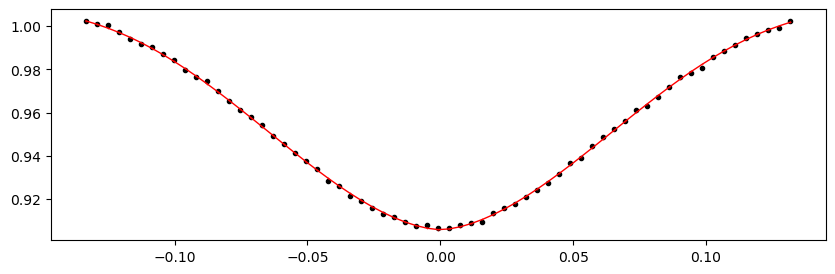

1427.8128275 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.22it/s]


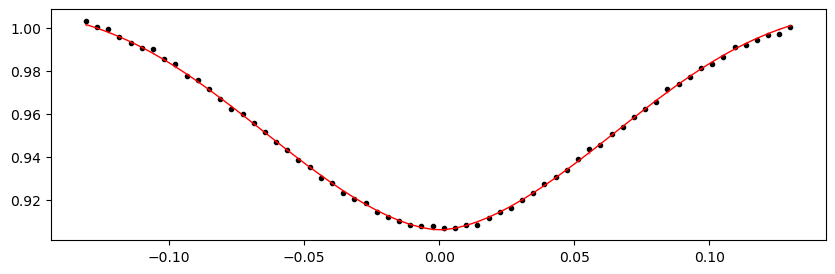

1428.1480980499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 384.69it/s]


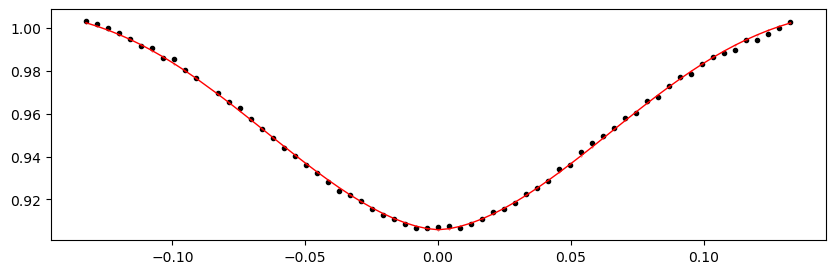

1428.4833686 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.16it/s]


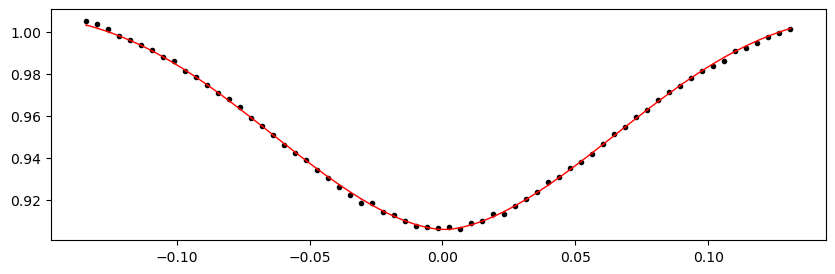

1428.8186391499999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.24it/s]


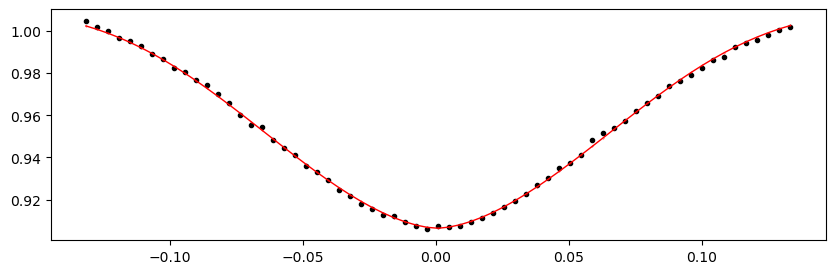

1429.1539097 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.41it/s]


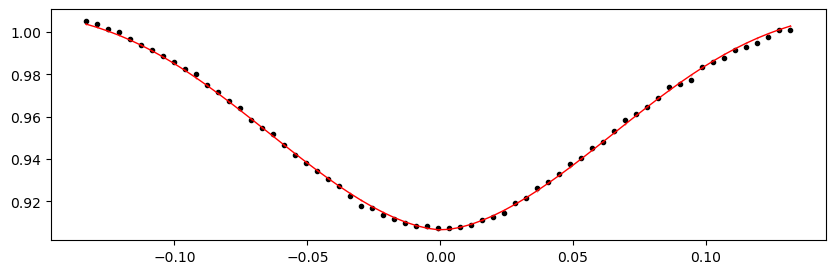

1429.48918025 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.41it/s]


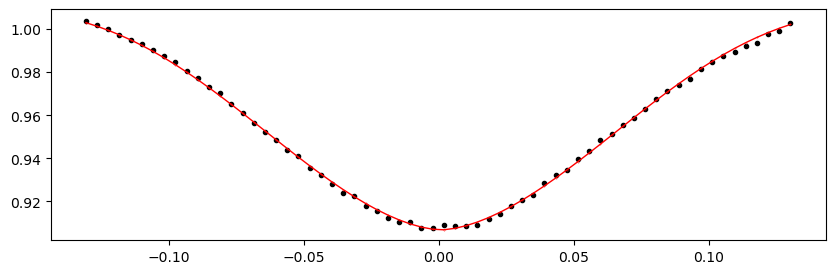

1429.8244507999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.95it/s]


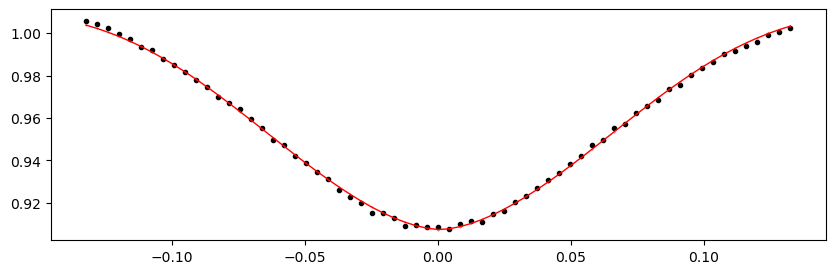

1430.15972135 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.31it/s]


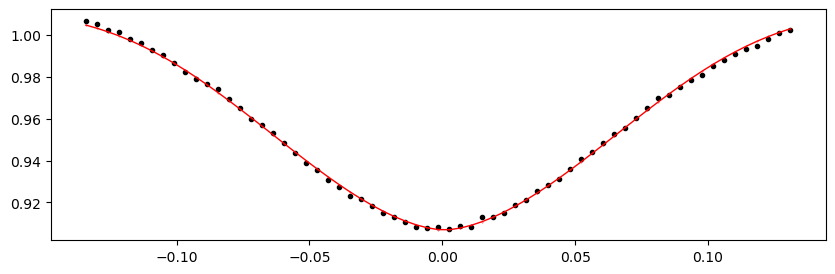

1430.4949918999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.92it/s]


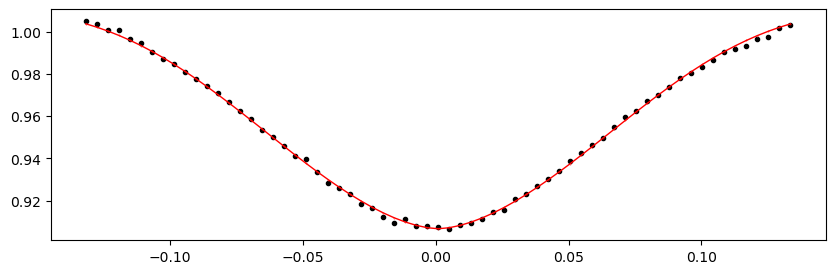

1430.83026245 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.82it/s]


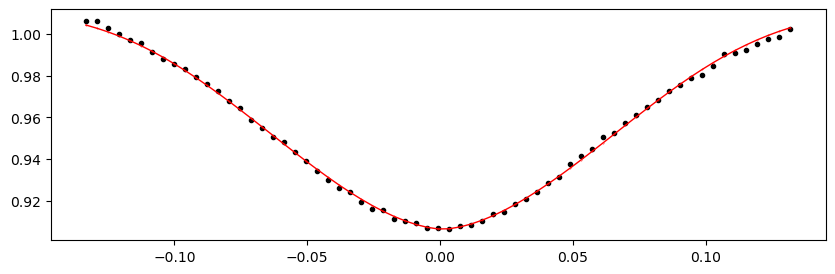

1431.1655329999999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.22it/s]


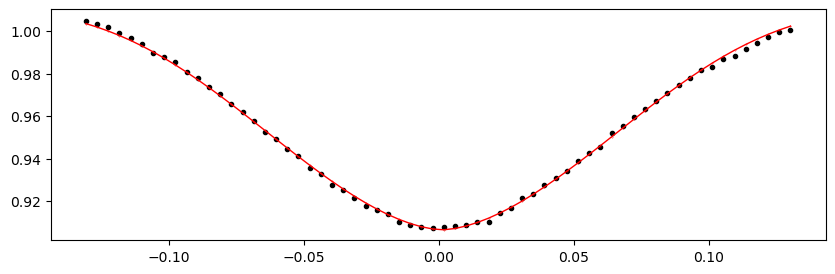

1431.50080355 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.32it/s]


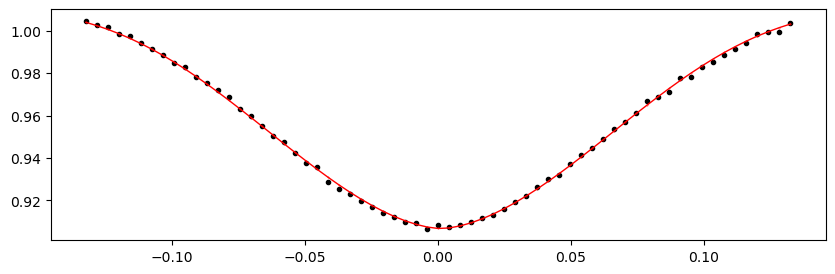

1431.8360741 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 384.57it/s]


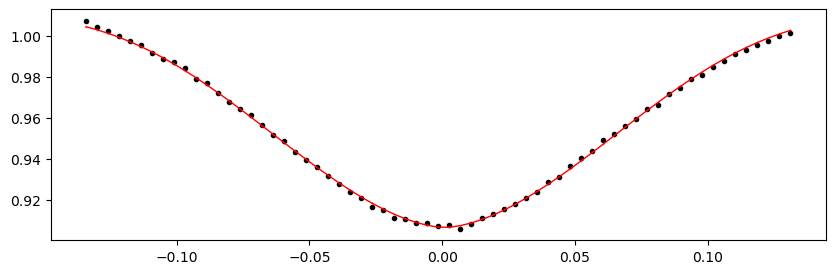

1432.1713446499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.16it/s]


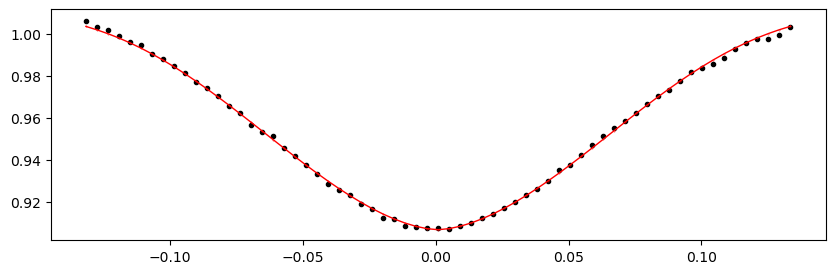

1432.5066152 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.64it/s]


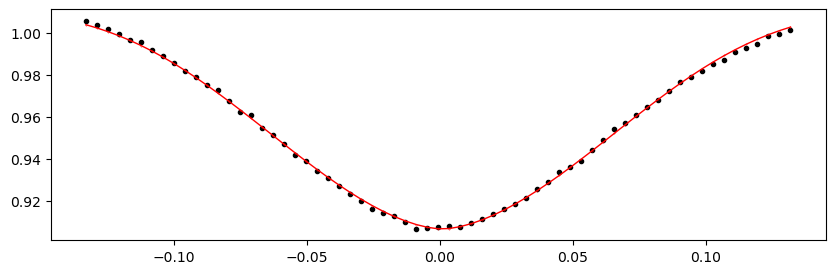

1432.8418857499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.81it/s]


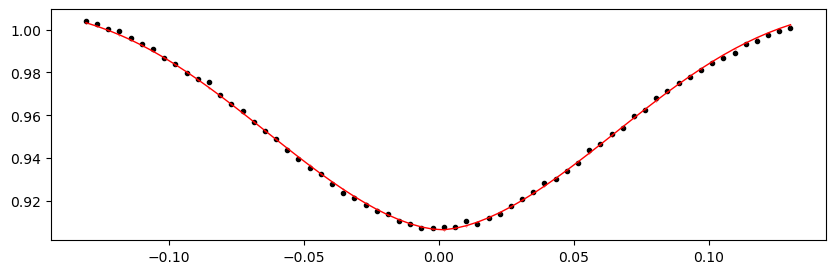

1433.1771563 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.92it/s]


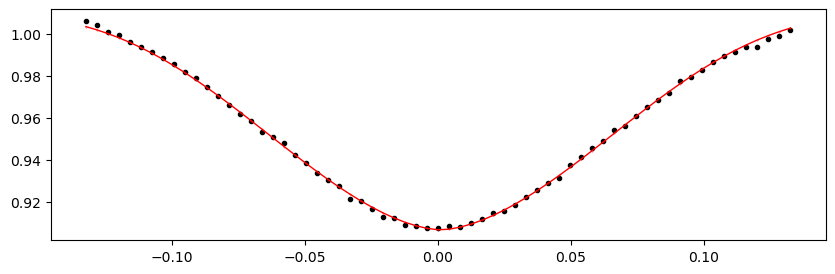

1433.5124268499999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.42it/s]


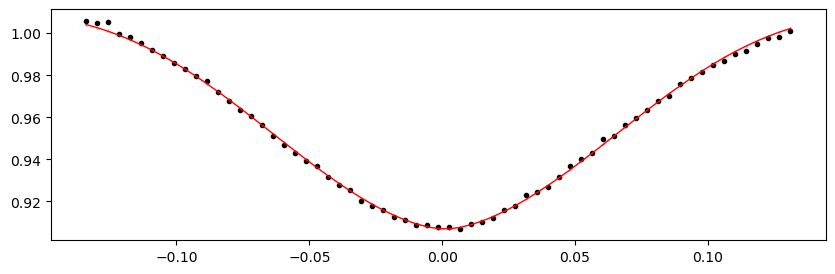

1433.8476974 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.01it/s]


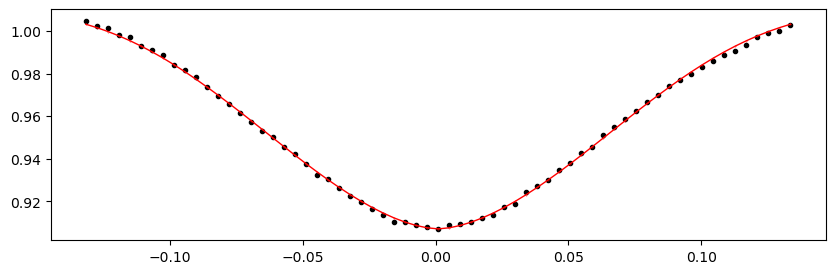

1434.18296795 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.16it/s]


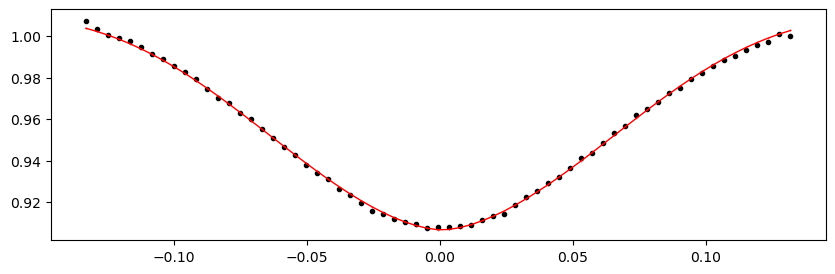

1434.5182384999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.73it/s]


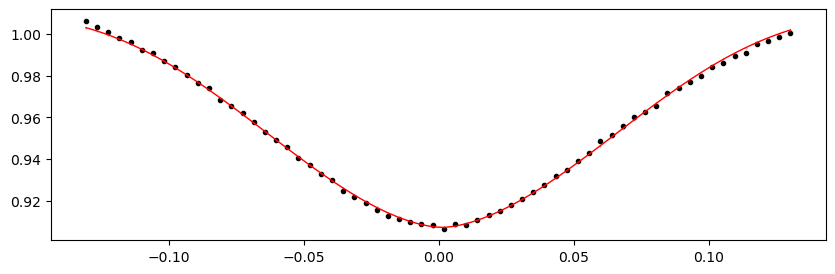

1434.85350905 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.00it/s]


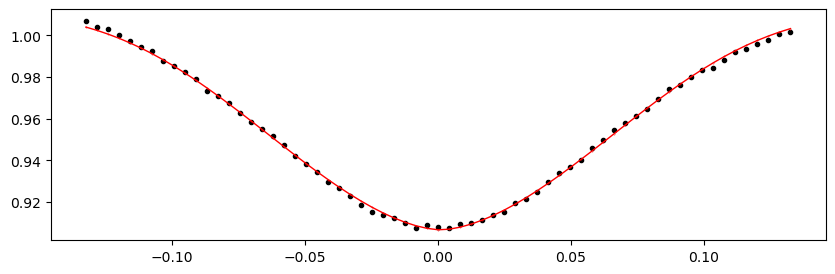

1435.1887795999999 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.50it/s]


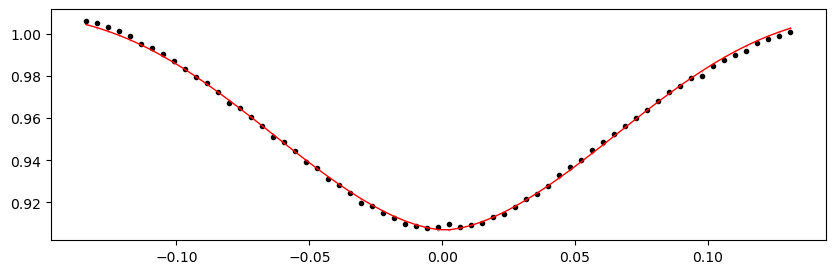

1435.52405015 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.57it/s]


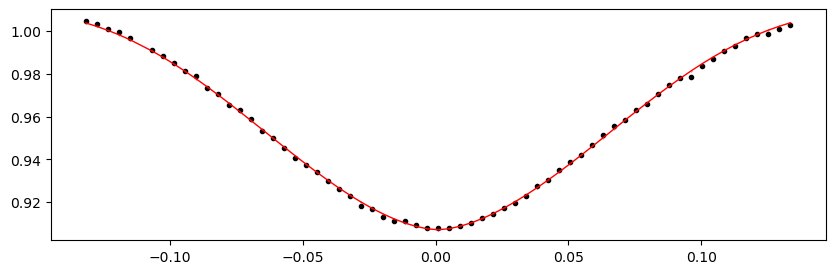

1435.8593207 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.01it/s]


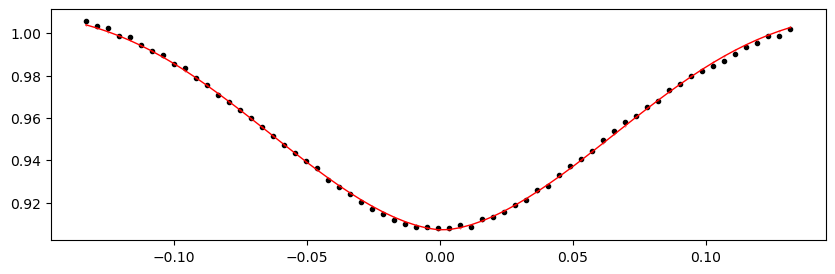

1436.1945912499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.26it/s]


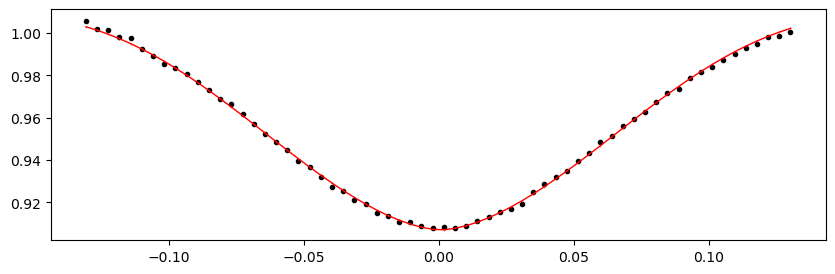

2144.6212634 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.95it/s]


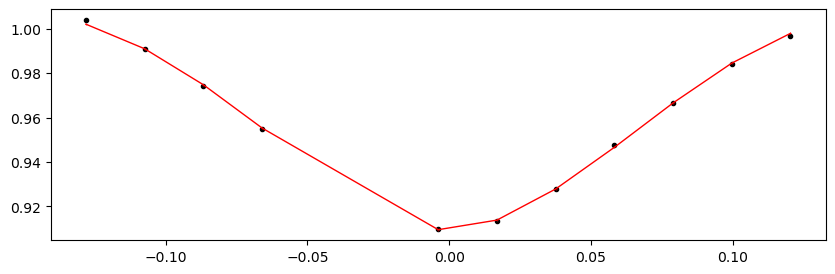

2144.95653395 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.59it/s]


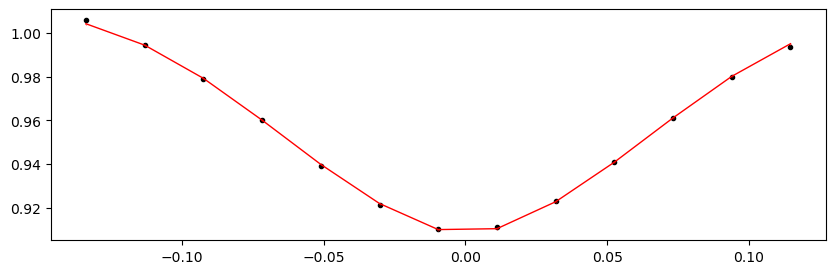

2145.2918044999997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.18it/s]


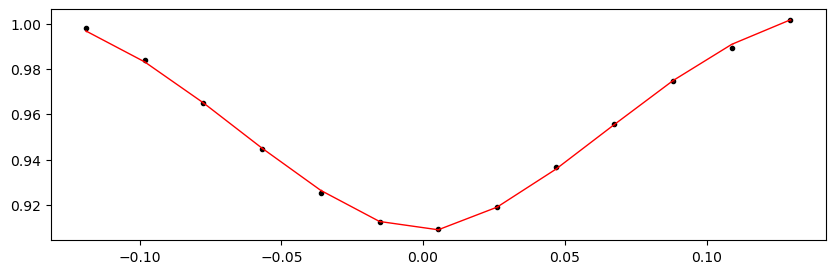

2145.62707505 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.32it/s]


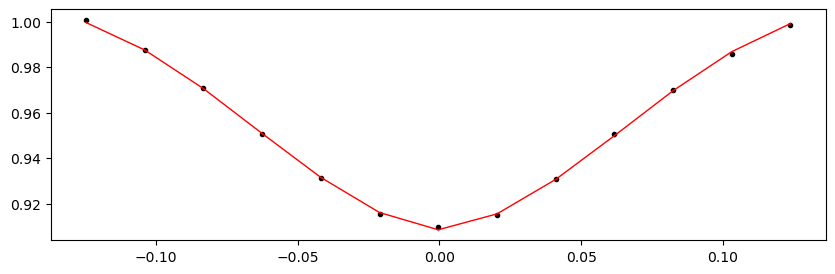

2145.9623456 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.36it/s]


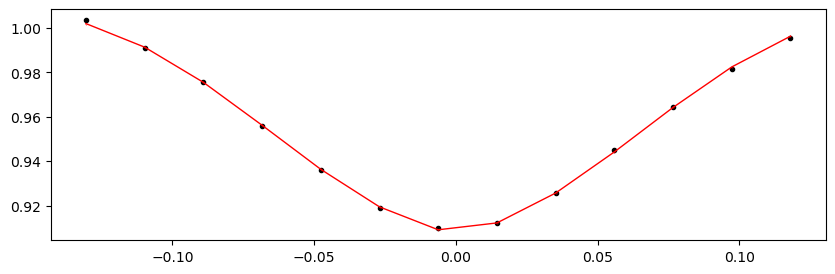

2146.29761615 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.16it/s]


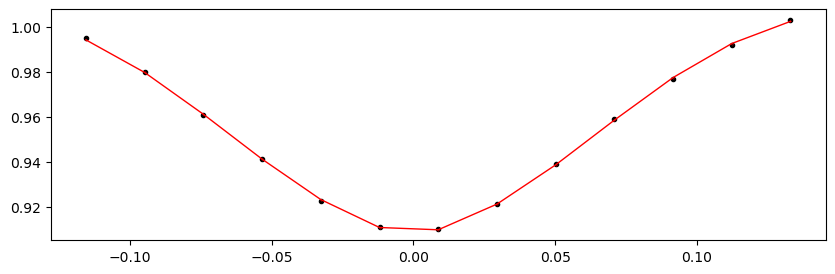

2146.6328866999997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.73it/s]


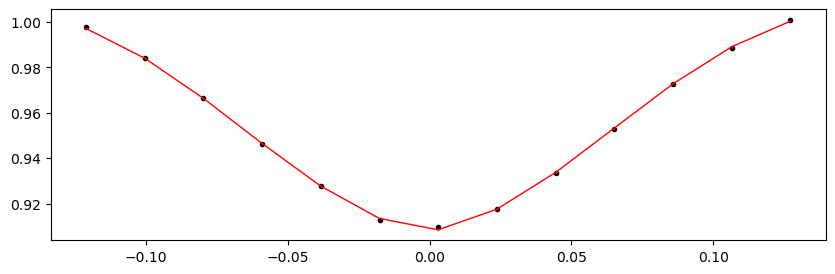

2146.96815725 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.78it/s]


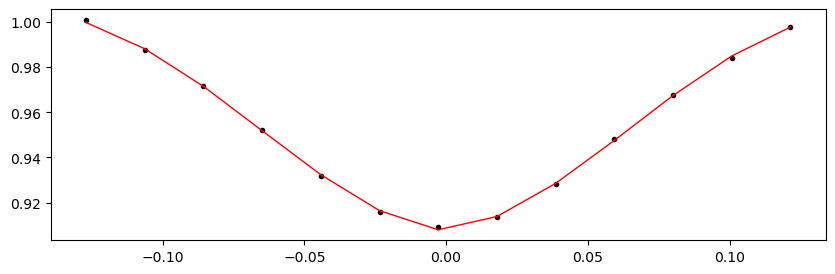

2147.3034278 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.23it/s]


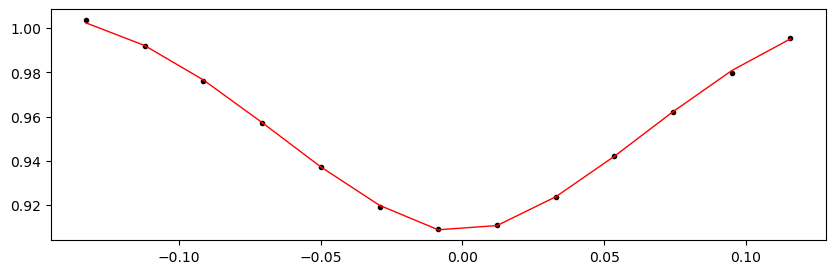

2147.6386983499997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.67it/s]


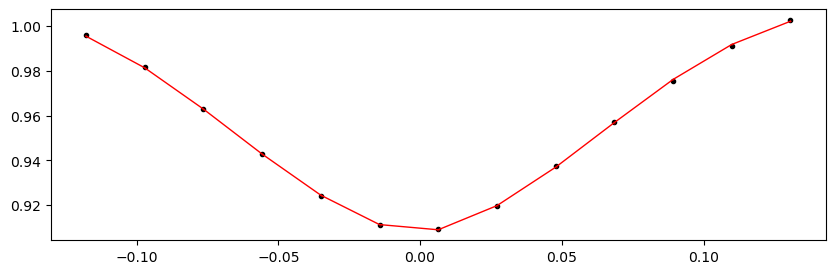

2147.9739689 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.72it/s]


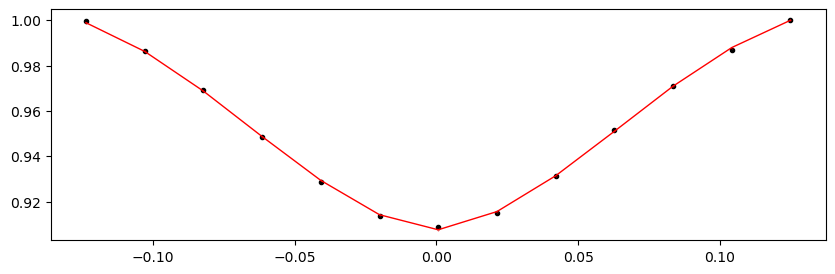

2148.30923945 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.08it/s]


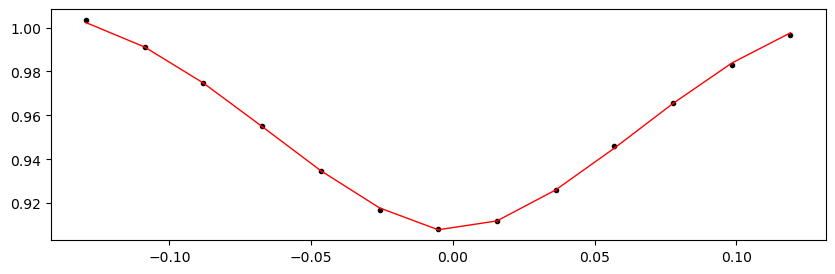

2148.64451 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.25it/s]


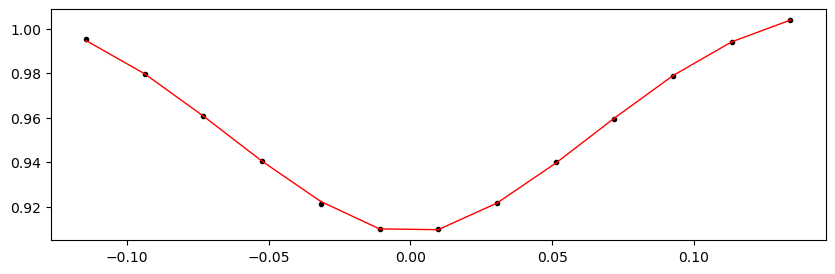

2148.9797805499998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.28it/s]


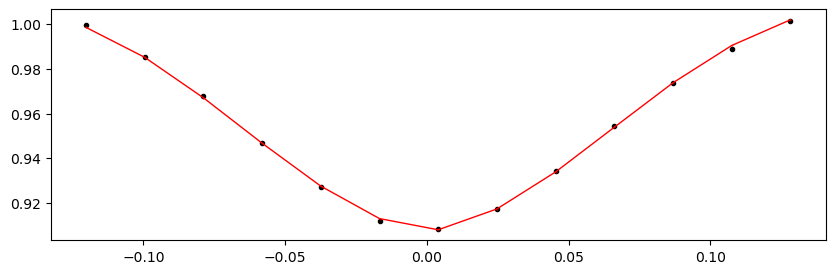

2149.3150511 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.04it/s]


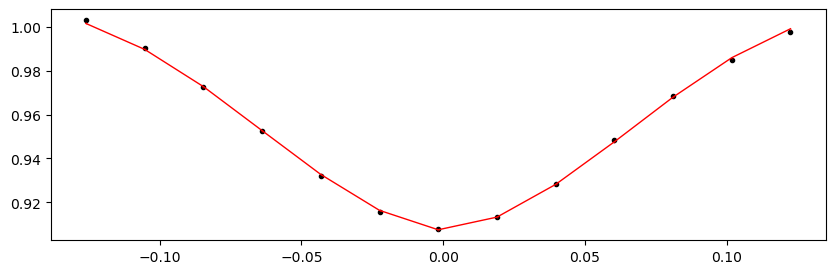

2149.65032165 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 427.05it/s]


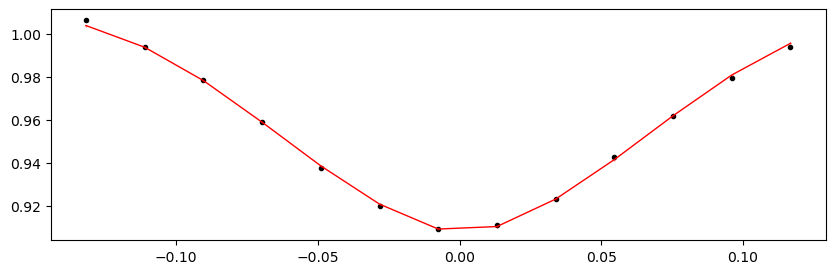

2149.9855921999997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.14it/s]


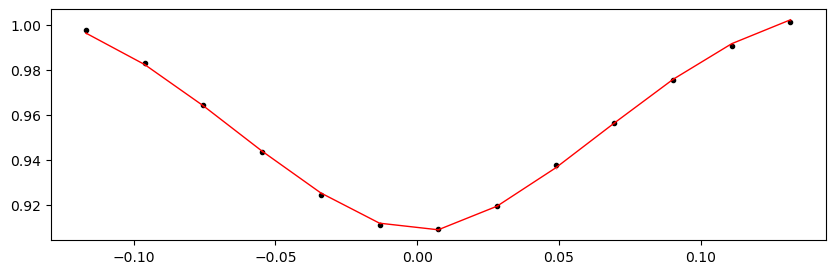

2150.32086275 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.51it/s]


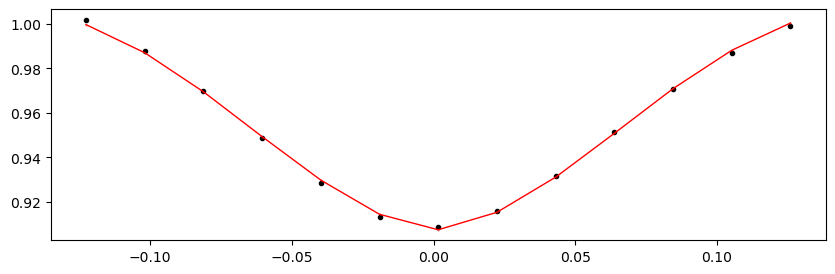

2150.6561333 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.61it/s]


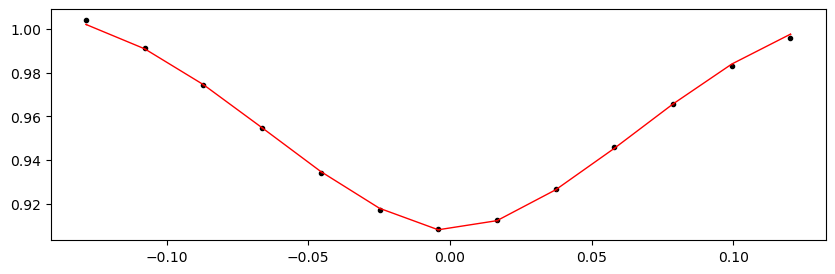

2150.99140385 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.77it/s]


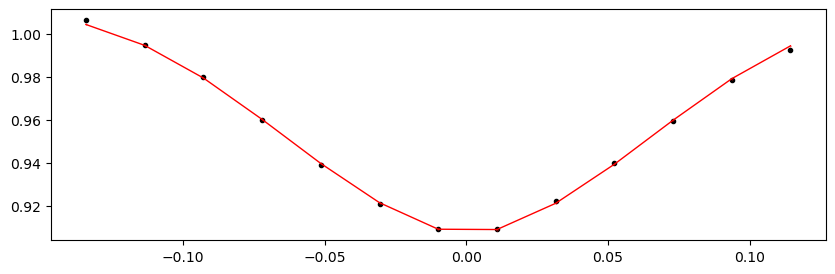

2151.3266744 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 437.42it/s]


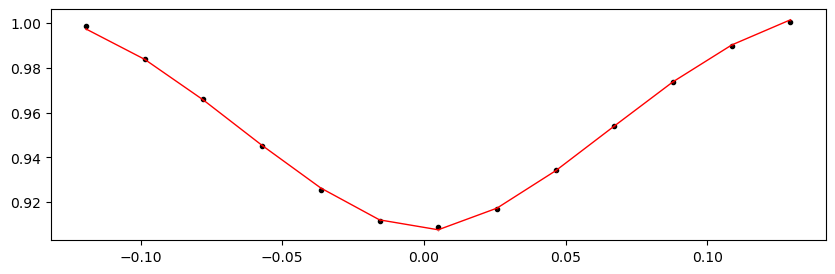

2151.66194495 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.20it/s]


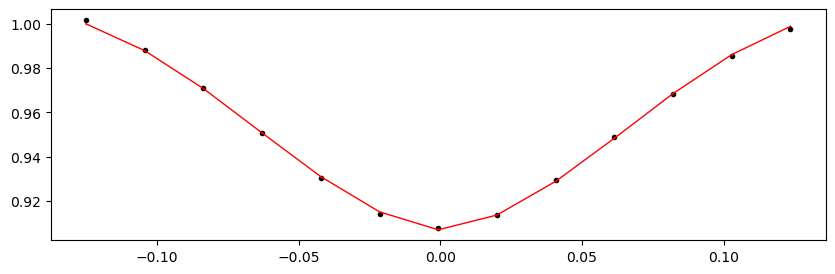

2151.9972155 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.23it/s]


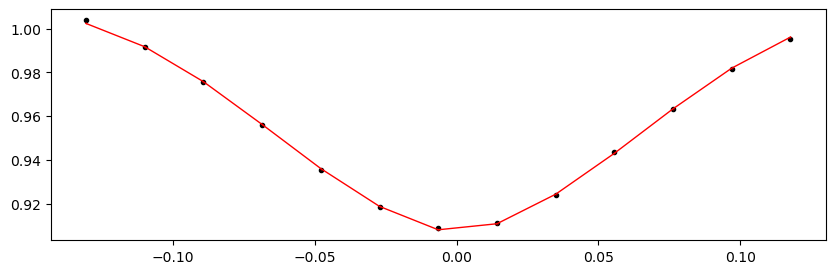

2152.3324860499997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.66it/s]


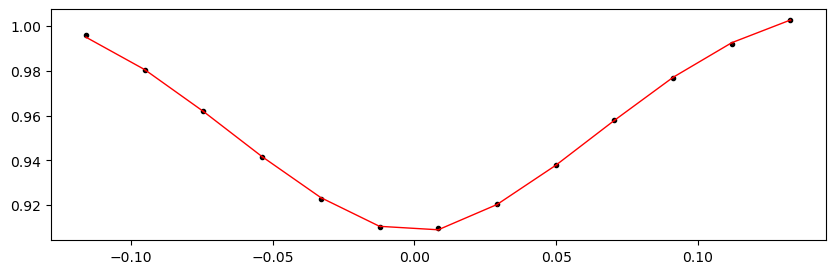

2152.6677566 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.80it/s]


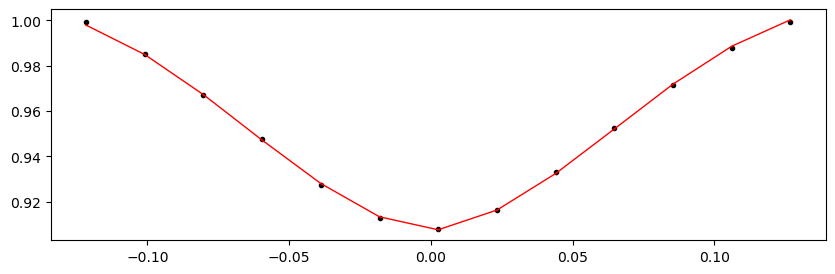

2153.00302715 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.98it/s]


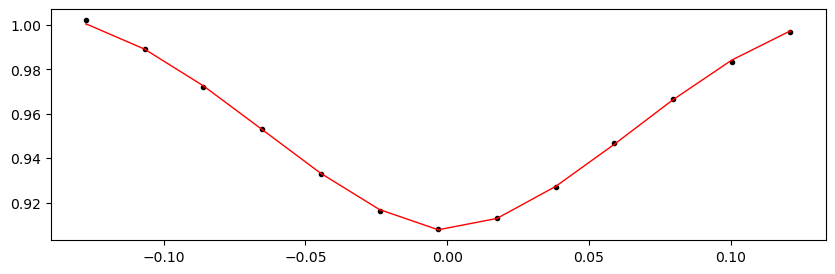

2153.3382977 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.25it/s]


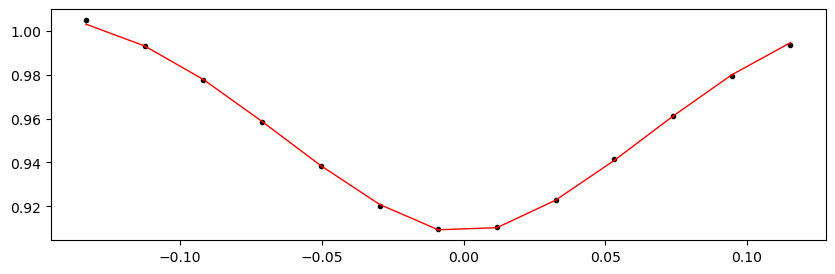

2153.67356825 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.75it/s]


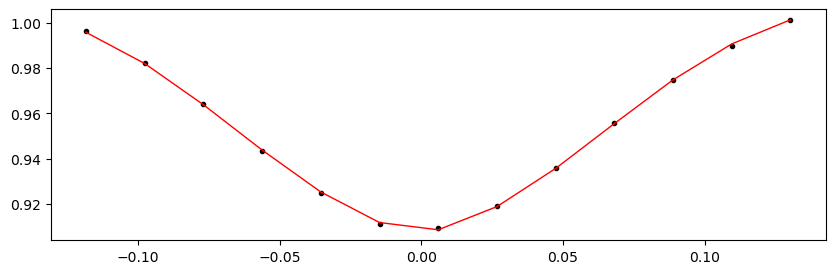

2154.0088388 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 428.06it/s]


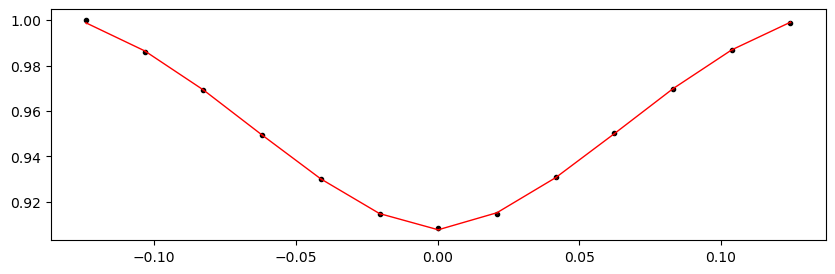

2154.34410935 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.98it/s]


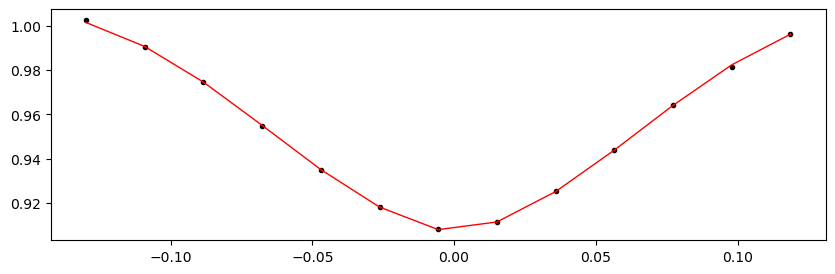

2154.6793798999997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 404.63it/s]


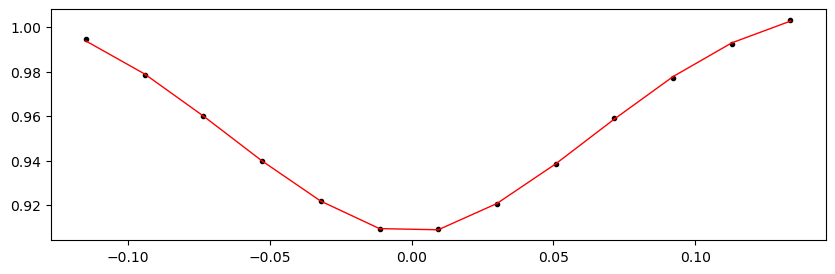

2155.01465045 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.93it/s]


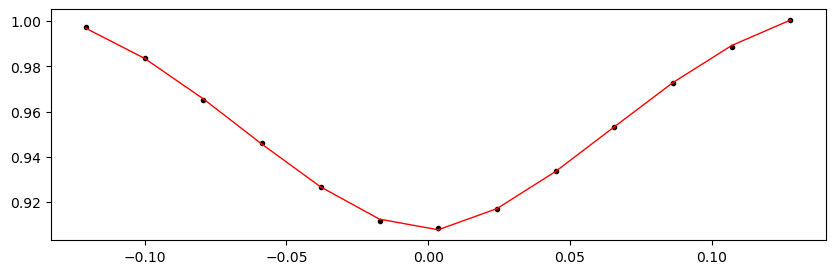

2155.349921 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.74it/s]


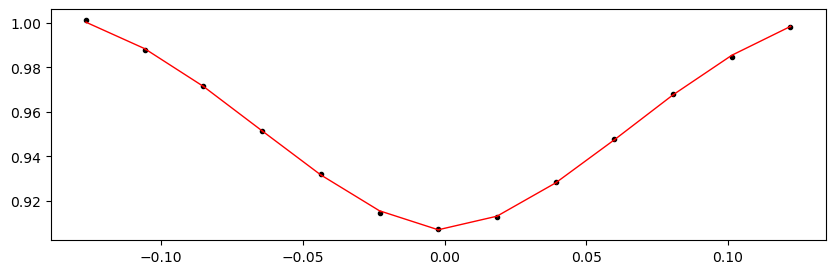

2155.68519155 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 405.80it/s]


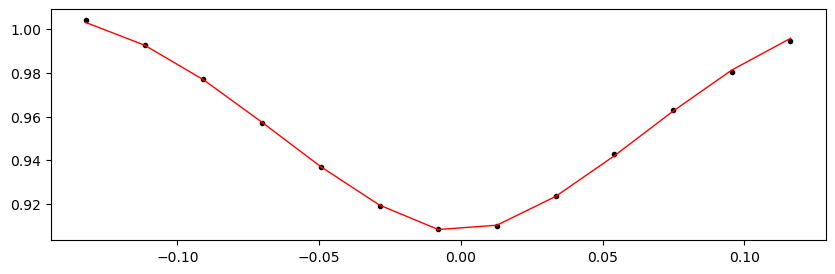

2159.0378970499996 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.95it/s]


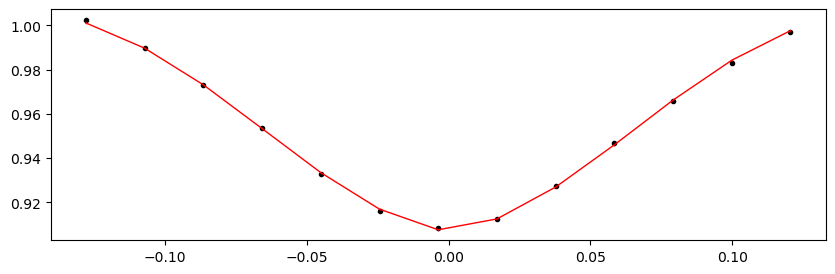

2159.3731675999998 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.84it/s]


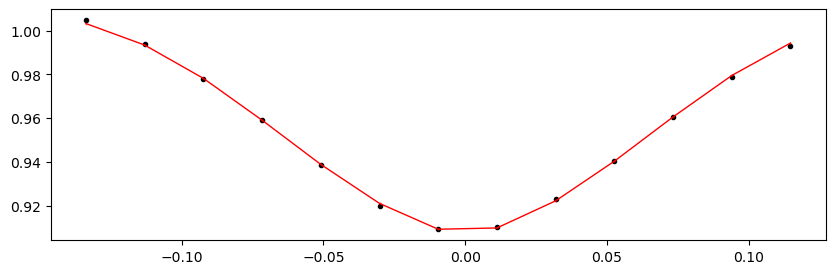

2159.70843815 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.24it/s]


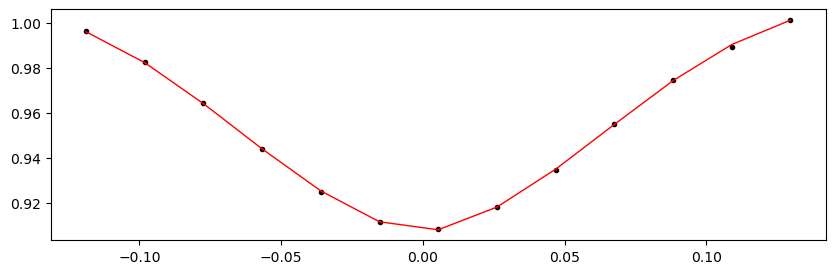

2160.0437087 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.13it/s]


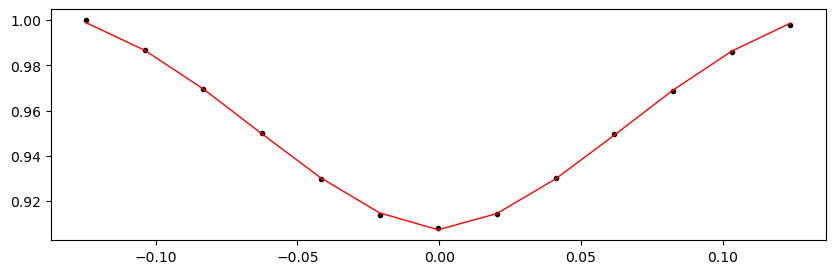

2160.37897925 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.01it/s]


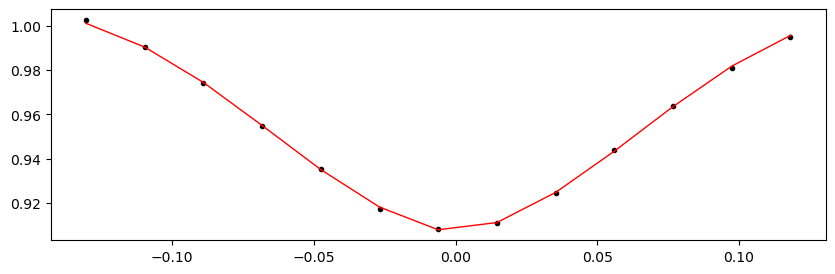

2160.7142498 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.58it/s]


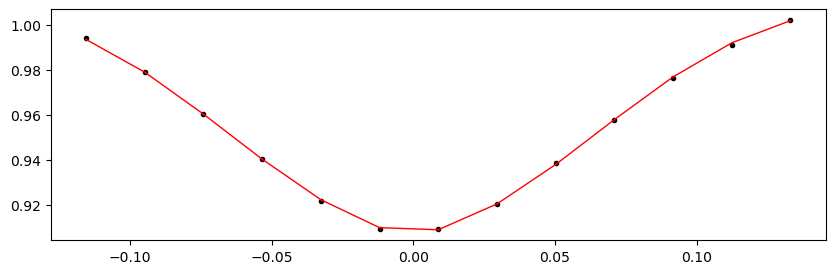

2161.04952035 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.81it/s]


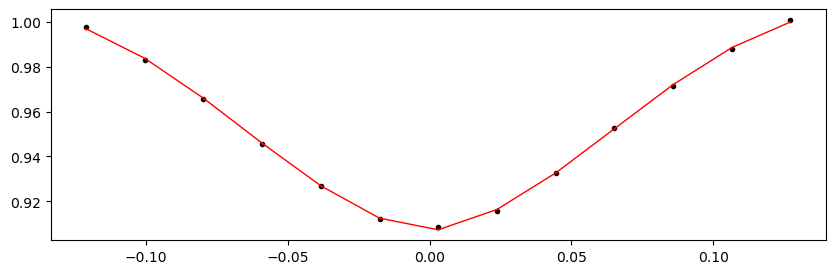

2161.3847908999996 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.16it/s]


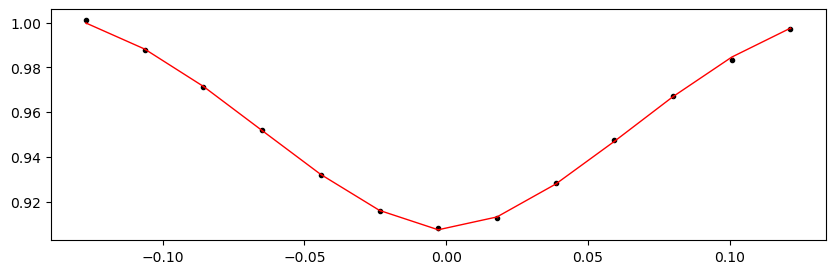

2161.72006145 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.99it/s]


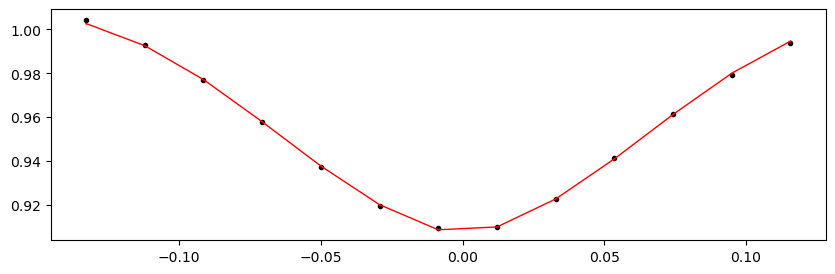

2162.055332 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.17it/s]


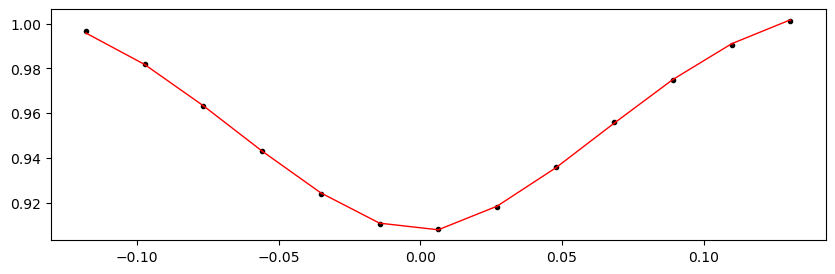

2162.39060255 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.92it/s]


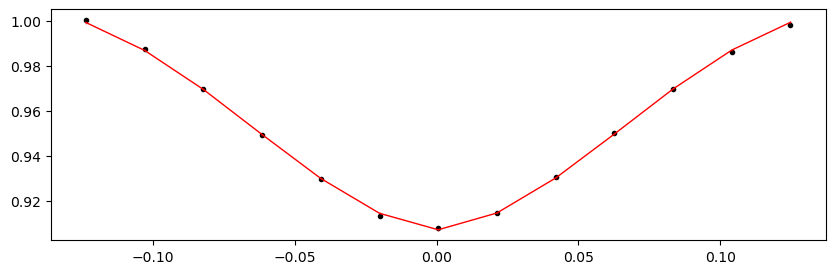

2162.7258731 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.13it/s]


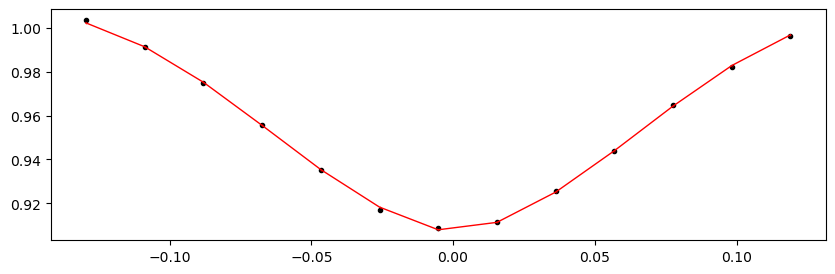

2163.06114365 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.69it/s]


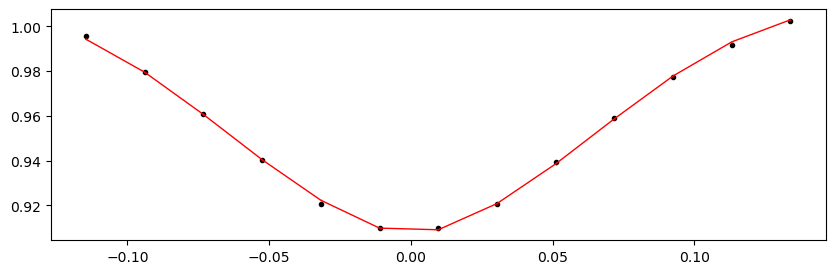

2163.3964142 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.11it/s]


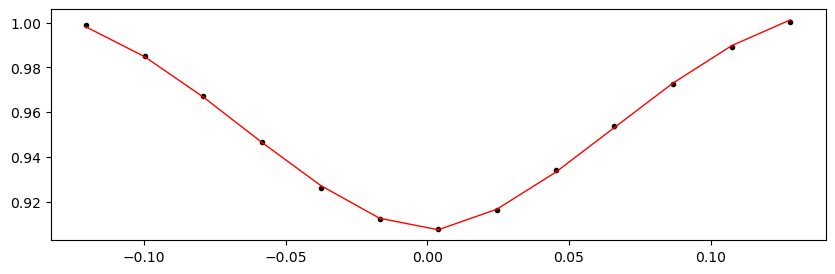

2163.7316847499997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.43it/s]


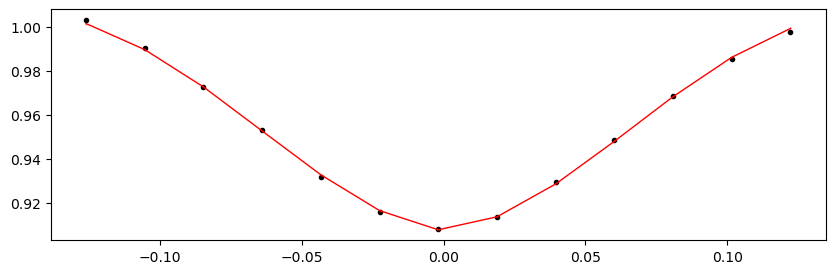

2164.0669553 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.30it/s]


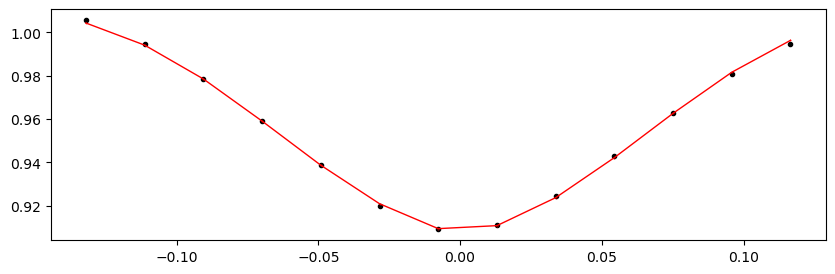

2164.40222585 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.13it/s]


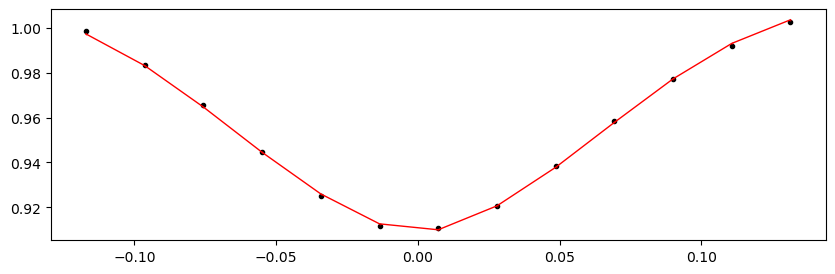

2164.7374964 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.39it/s]


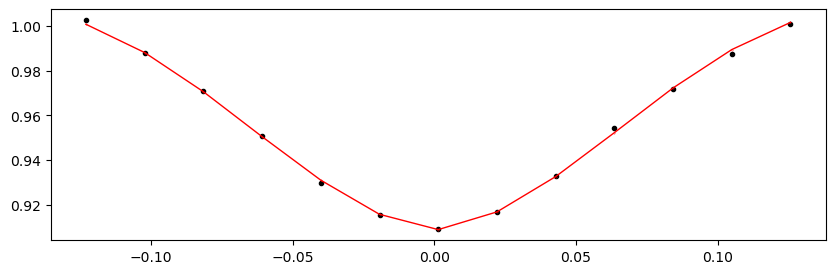

2165.07276695 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.56it/s]


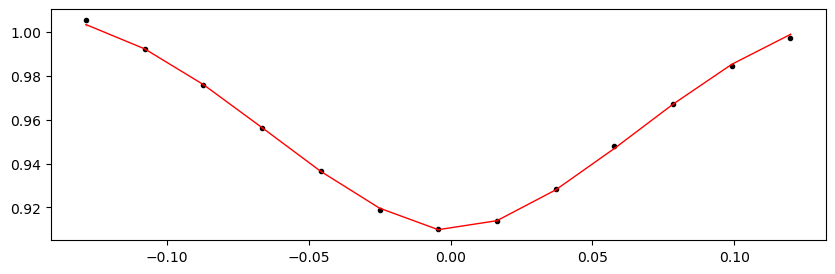

Time 2165.4080375 does not have enough data points: 8
2165.74330805 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.96it/s]


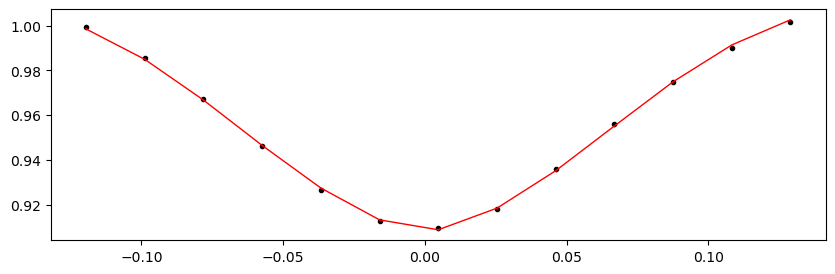

2166.0785785999997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.60it/s]


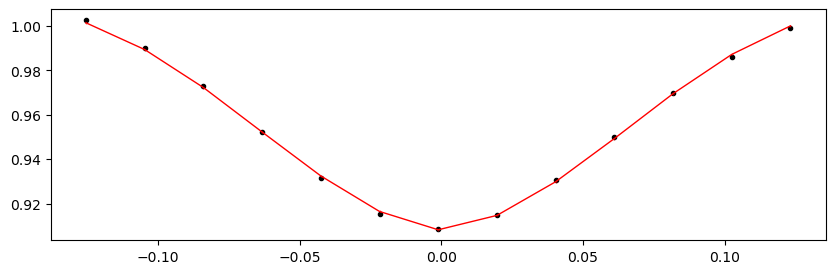

2166.41384915 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.65it/s]


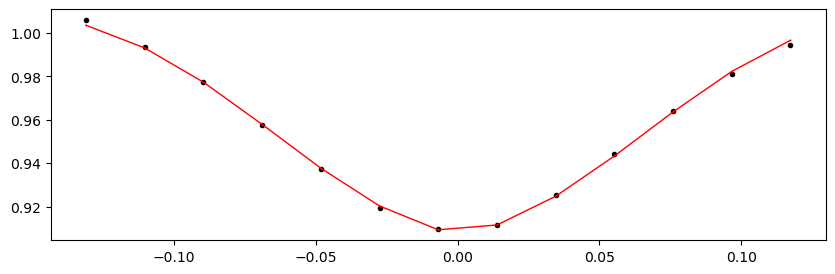

2166.7491197 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.29it/s]


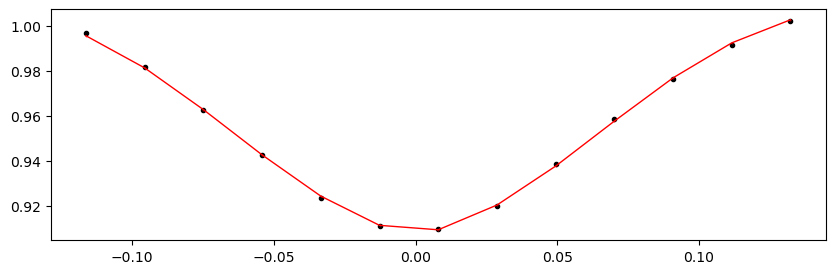

2167.08439025 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.04it/s]


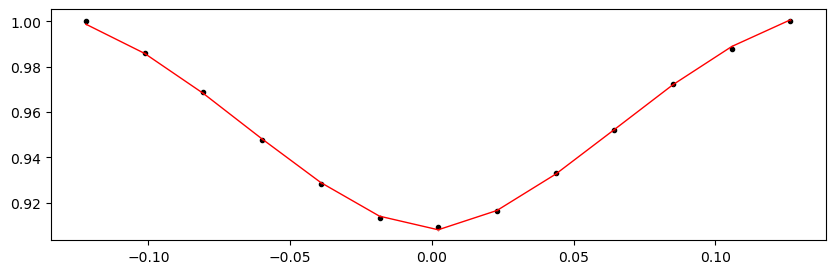

2167.4196607999997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.89it/s]


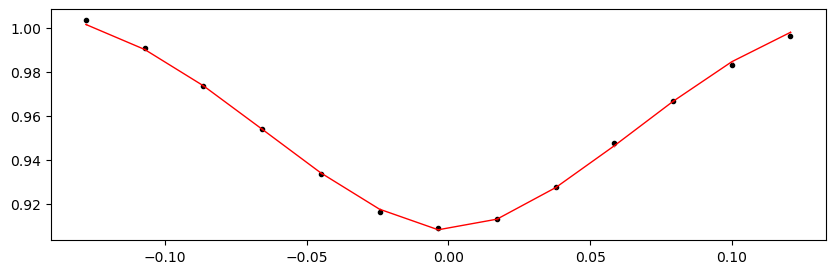

2167.75493135 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.57it/s]


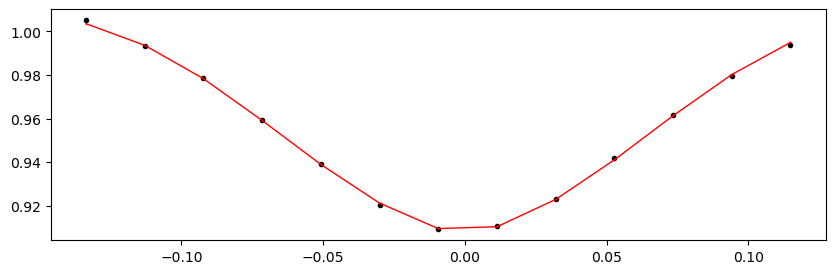

2168.0902019 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.01it/s]


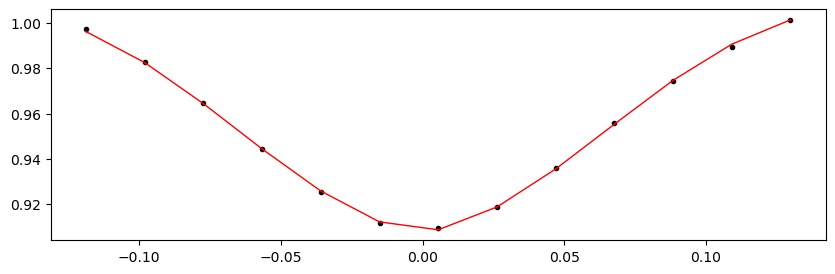

2168.4254724499997 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.25it/s]


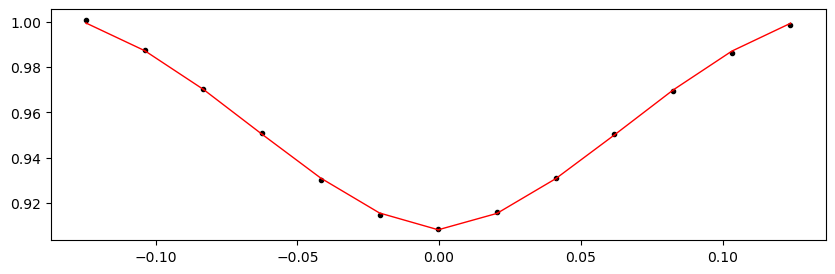

2168.760743 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.37it/s]


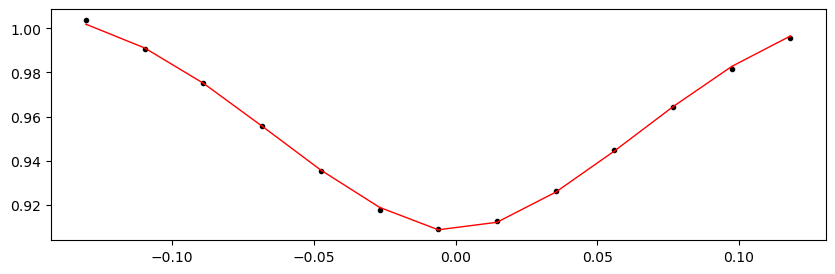

2169.09601355 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.61it/s]


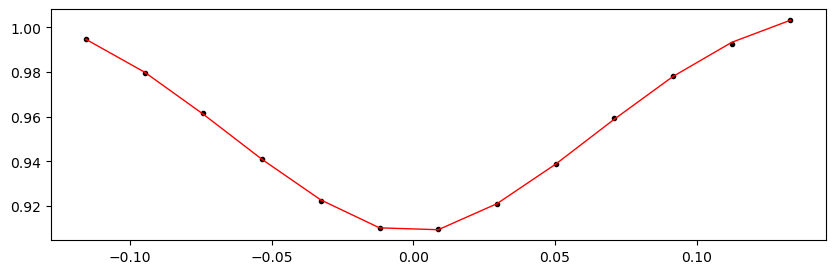

2169.4312841 1.010574014325437 -0.10327619383263976 0.22511935873892025


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.82it/s]


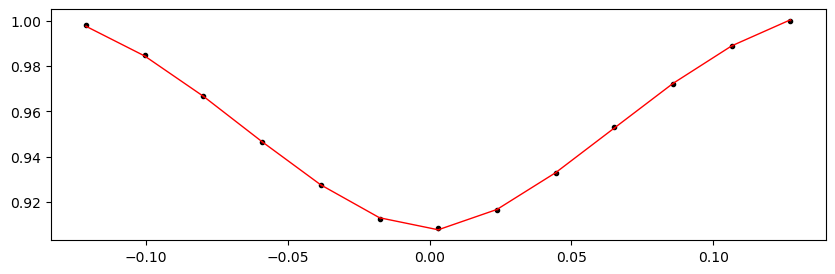

In [41]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=10,  # to handle 10 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"



Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
1411.887476375 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.85it/s]


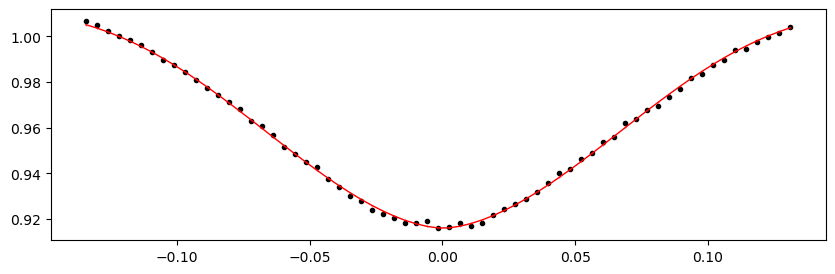

1412.222746925 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.90it/s]


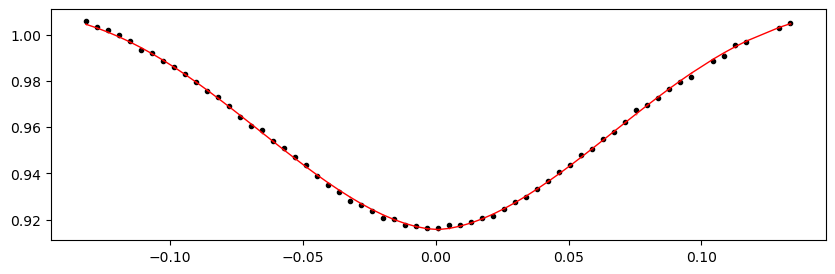

1412.558017475 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.29it/s]


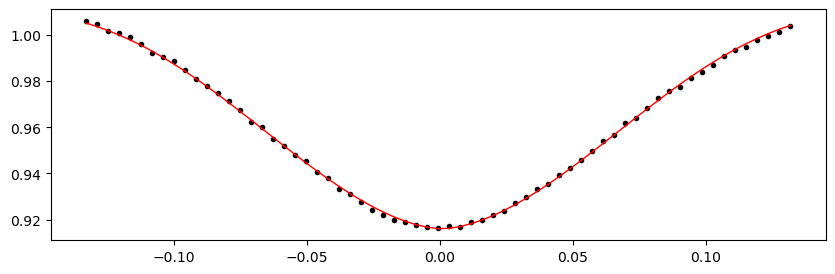

1412.893288025 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.27it/s]


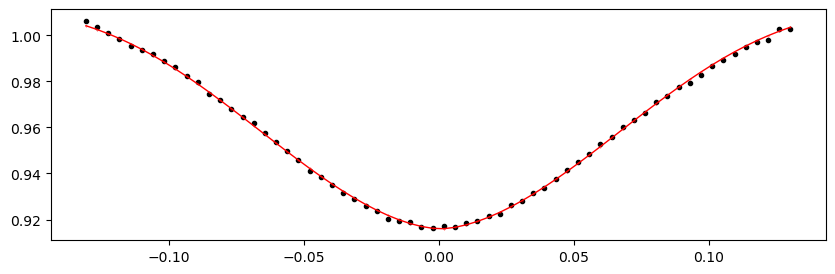

1413.228558575 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.57it/s]


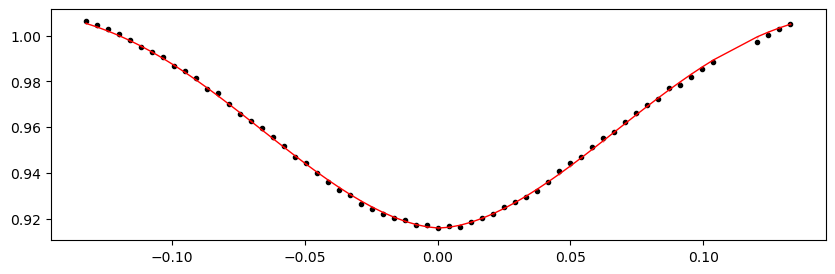

1413.563829125 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.27it/s]


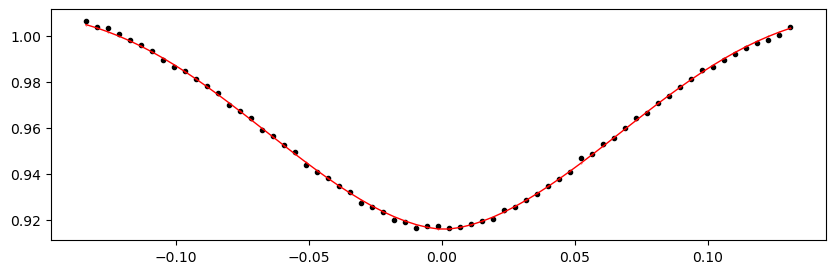

1413.899099675 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.87it/s]


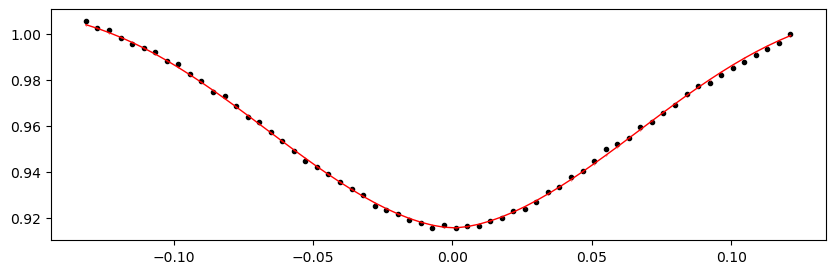

1414.234370225 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.31it/s]


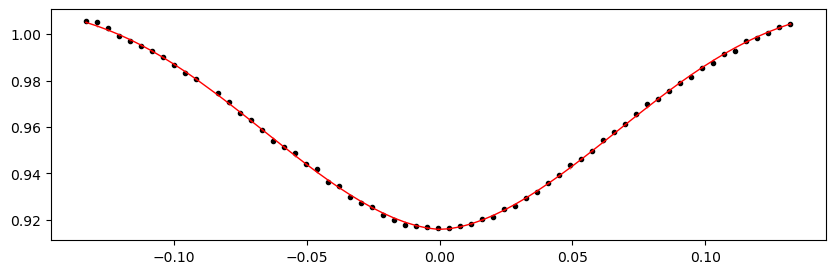

1414.569640775 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.01it/s]


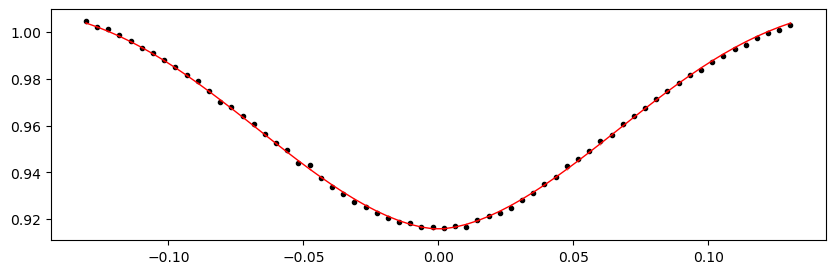

1414.904911325 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.54it/s]


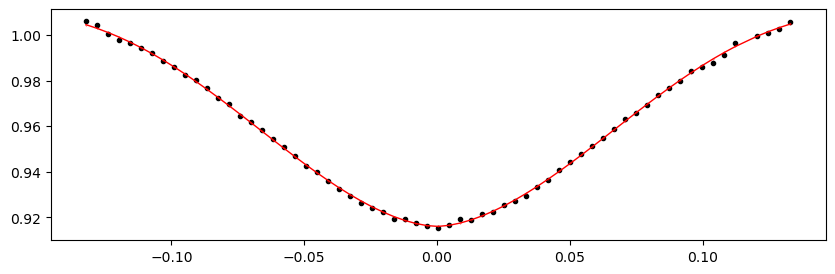

1415.240181875 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.93it/s]


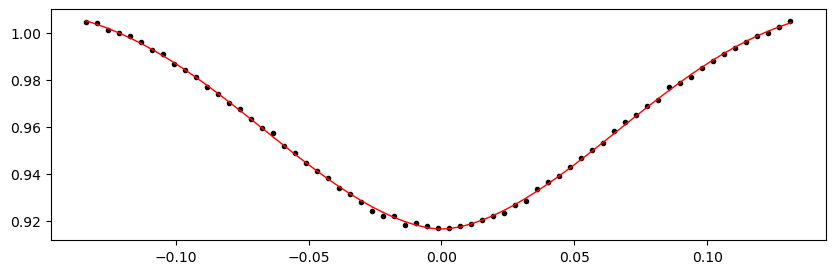

1415.5754524249999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.92it/s]


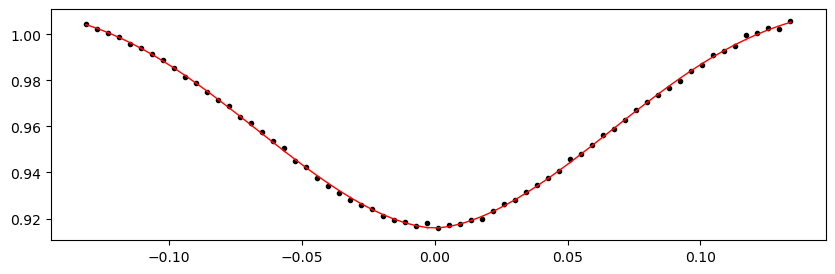

1415.910722975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.36it/s]


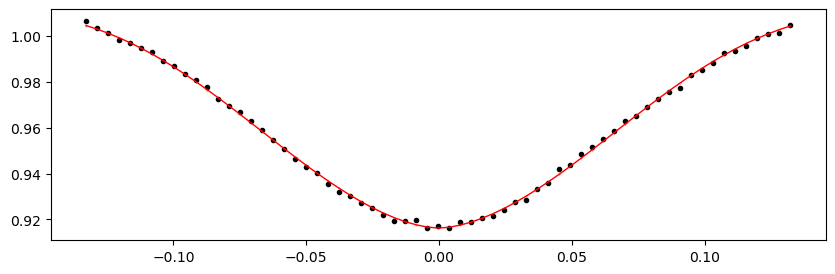

1416.245993525 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.28it/s]


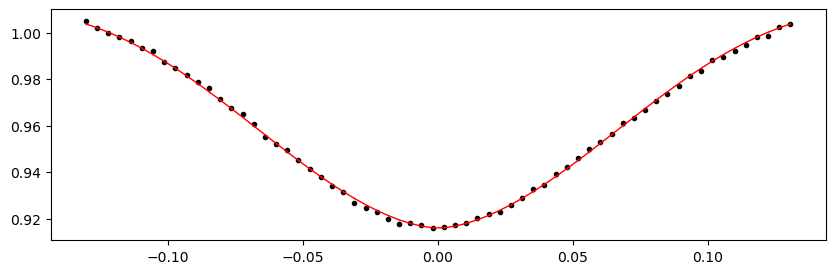

1416.581264075 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.08it/s]


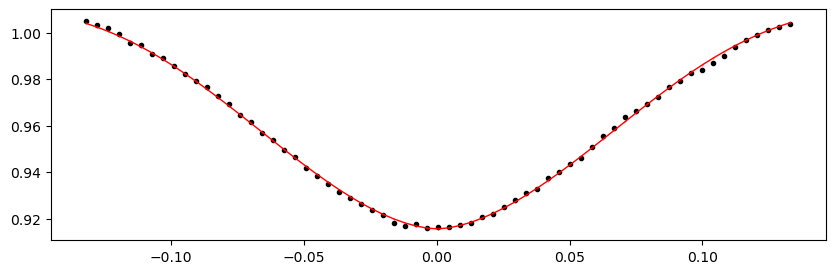

1416.916534625 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.89it/s]


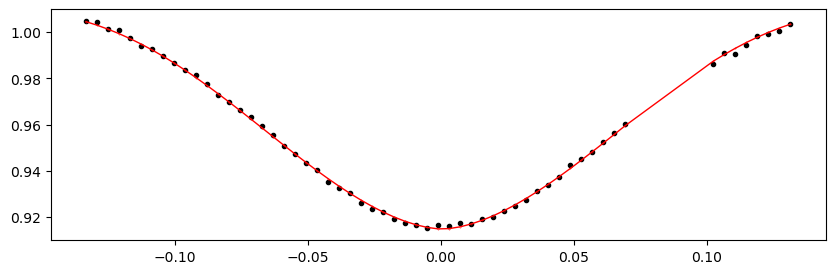

1417.251805175 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.31it/s]


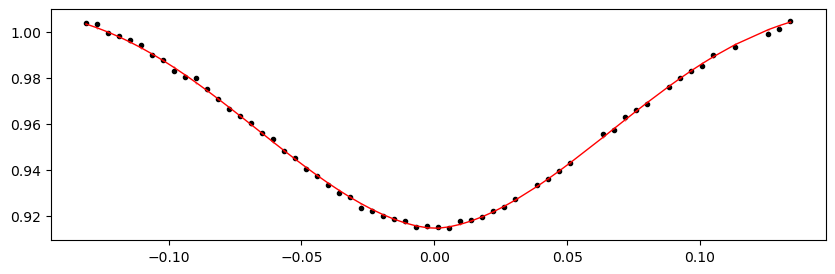

1417.587075725 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.81it/s]


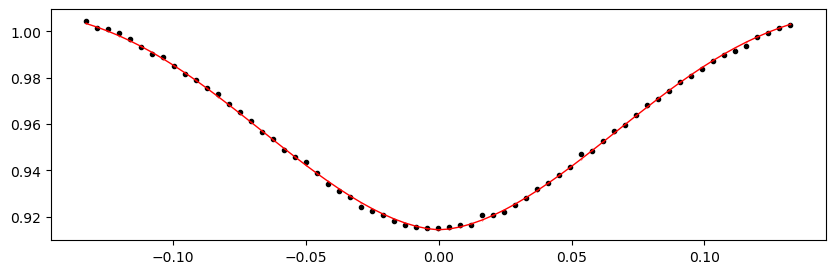

1417.9223462749999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.24it/s]


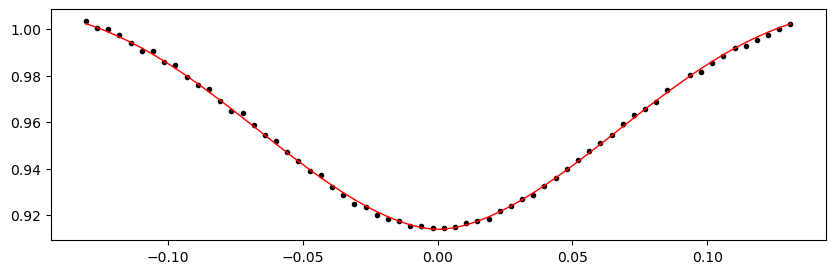

1418.257616825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.16it/s]


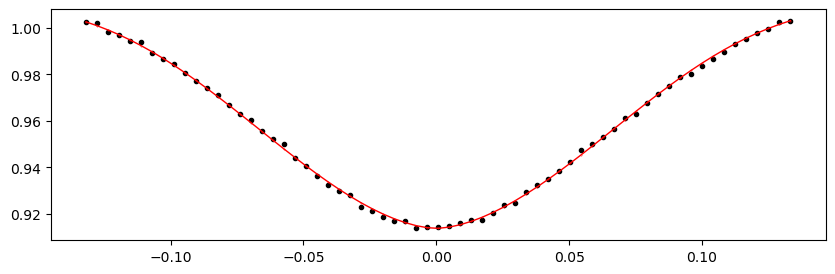

1421.275051775 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.62it/s]


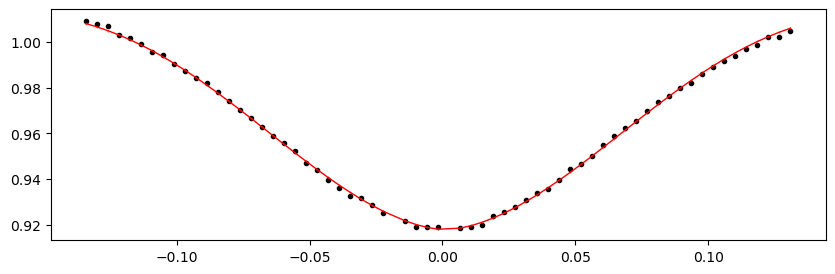

1421.610322325 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.39it/s]


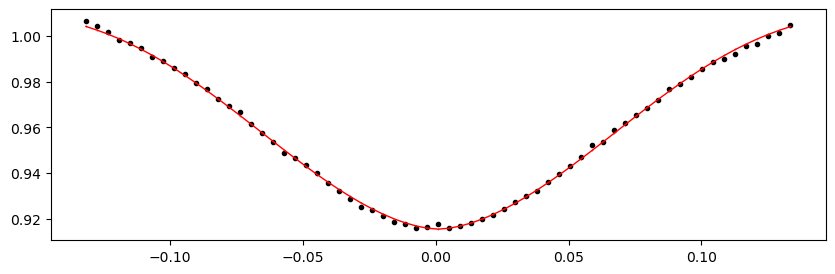

1421.9455928749999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.89it/s]


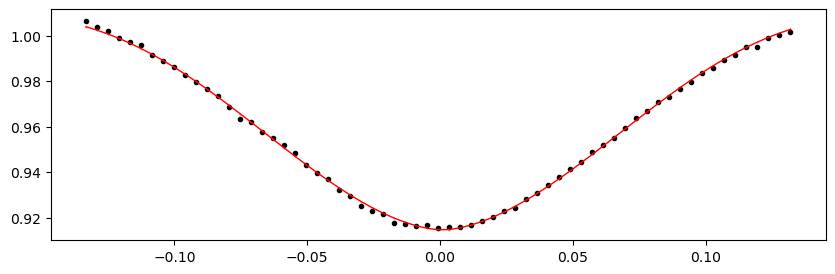

1422.280863425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.59it/s]


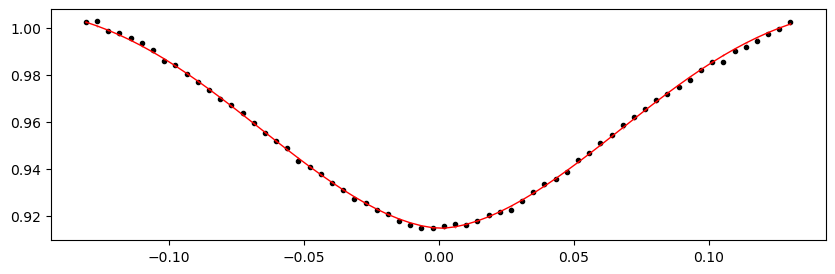

1424.627757275 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.85it/s]


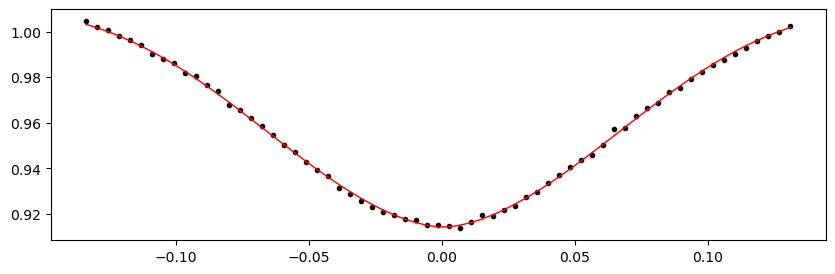

1424.963027825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.63it/s]


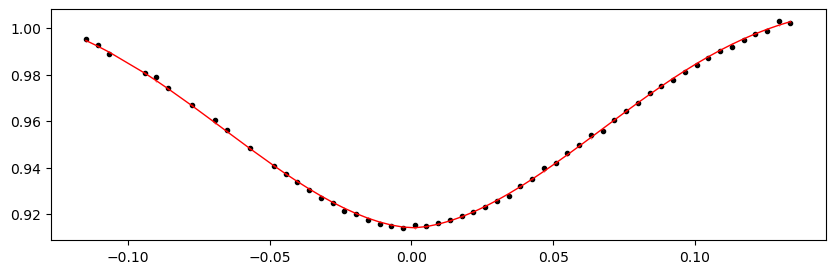

1425.298298375 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.79it/s]


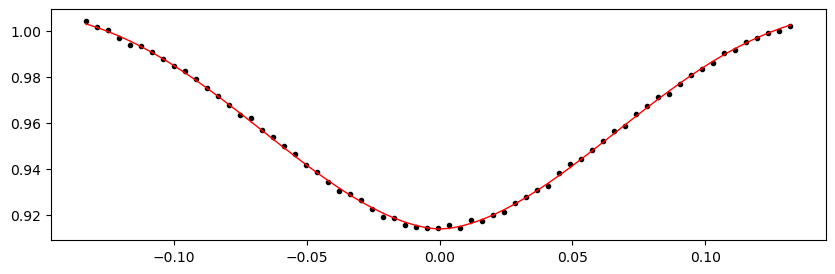

1425.633568925 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.42it/s]


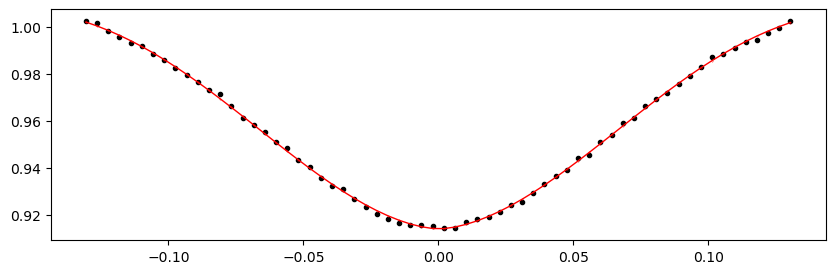

1425.9688394749999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.49it/s]


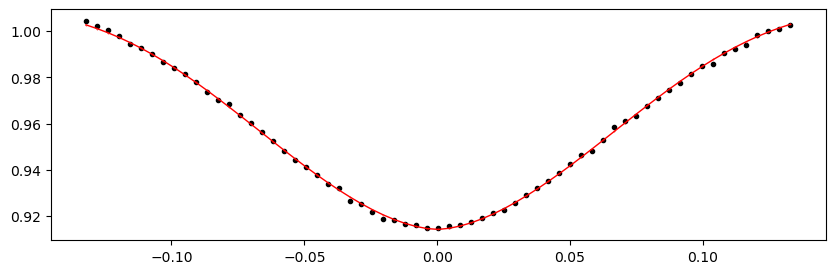

1426.304110025 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.18it/s]


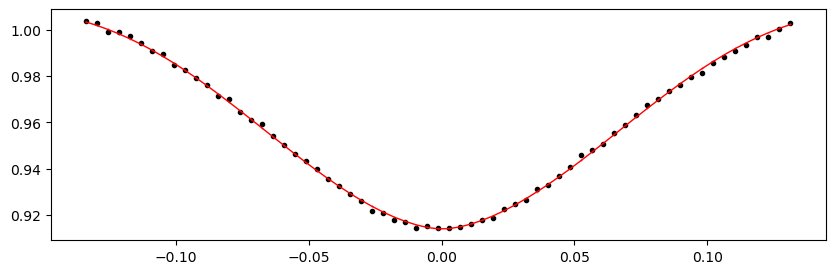

1426.639380575 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.62it/s]


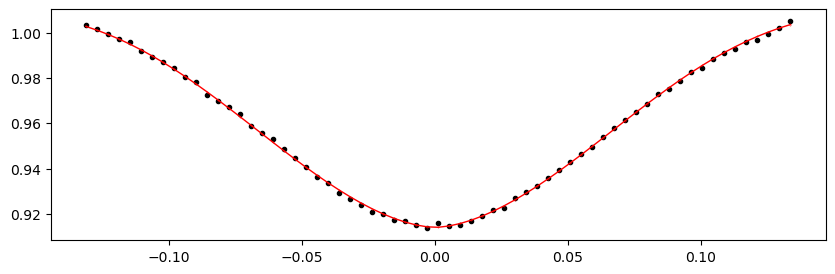

1426.974651125 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.58it/s]


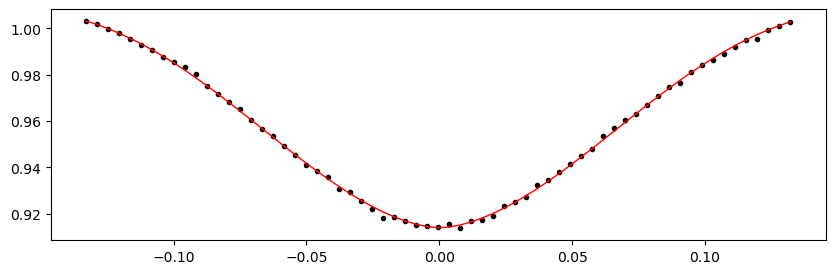

1427.309921675 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.67it/s]


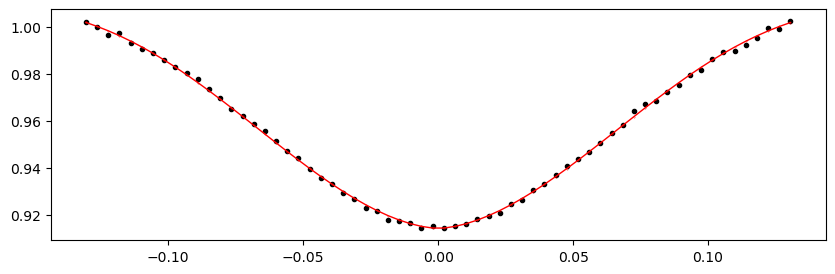

1427.645192225 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.58it/s]


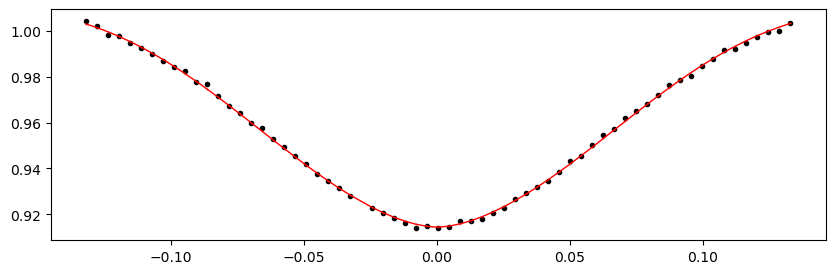

1427.980462775 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.44it/s]


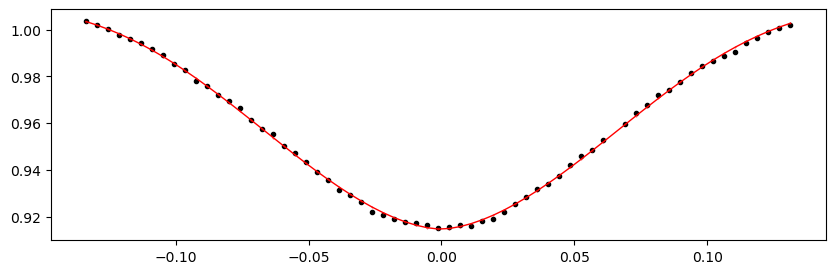

1428.3157333249999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.64it/s]


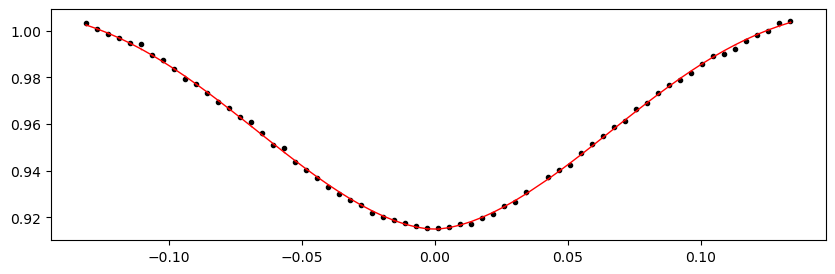

1428.651003875 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.36it/s]


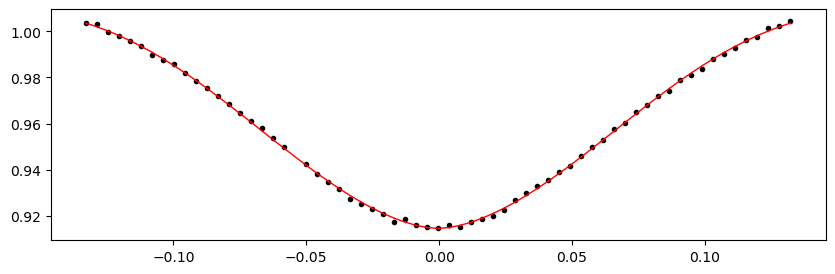

1428.986274425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.56it/s]


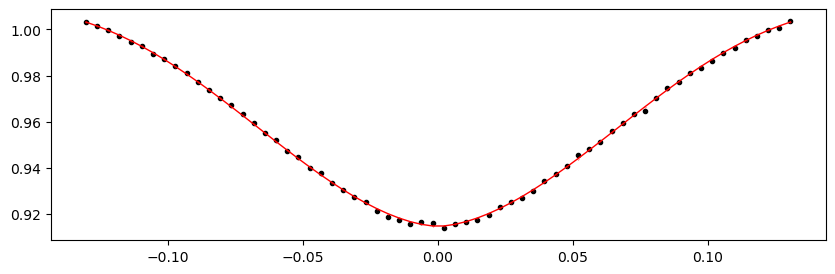

1429.321544975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.52it/s]


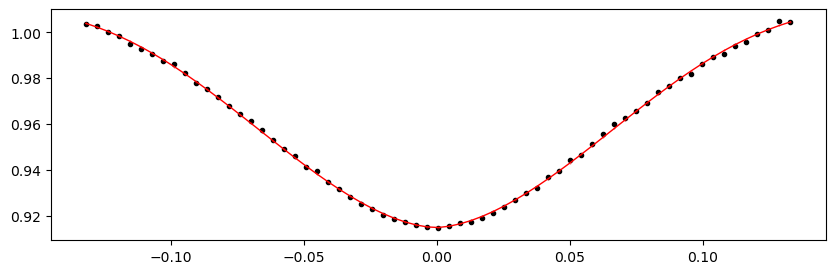

1429.656815525 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.11it/s]


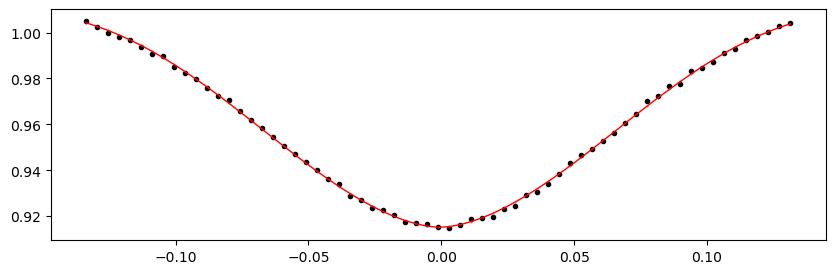

1429.9920860749999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.90it/s]


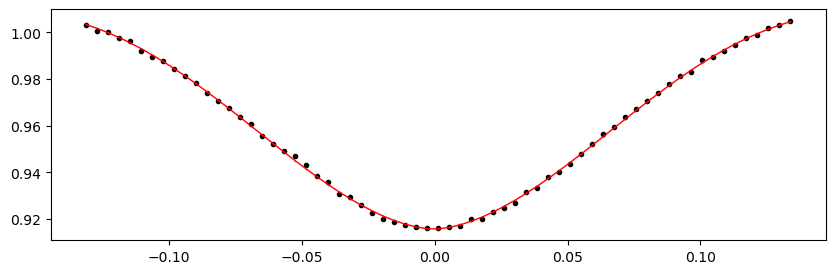

1430.327356625 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.28it/s]


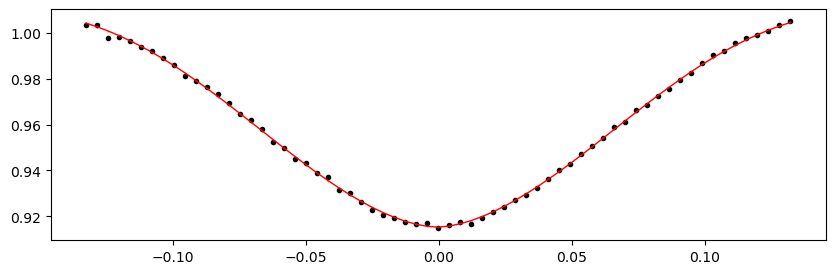

1430.662627175 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.45it/s]


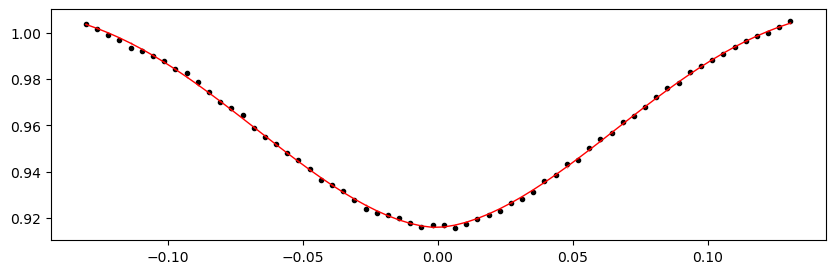

1430.997897725 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.51it/s]


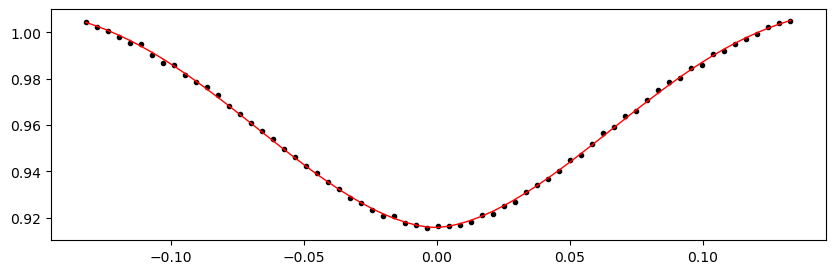

1431.333168275 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.77it/s]


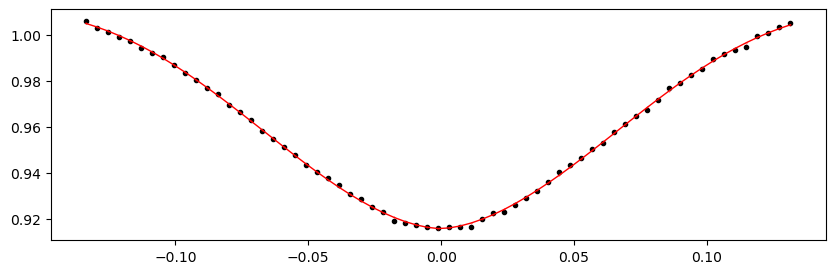

1431.668438825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.77it/s]


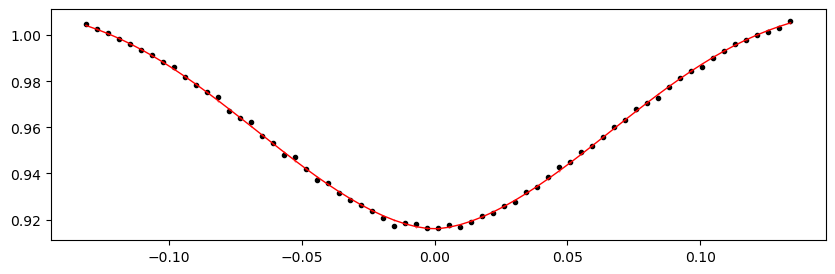

1432.003709375 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.19it/s]


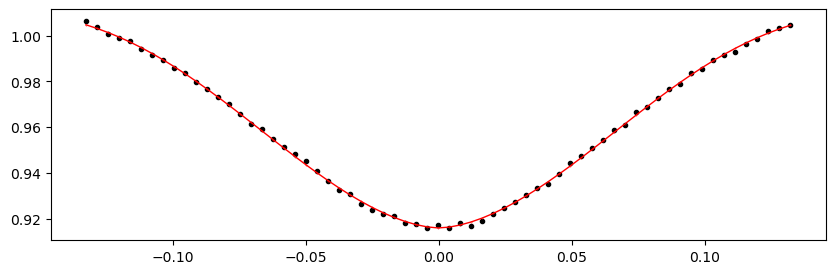

1432.3389799249999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.58it/s]


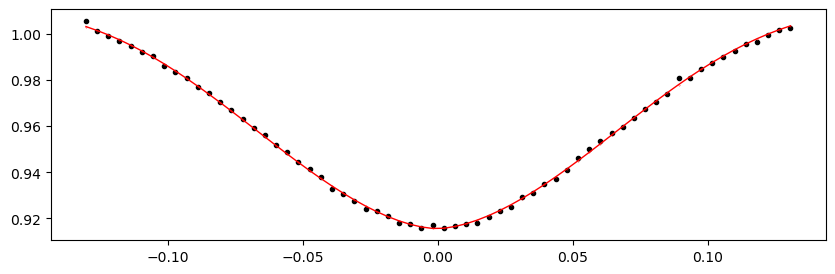

1432.674250475 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.31it/s]


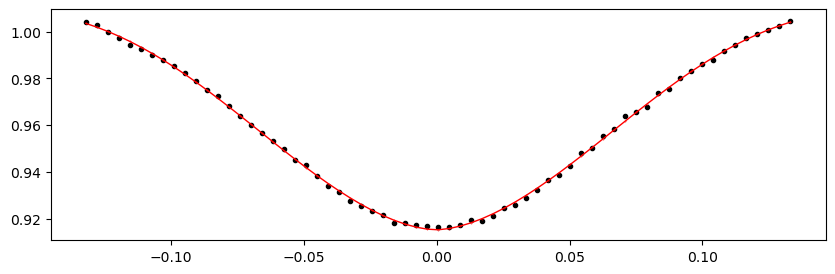

1433.009521025 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.20it/s]


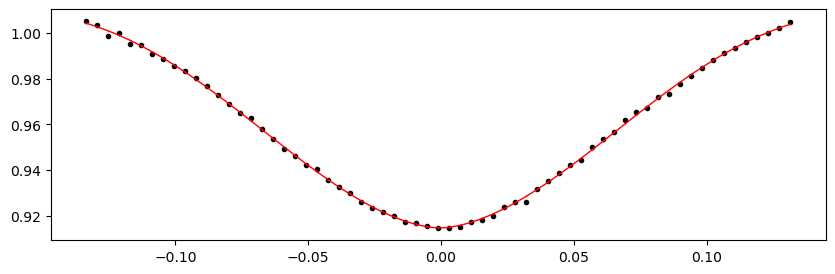

1433.344791575 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.91it/s]


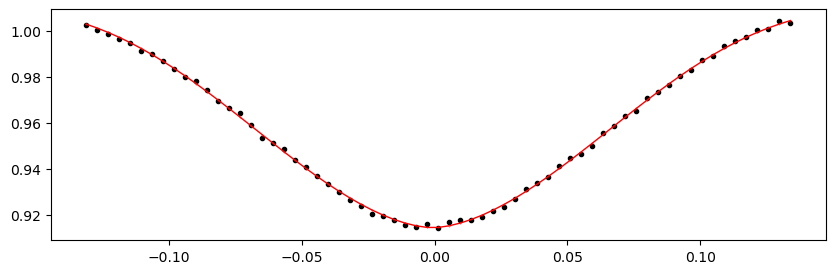

1433.680062125 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.28it/s]


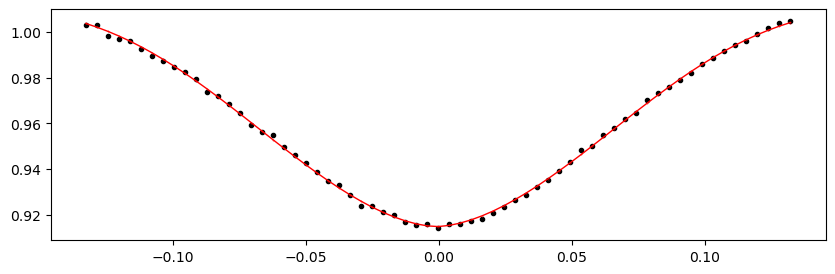

1434.015332675 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.10it/s]


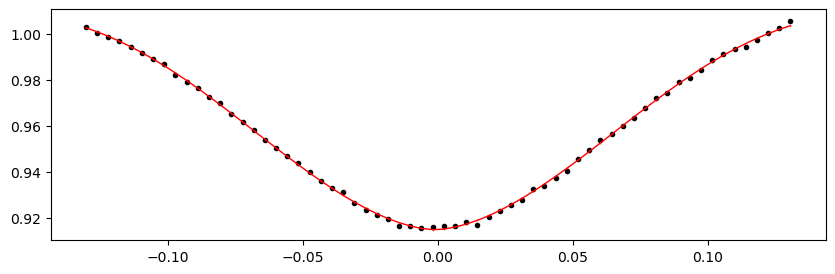

1434.350603225 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.19it/s]


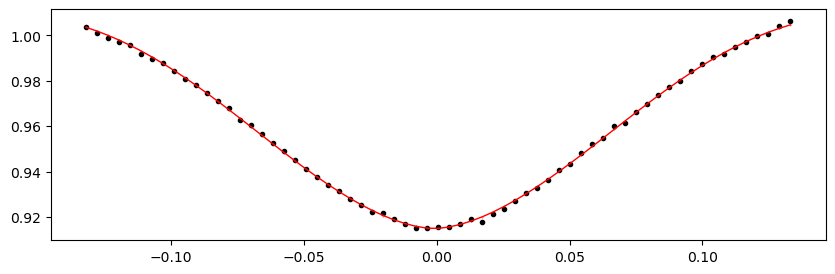

1434.685873775 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.73it/s]


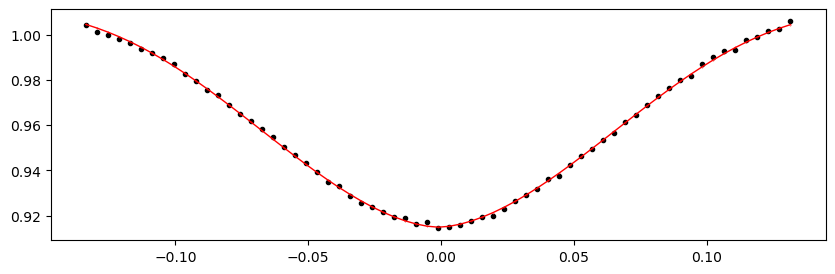

1435.021144325 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.52it/s]


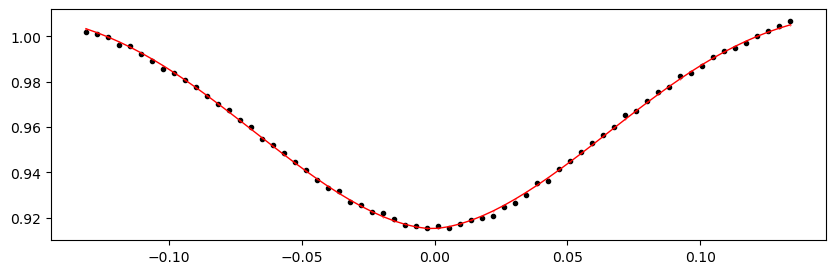

1435.356414875 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.38it/s]


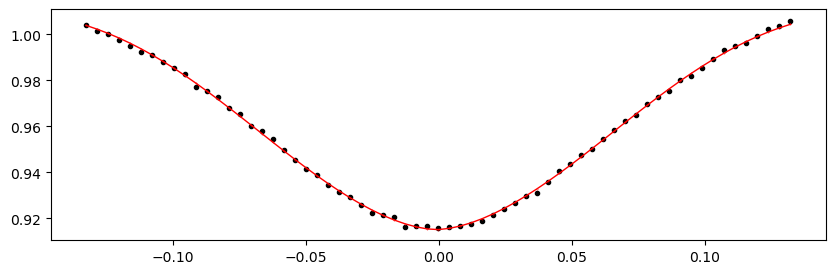

1435.691685425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.09it/s]


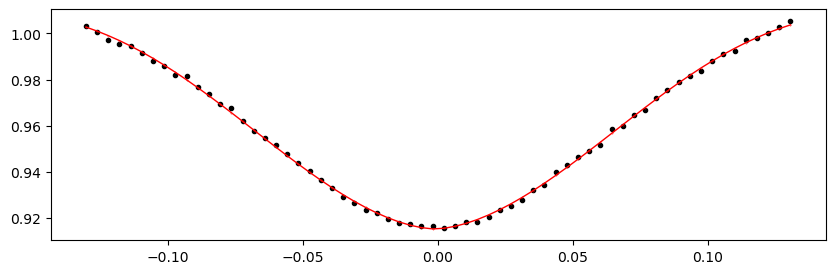

1436.026955975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.09it/s]


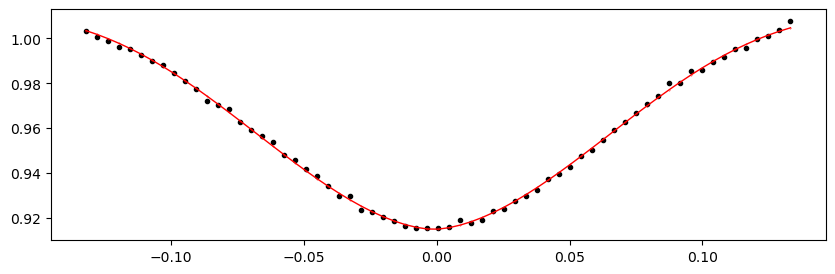

1436.3622265249999 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.84it/s]


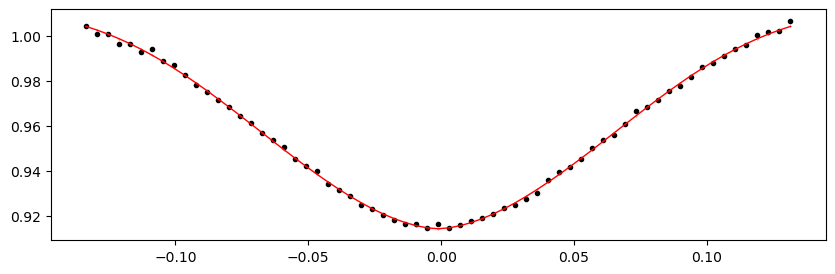

2144.788898675 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 441.79it/s]


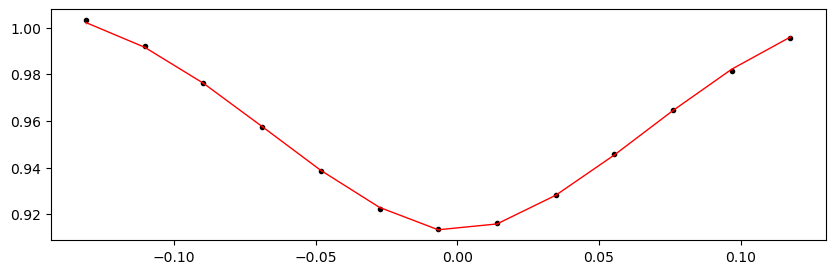

2145.124169225 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.39it/s]


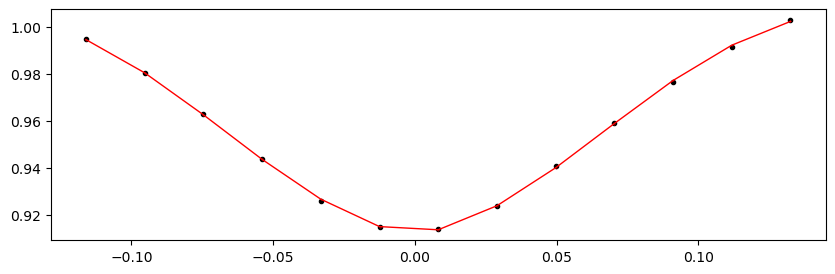

2145.4594397749997 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.36it/s]


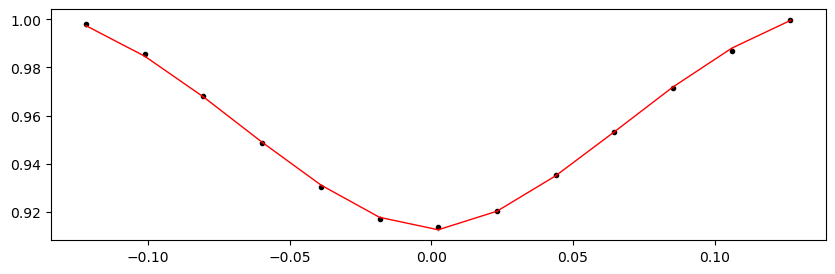

2145.794710325 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.12it/s]


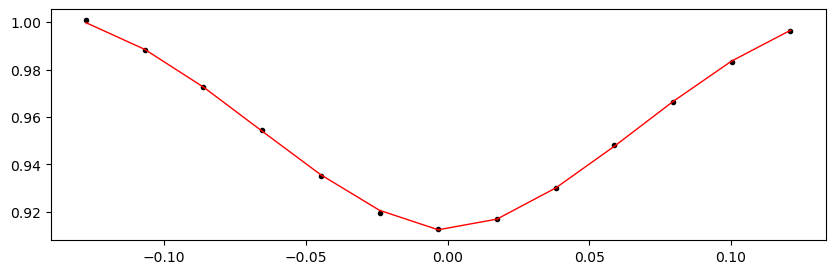

2146.129980875 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.13it/s]


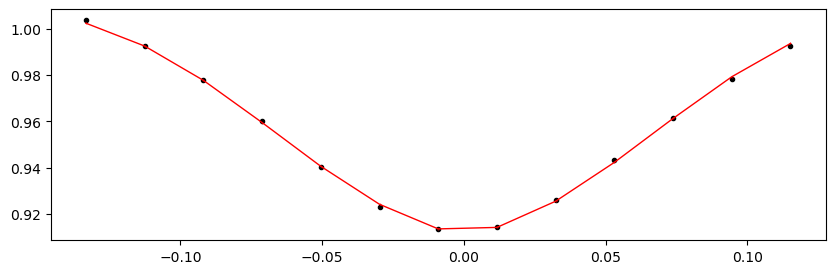

2146.465251425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.46it/s]


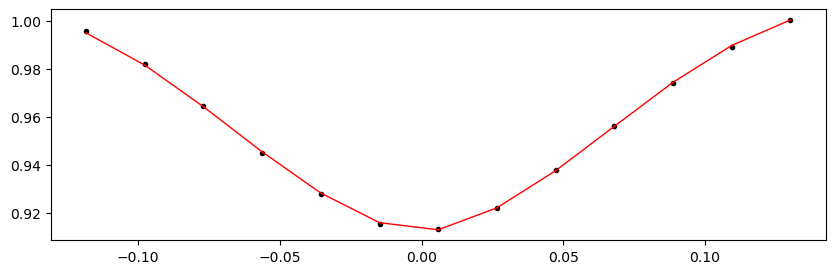

2146.800521975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.73it/s]


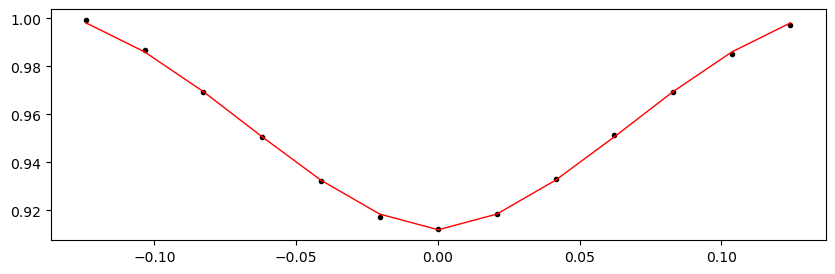

2147.135792525 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.09it/s]


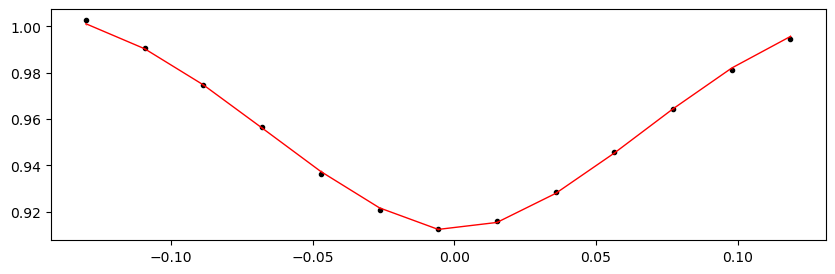

2147.471063075 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.18it/s]


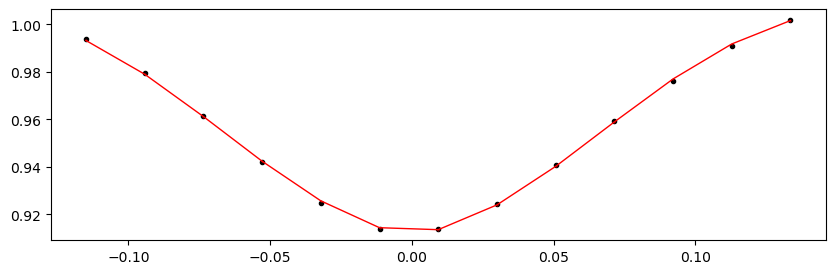

2147.8063336249998 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.03it/s]


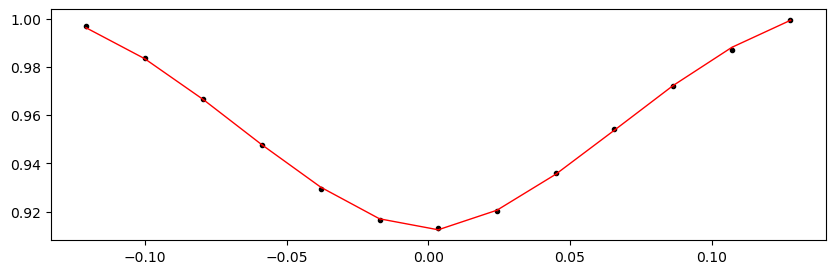

2148.141604175 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.10it/s]


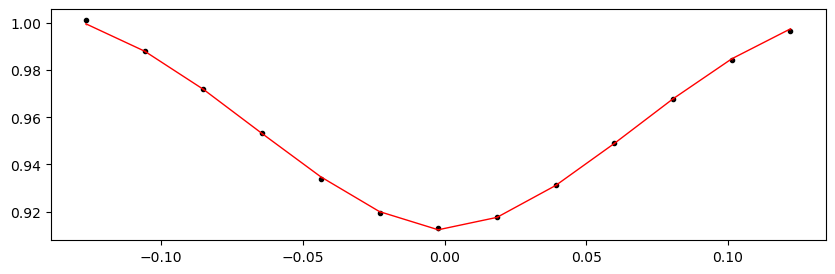

2148.476874725 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.92it/s]


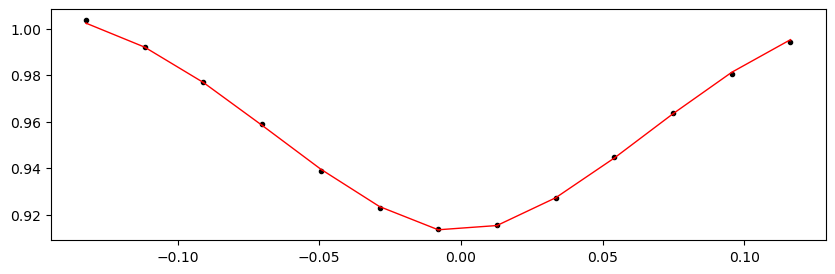

2148.812145275 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.42it/s]


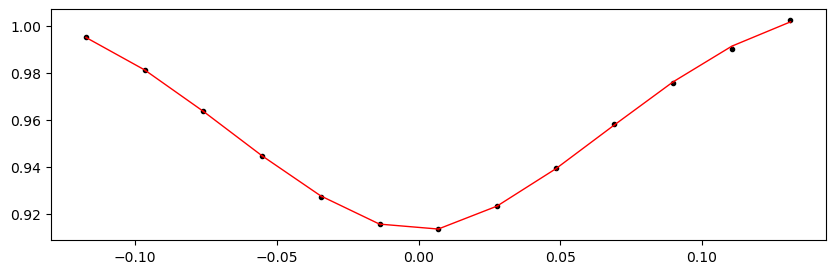

2149.147415825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.04it/s]


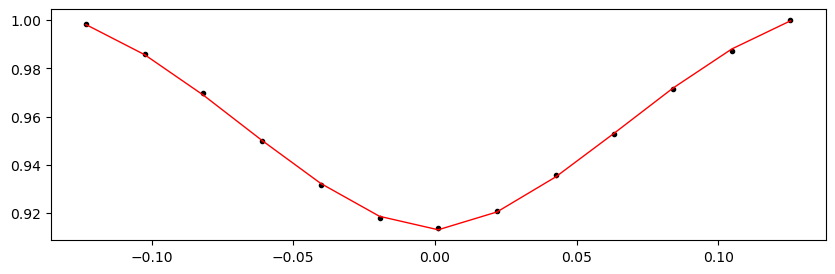

2149.482686375 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.08it/s]


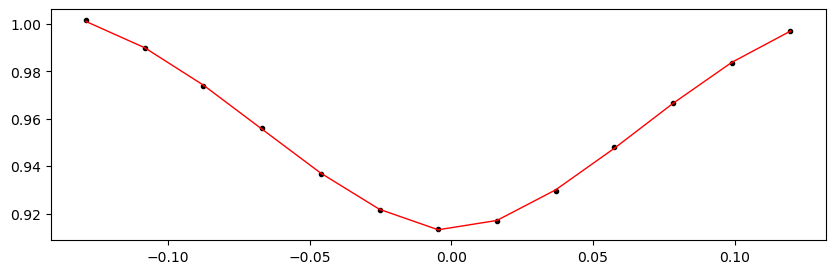

2149.817956925 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.23it/s]


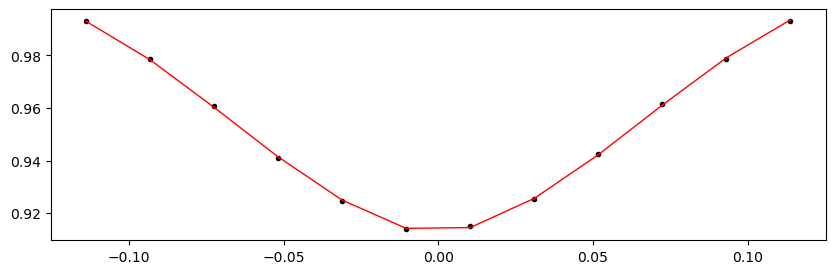

2150.1532274749998 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.77it/s]


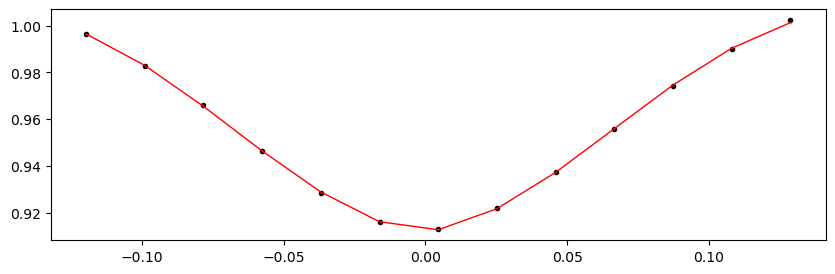

2150.488498025 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.88it/s]


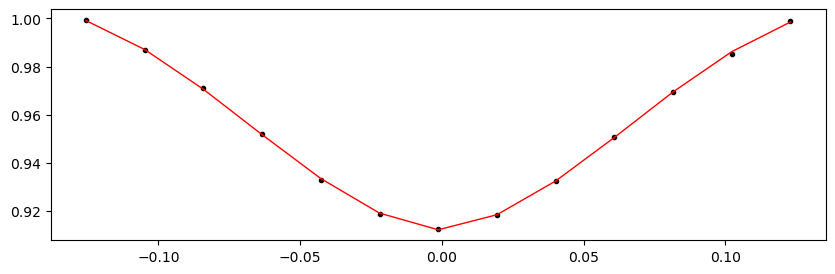

2150.823768575 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.15it/s]


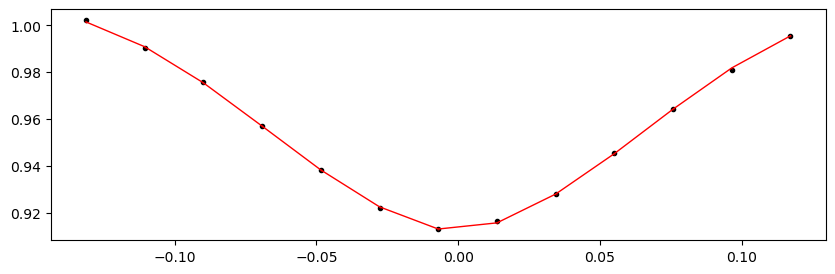

2151.159039125 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.02it/s]


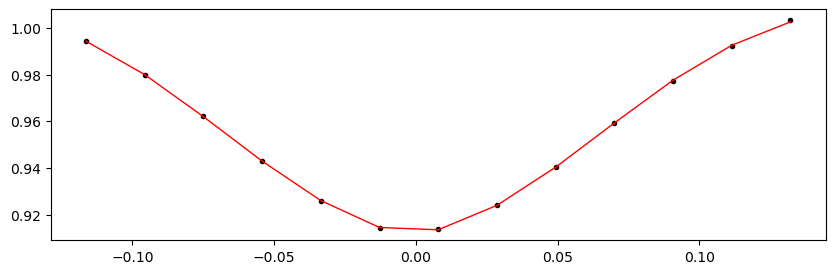

2151.494309675 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.67it/s]


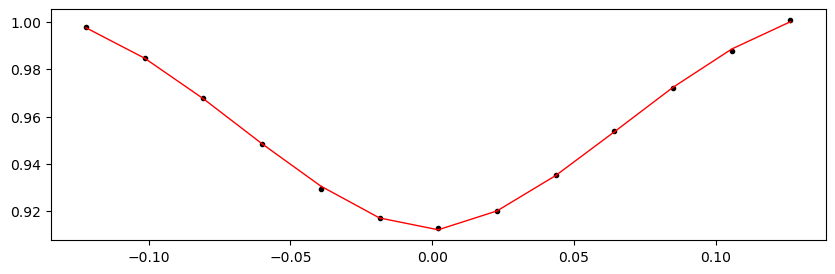

2151.829580225 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.40it/s]


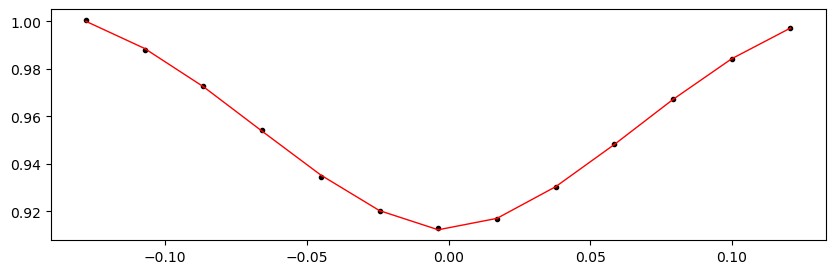

2152.164850775 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 455.04it/s]


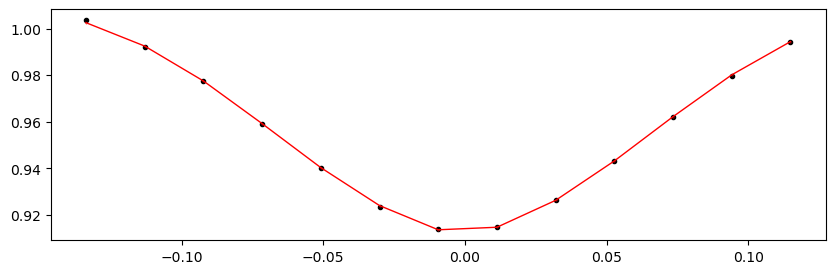

2152.500121325 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.84it/s]


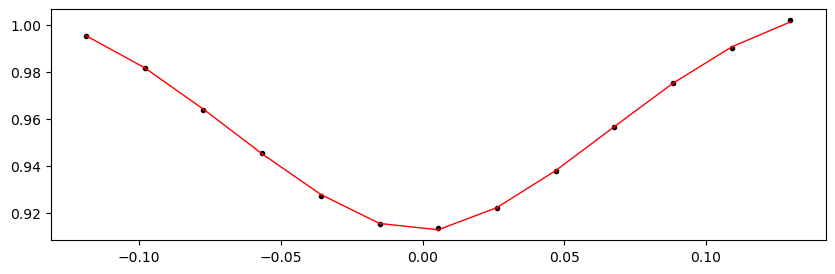

2152.835391875 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.14it/s]


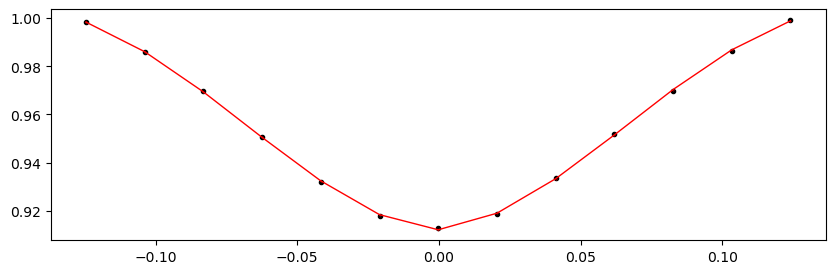

2153.170662425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.98it/s]


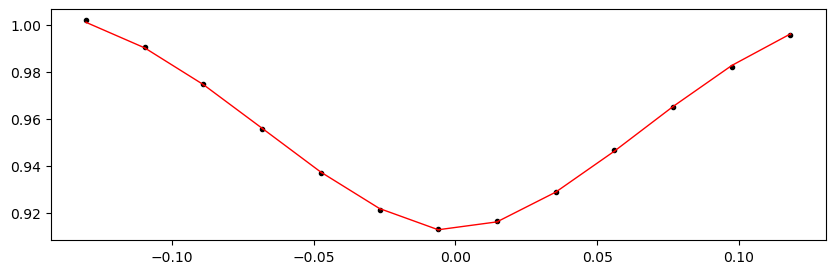

2153.505932975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 447.82it/s]


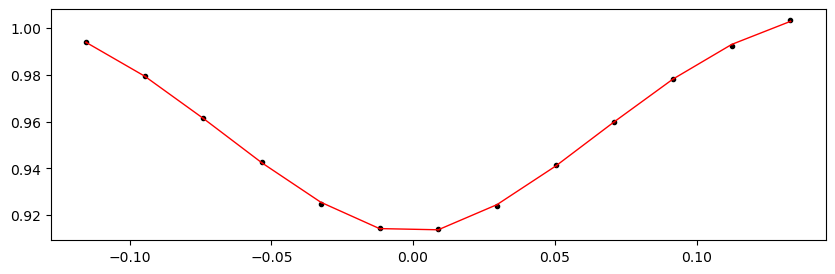

2153.841203525 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.14it/s]


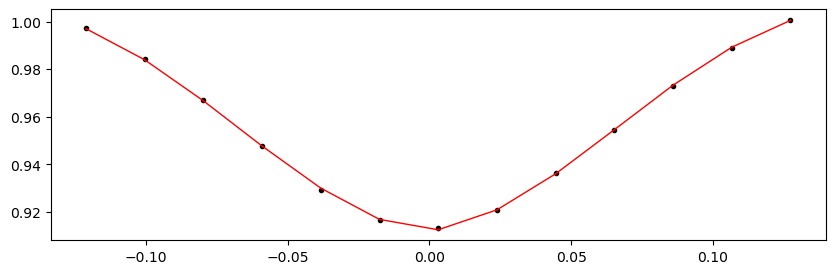

2154.176474075 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.88it/s]


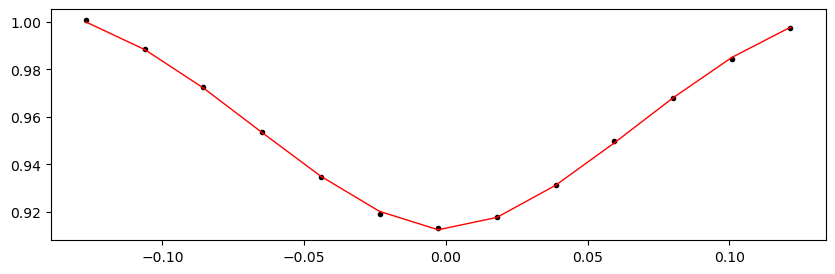

2154.511744625 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.11it/s]


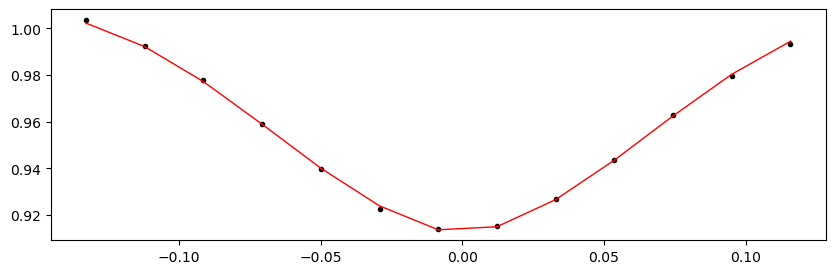

2154.847015175 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.30it/s]


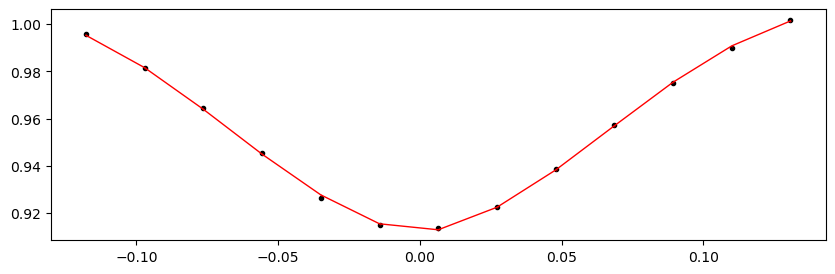

2155.182285725 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.08it/s]


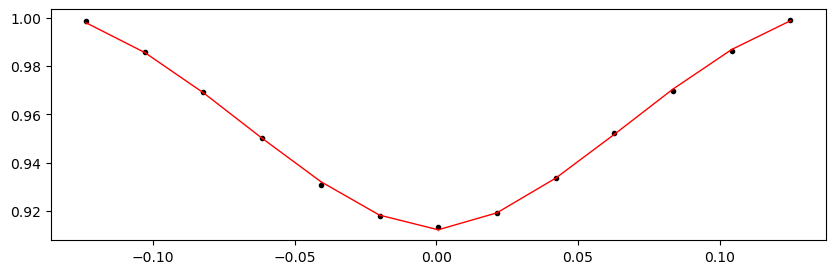

2155.517556275 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.83it/s]


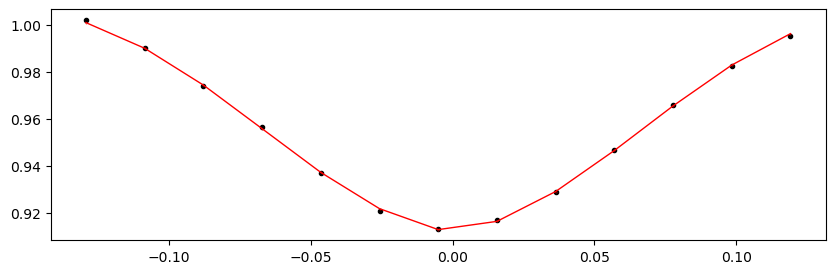

2155.852826825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.16it/s]


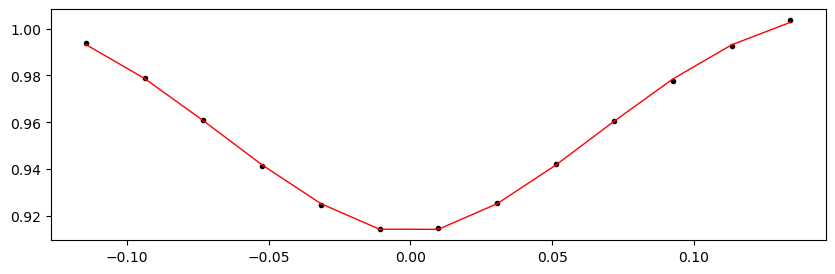

Time 2158.870261775 does not have enough data points: 5
2159.2055323249997 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.16it/s]


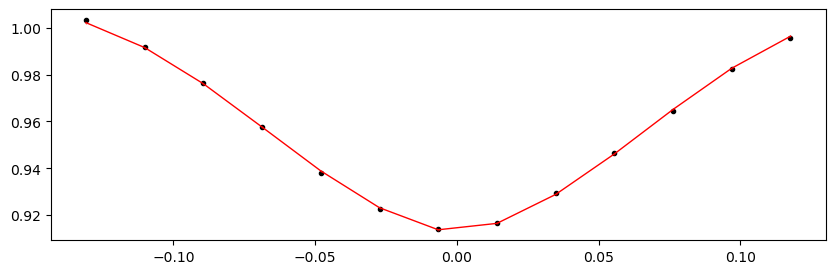

2159.540802875 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.66it/s]


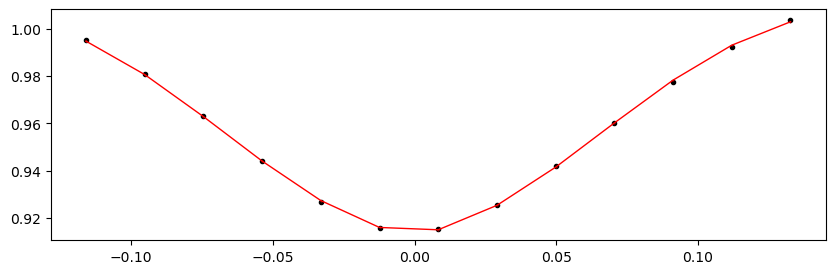

2159.876073425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.71it/s]


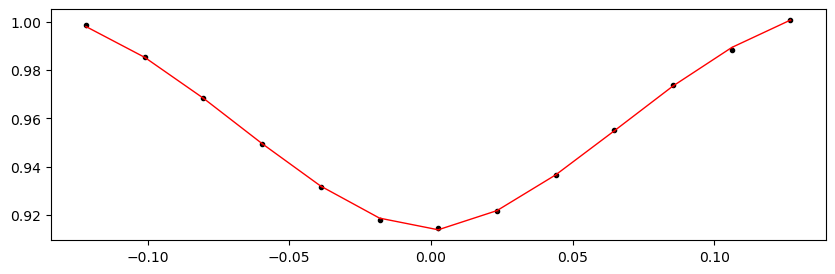

2160.211343975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.18it/s]


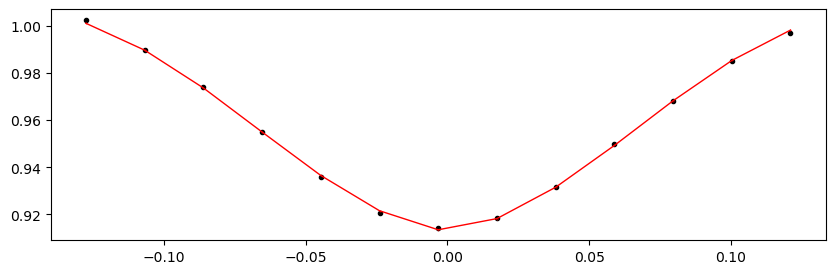

2160.546614525 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.86it/s]


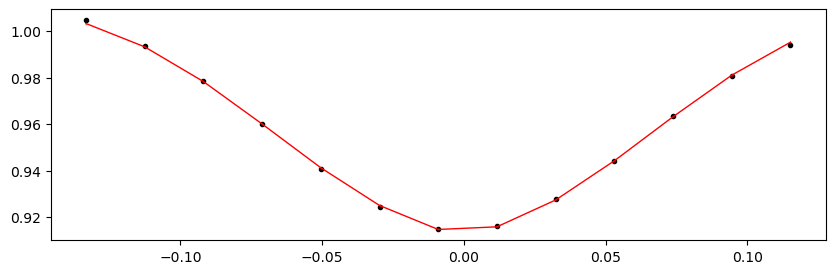

2160.881885075 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.40it/s]


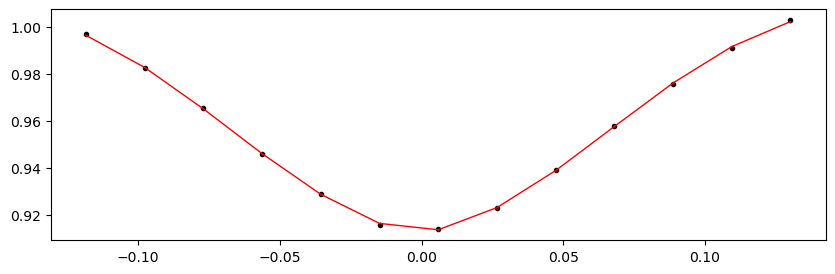

2161.217155625 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.03it/s]


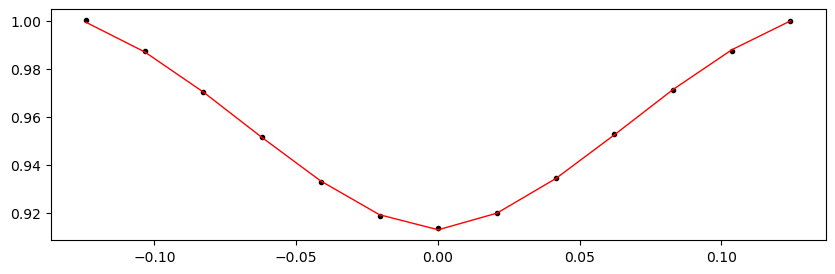

2161.5524261749997 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.61it/s]


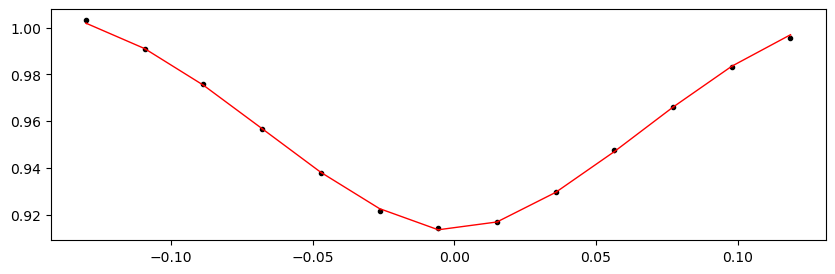

2161.887696725 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.94it/s]


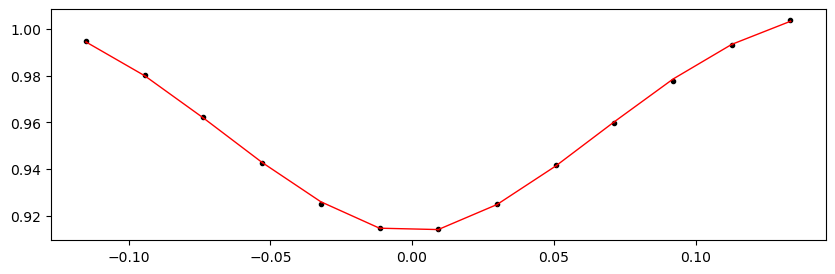

2162.222967275 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.45it/s]


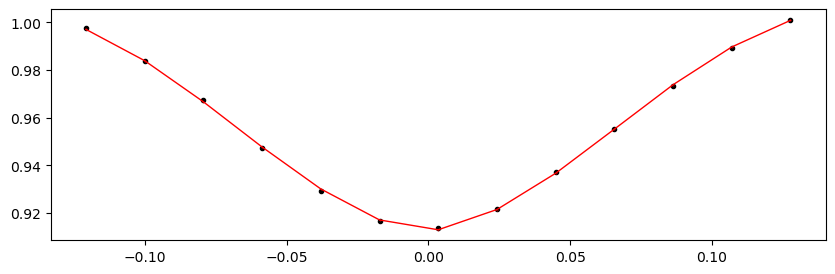

2162.558237825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.33it/s]


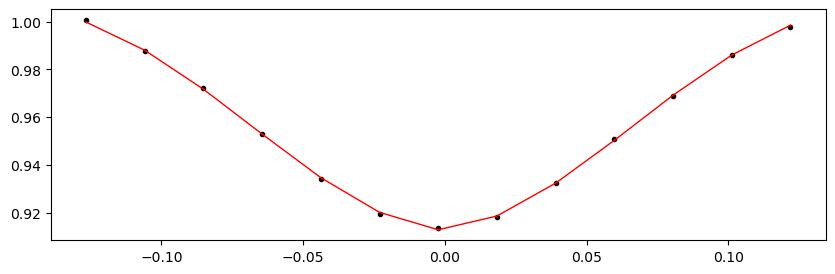

2162.8935083750002 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.10it/s]


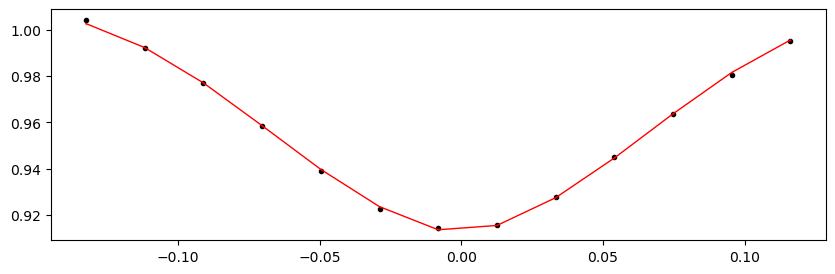

2163.228778925 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.76it/s]


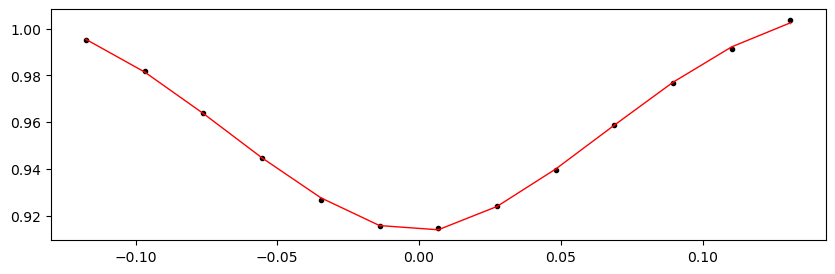

2163.564049475 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.11it/s]


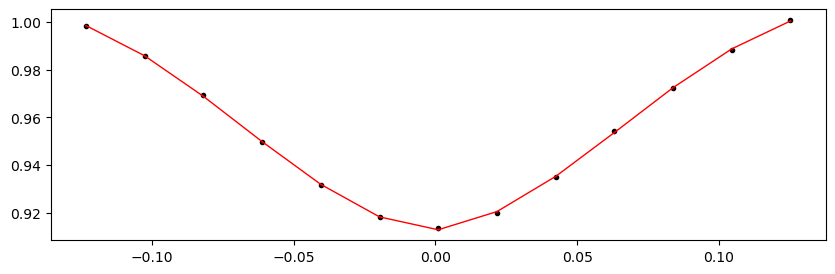

2163.8993200249997 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.42it/s]


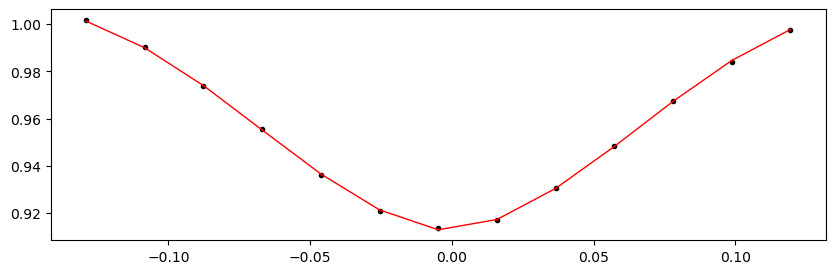

2164.234590575 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 454.39it/s]


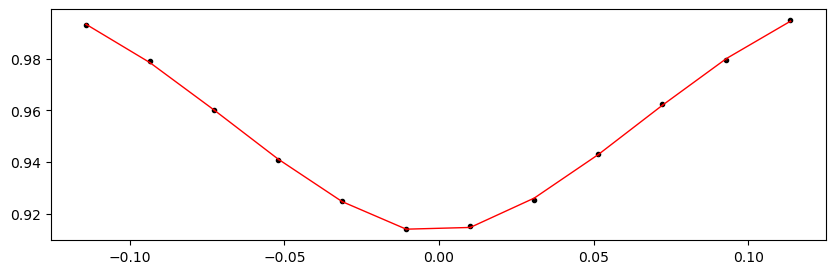

2164.569861125 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.47it/s]


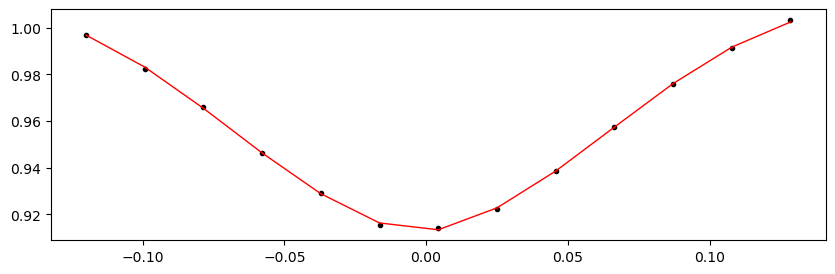

2164.905131675 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.28it/s]


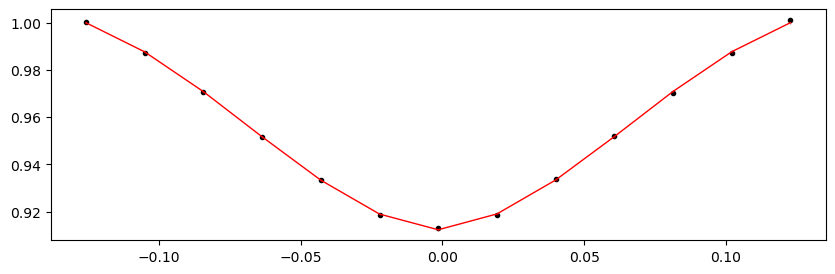

2165.2404022250003 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.16it/s]


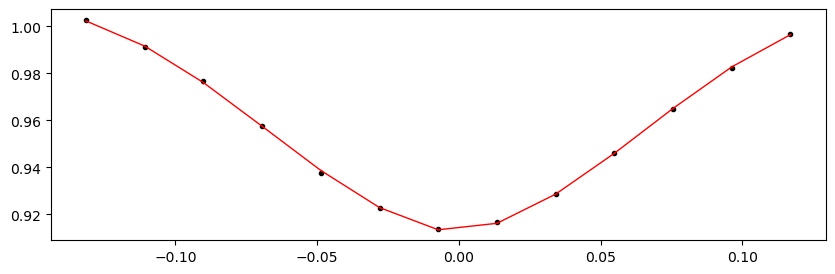

2165.575672775 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.43it/s]


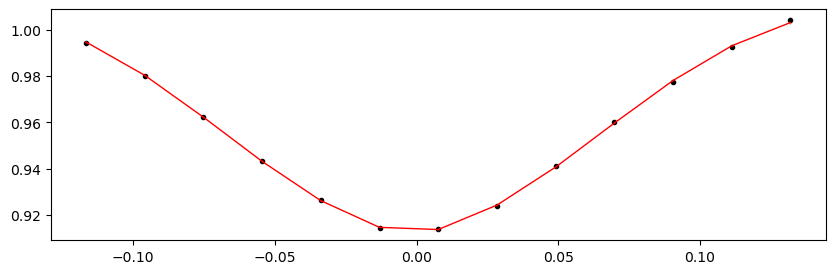

2165.910943325 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.27it/s]


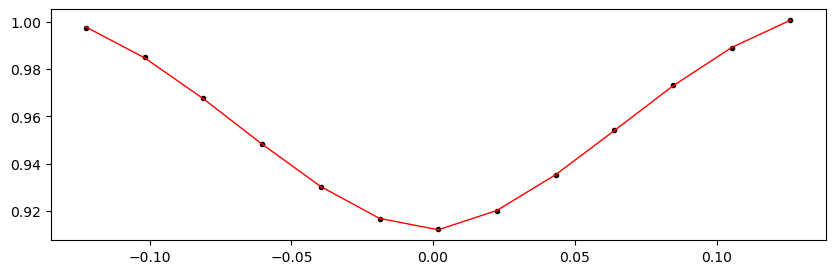

2166.2462138749997 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.71it/s]


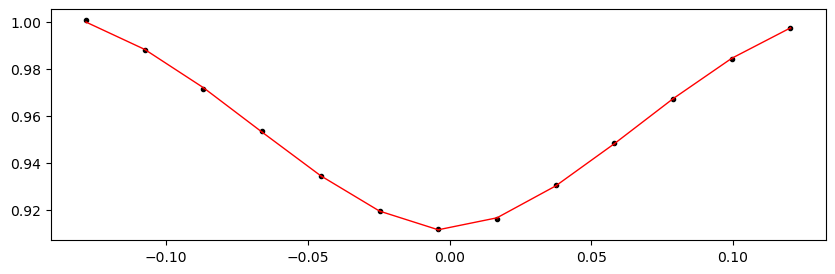

2166.581484425 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.48it/s]


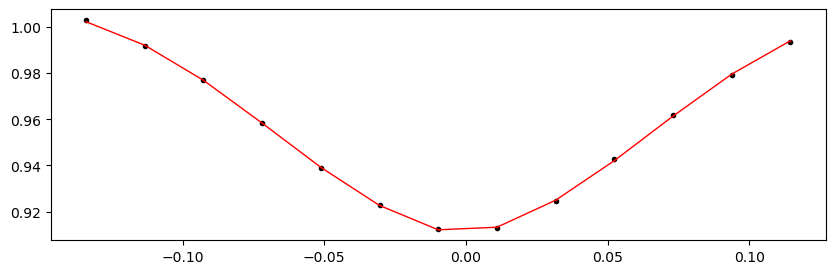

2166.916754975 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 452.61it/s]


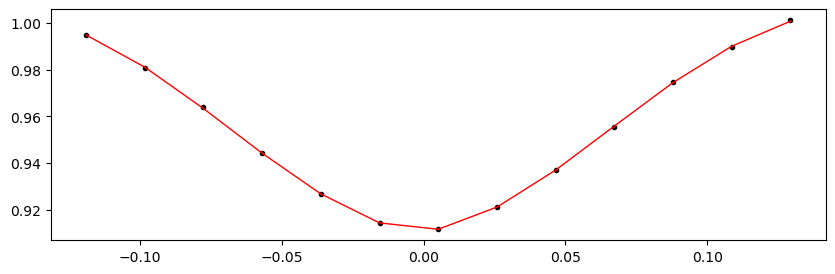

2167.252025525 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 449.53it/s]


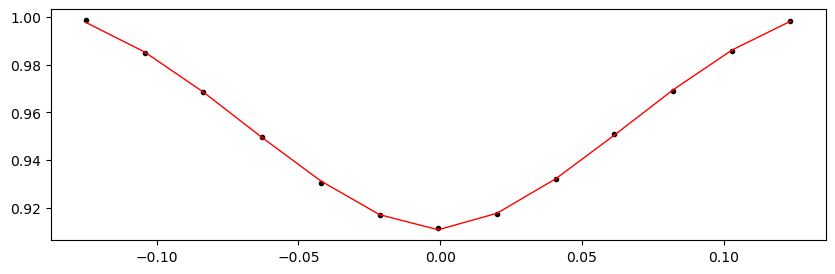

2167.587296075 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 448.62it/s]


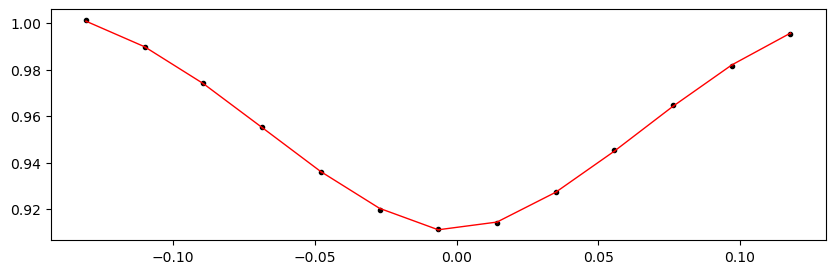

2167.922566625 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.09it/s]


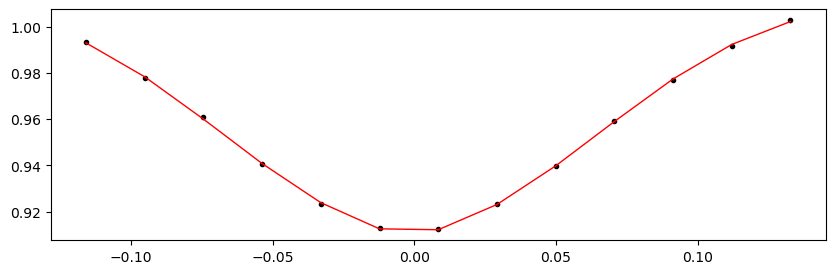

2168.257837175 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.48it/s]


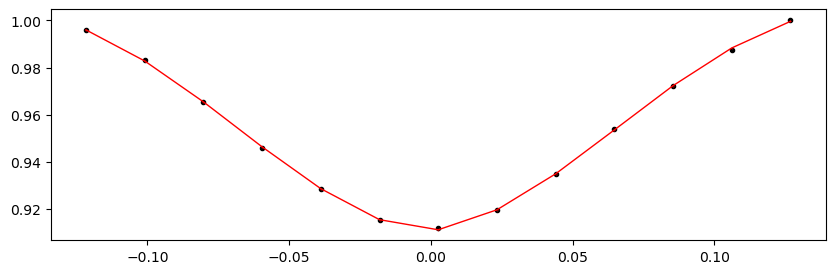

2168.5931077249998 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.48it/s]


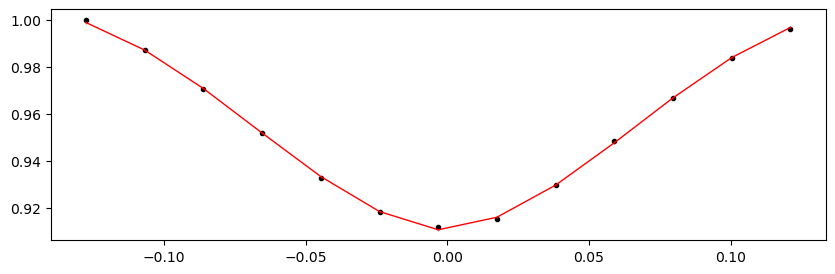

2168.928378275 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.39it/s]


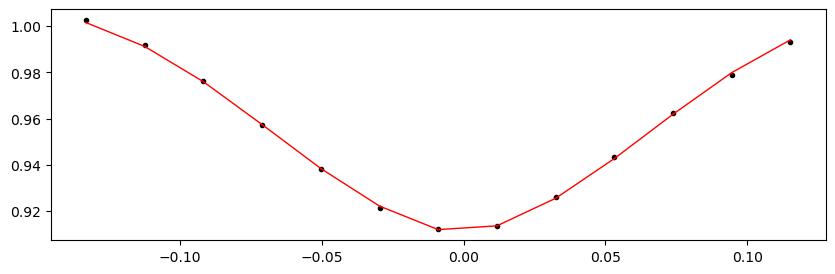

2169.263648825 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 450.55it/s]


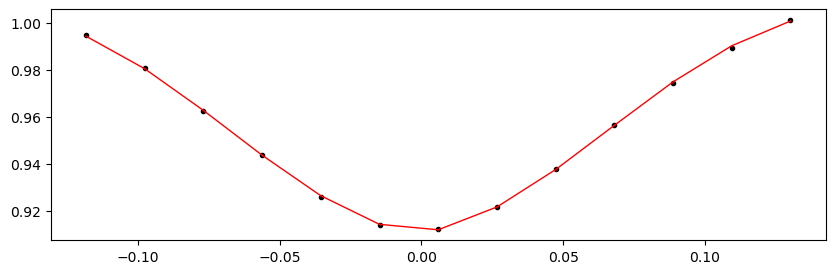

2169.598919375 1.0110237425915063 -0.09750654781432117 -0.2753552971313348


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 451.55it/s]


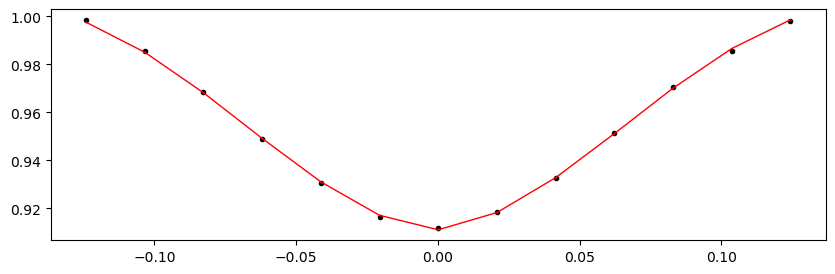

In [42]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=10,  # to handle 10 min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

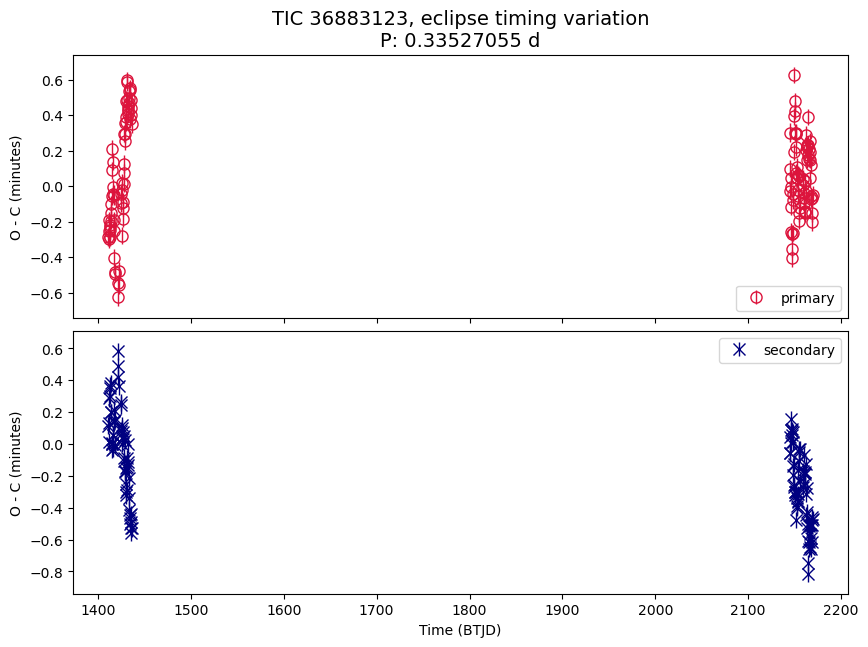

In [15]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### Compare with O-C Plot slightly different period

- No noticeable change

- Period is the average of the values from VSX and TESS EB. Cliipped lightcurve's duration per cycle is the smae.

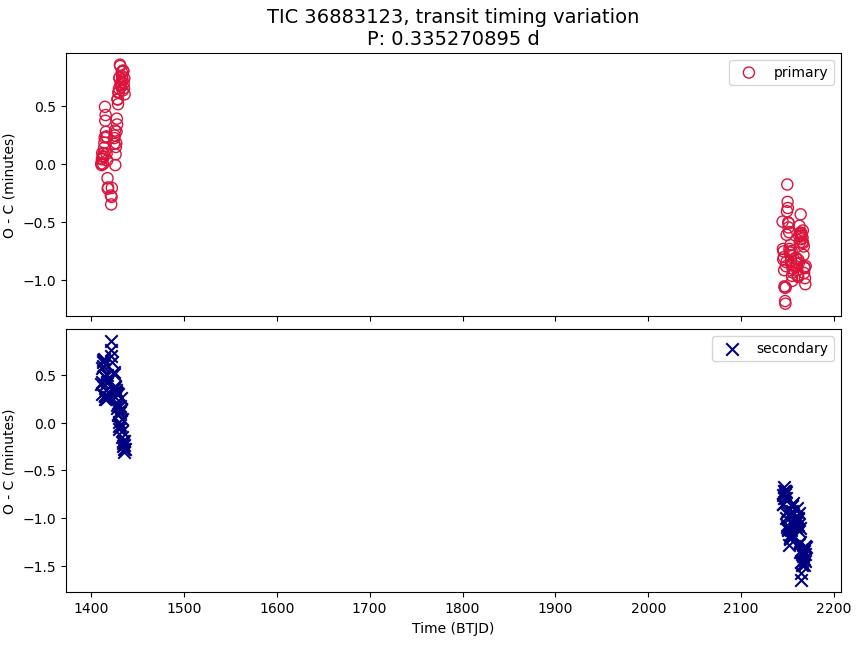

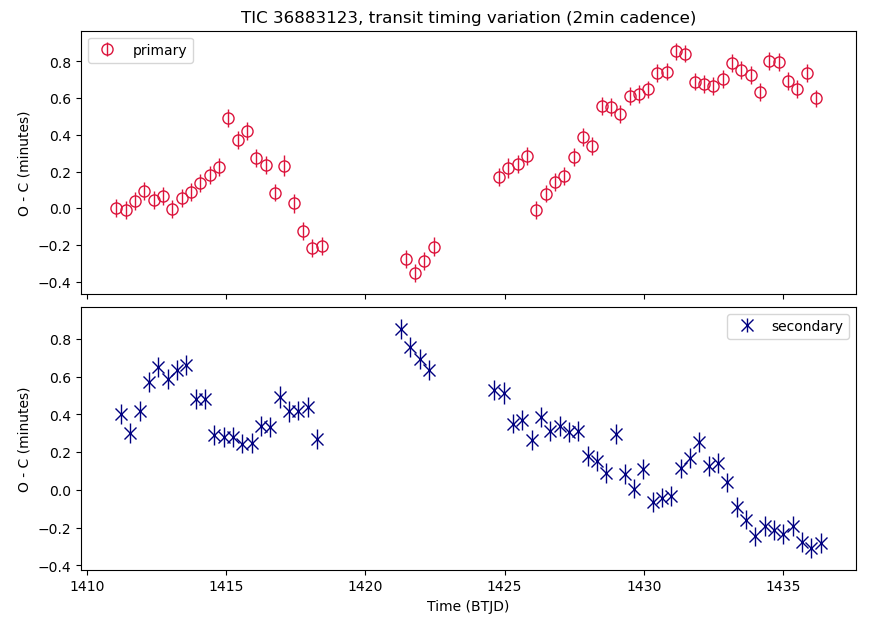

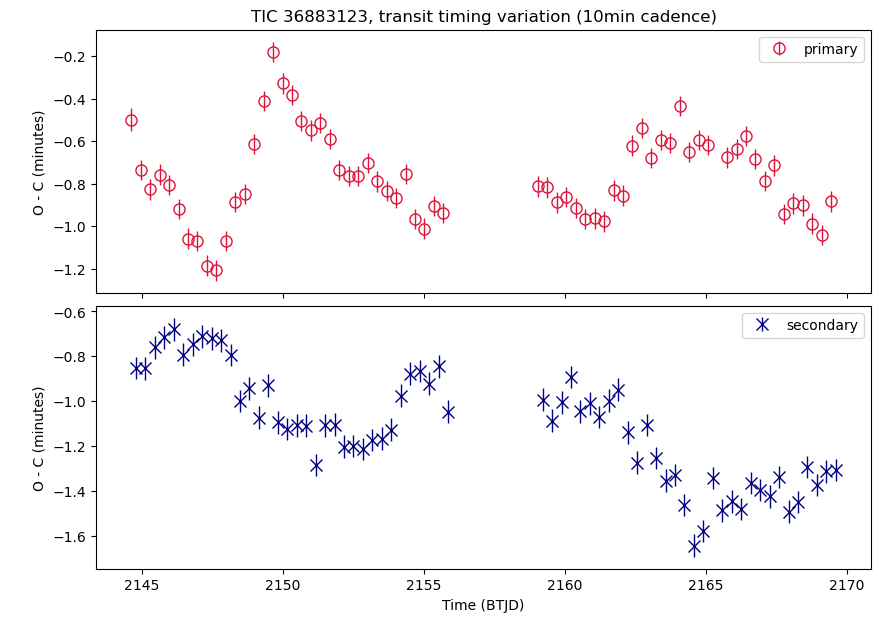

### O-C Plot, Zoom In

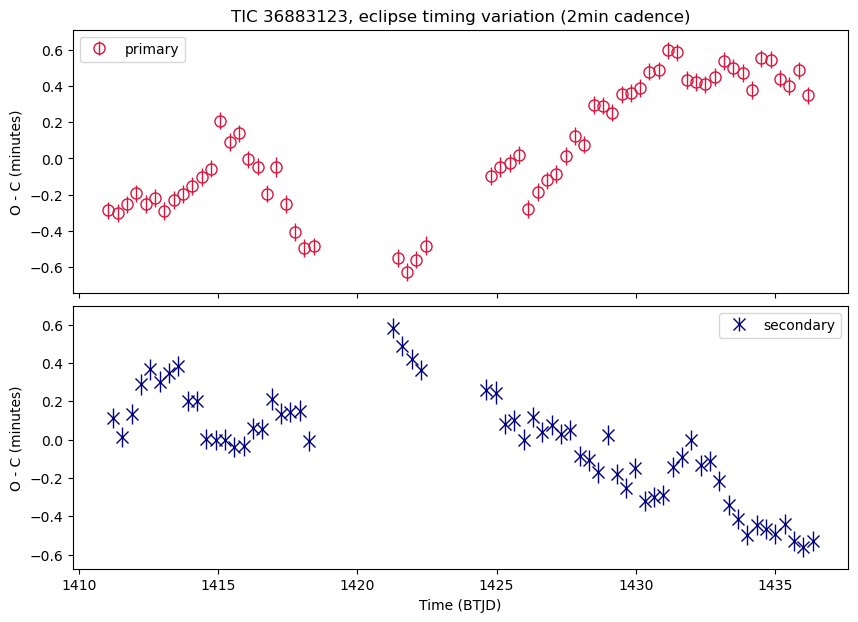

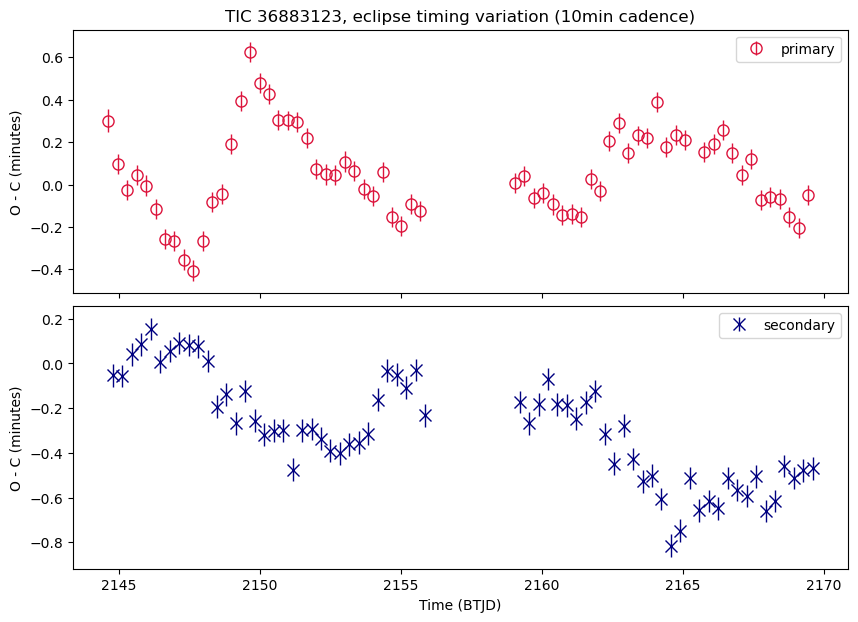

In [11]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1350, 1450),
    (2100, 2200),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    ax = axs_list[0][0]
    ax.set_title(f"{ax.get_title()} (2min cadence)")
    ax = axs_list[1][0]
    ax.set_title(f"{ax.get_title()} (10min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

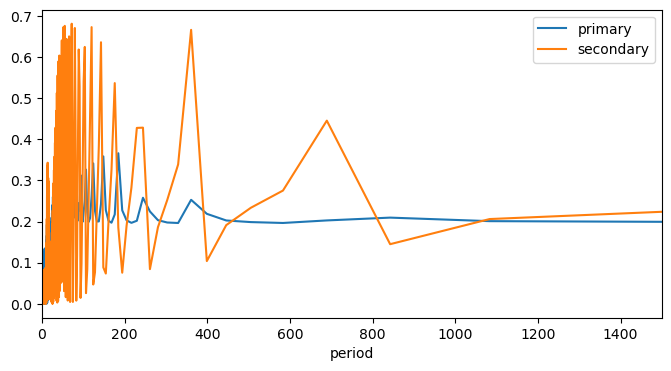

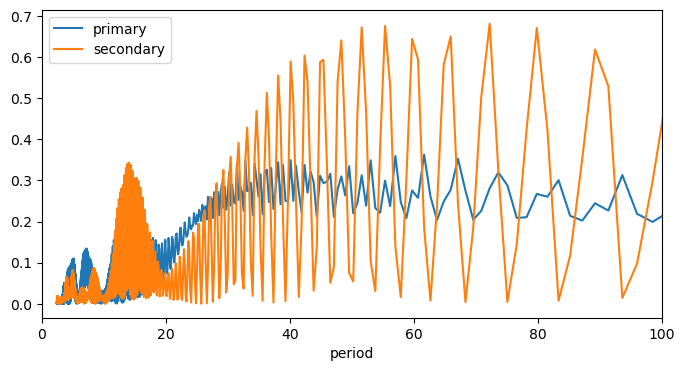

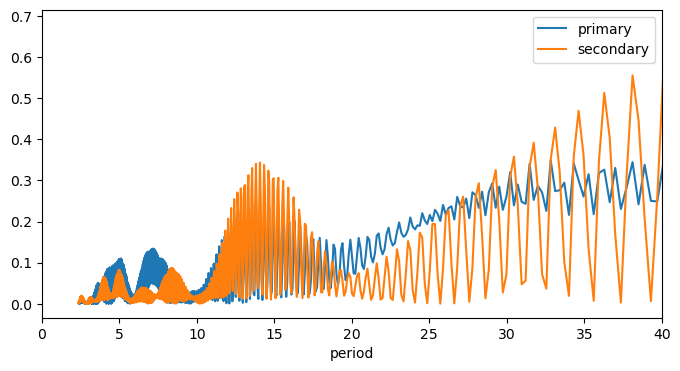

In [16]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 1500)
plt.show()


if True:  # zoom-in
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 100)
    plt.show()

if True:  # zoom-in
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 40)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [19]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

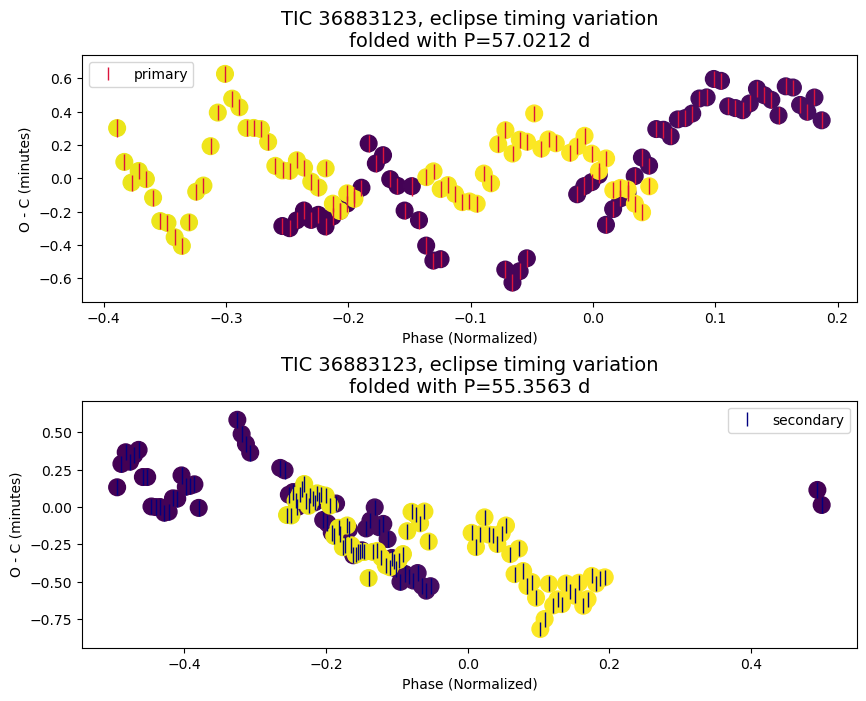

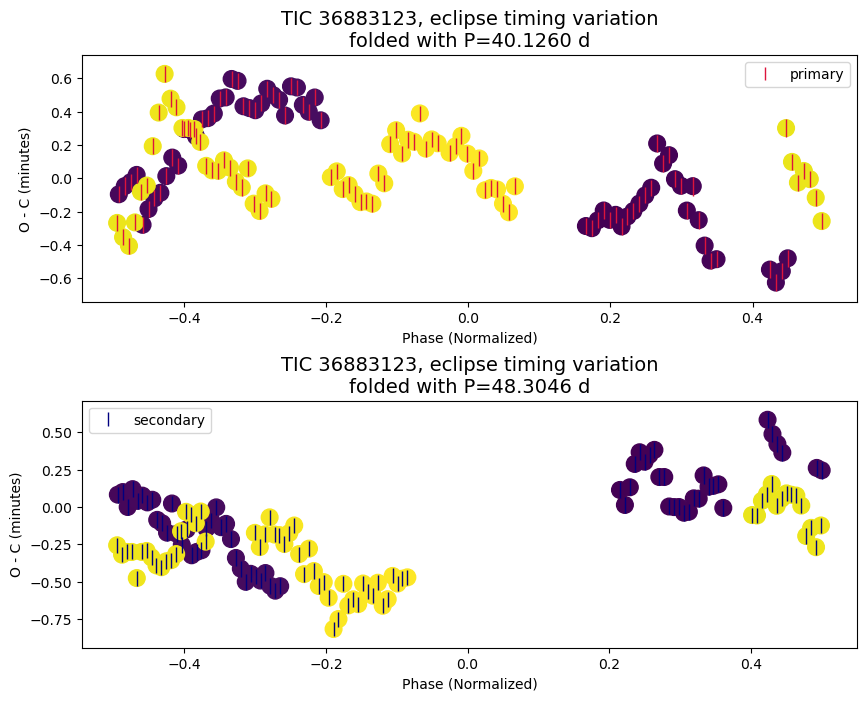

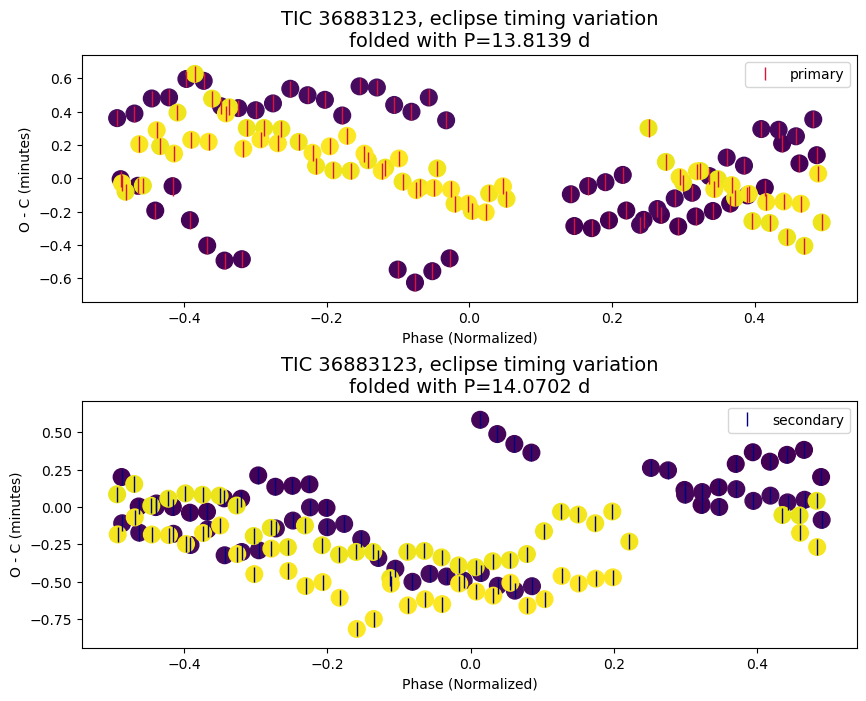

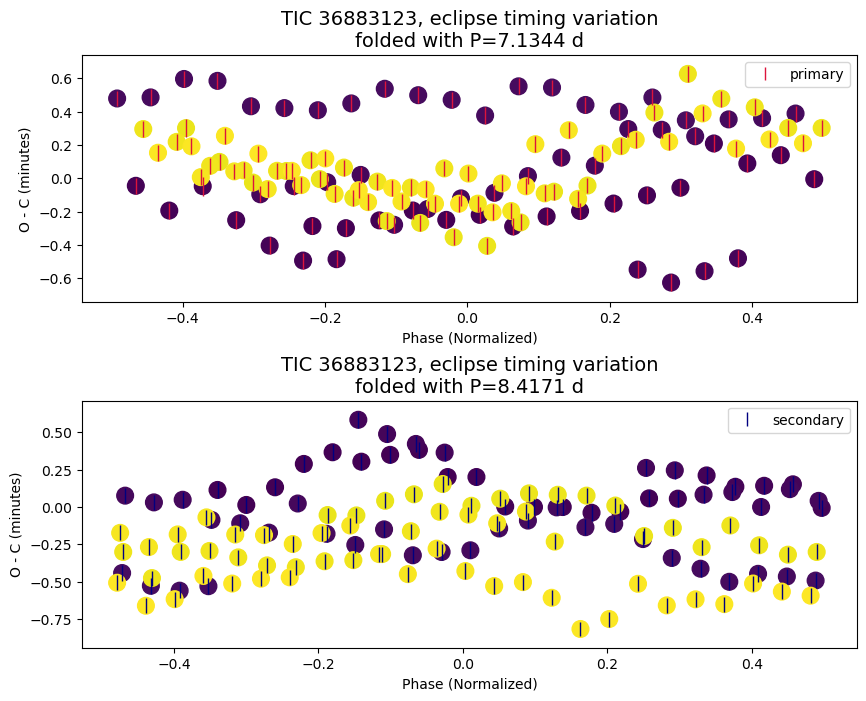

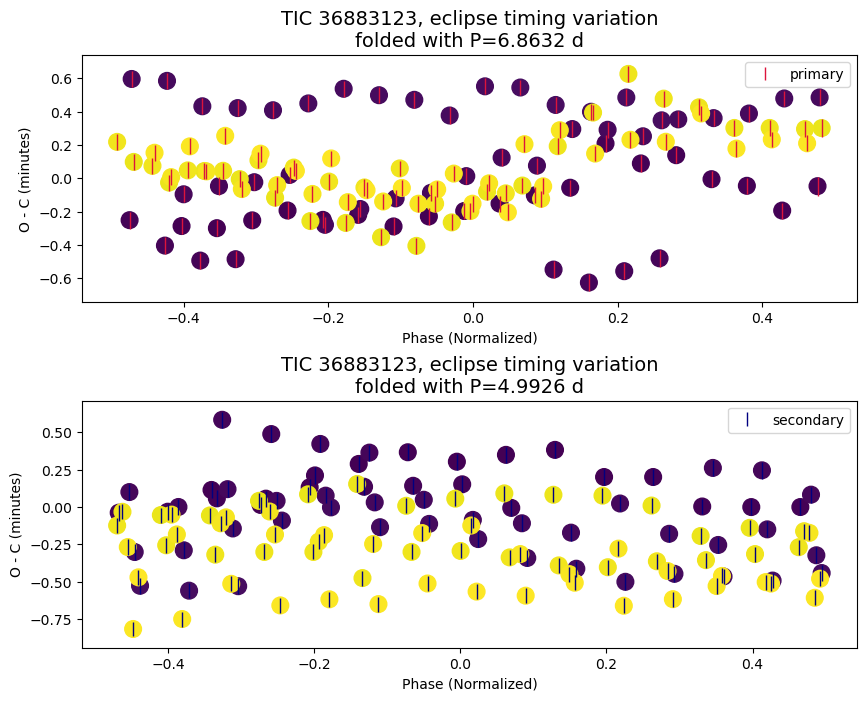

In [23]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=60,
        period_min_s=None, period_max_s=60,
    )
    axs = plot_oc_folded(
        period_min=None, period_max=50,
        period_min_s=None, period_max_s=50,
    )
    axs = plot_oc_folded(
        period_min=None, period_max=20,
        period_min_s=None, period_max_s=20,
    )
    axs = plot_oc_folded(
        period_min=None, period_max=10,
        period_min_s=None, period_max_s=10,
    )
    axs = plot_oc_folded(
        period_min=None, period_max=7,
        period_min_s=None, period_max_s=7,
    )
    # tweak_axs(axs)

## Results Summary

In [26]:
# FILL-IN the ETV results / comments
has_etv = "Y?"
comments = "Hints of long-term (800 d) non-linear trend with amplitude ~2min in 2 sectors. No clear O-C period (~14 d a possibility). The trend of primary is opposite of the one of secondary. [D_no_ingress]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                                                                                                    36883123
has_etv                                                                                                                                                                                                      Y?
comments     Hints of long-term (800 d) non-linear trend with amplitude ~2min in 2 sectors. No clear O-C period (~14 d a possibility). The trend of primary is opposite of the one of secondary. [D_no_ingress]
period                                                                                                                                                                                                 0.335271
depth_pct_p                                                                                                                                                                                               10.33
depth_pct_s                                                                                                                                                                                                9.75
epoch_p                                                                                                                                                                                               1411.0493
epoch_s                                                                                                                                                                                             1411.216935
num_sectors                                                                                                                                                                                                   2
time_span                                                                                                                                                                                                759.04
time_start                                                                                                                                                                                              1410.91
time_end                                                                                                                                                                                                2169.95


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
36883123,Y?,Hints of long-term (800 d) non-linear trend with amplitude ~2min in 2 sectors. No clear O-C period (~14 d a possibility). The trend of primary is opposite of the one of secondary. [D_no_ingress],0.33527055,10.33,9.75,1411.0493,1411.216935275,2,759.04,1410.91,2169.95

